In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr
import gtfparse


intron_annot = pd.read_csv('/project2/yangili1/bjf79/ChromatinSplicingQTLs/data/IntronAnnotationsFromYang.tsv.gz', sep='\t')
intron_annot['junction'] = intron_annot[['chrom', 'start', 'end', 'strand']].astype(str).agg(':'.join, axis=1)
long_table = pd.read_csv(
    '/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/SplicingAnalysis/CombinedJuncTables/YRI.tsv.gz', sep='\t'
)

long_table = long_table.loc[long_table.RepNumber == '1.junc'].drop_duplicates()
long_table = long_table.loc[~((long_table.IndID == 'NA18855') & (long_table.Dataset == 'chRNA.Expression.Splicing'))]

# Adjustment needed to match the introns in Yang's annotation...
long_table.stop += 1

long_table = long_table.merge(intron_annot, left_on=['chrom', 'start', 'stop', 'strand'], 
                 right_on=['chrom', 'start', 'end', 'strand'])

long_table['gene'] = [x.split('.')[0] for x in long_table.gene]

del intron_annot
expressed_genes = pd.read_csv('../code/ExpressionAnalysis/polyA/ExpressedGeneList.txt', sep ='\t',
                             names = ['chrom', 'start', 'end', 'gene', 'score', 'strand'])

expressed_genes.gene = [x.split('.')[0] for x in expressed_genes.gene]

INFO:numexpr.utils:Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
long_table = long_table.loc[long_table.Dataset == 'chRNA.Expression.Splicing']

In [3]:
gene_total = pd.DataFrame(long_table.groupby(['gene', 'IndID']).Count.sum()).reset_index()
gene_total.columns = ['gene', 'IndID', 'gene_total']

gene_max = pd.DataFrame(long_table.groupby(['gene', 'IndID']).Count.max()).reset_index()
gene_max.columns = ['gene', 'IndID', 'gene_max']

long_table = long_table.merge(gene_total, left_on=['gene', 'IndID'], right_on=['gene', 'IndID']).merge(
    gene_max, left_on=['gene', 'IndID'], right_on=['gene', 'IndID']
)

In [5]:
long_table['PSI_total'] = long_table.Count/long_table.gene_total
long_table['PSI'] = long_table.Count/long_table.gene_max

In [6]:
# gene_total = pd.DataFrame(long_table.groupby(['gene', 'IndID']).Count.sum()).reset_index()
# gene_total.columns = ['gene', 'IndID', 'gene_total']
# long_table = long_table.merge(gene_total, left_on=['gene', 'IndID'], right_on=['gene', 'IndID'])

In [7]:
# long_table['PSI'] = long_table.Count/long_table.gene_total

In [8]:
long_table = long_table.loc[long_table.gene.isin(expressed_genes.gene)]

In [9]:
NMD = ['AnnotatedJunc_UnproductiveCodingGene', 'UnannotatedJunc_UnproductiveCodingGene']
PC = ['AnnotatedJunc_ProductiveCodingGene', 'UnannotatedJunc_ProductiveCodingGene']
# long_table.loc[long_table.SuperAnnotation.isin(NMD)].Count.sum()

In [10]:
long_table_sum = long_table.groupby(['gene', 'symbol', 'junction', 'NewAnnotation', 'SuperAnnotation']
                                   ).Count.sum().reset_index()

gene_total_sum = pd.DataFrame(long_table_sum.groupby(['gene']).Count.max()).reset_index()
gene_total_sum.columns = ['gene',  'gene_max']

long_table_sum = long_table_sum.merge(gene_total_sum, left_on='gene', right_on='gene')
long_table_sum['PSI'] = long_table_sum.Count/long_table_sum.gene_max

In [11]:
# long_table_sum['PSI_'] = long_table_sum.Count/long_table_sum.gene_total

In [12]:
def plot_cumulative(x, a=-2000,b=2000, d=500, ax=None, label=None, **kwargs):
    csum = get_csum(x, a, b, d)
    if not ax:
        if label:
            plt.plot(np.linspace(a, b, d), csum, label=label, **kwargs)
        else:
            plt.plot(np.linspace(a, b, d), csum, **kwargs)
    else:
        if label:
            ax.plot(np.linspace(a, b, d), csum, label=label, **kwargs)
        else:
            ax.plot(np.linspace(a, b, d), csum, **kwargs)
    
def get_csum(x, a, b, d):
    csum = []
    for a in np.linspace(a, b, d):
        csum.append(get_percent_observed(x, a))
    return csum
    
def get_percent_observed(x, a):
    percent_observed = (x <= a).mean()
    return percent_observed

In [13]:
long_table_sum_NMD = long_table_sum.loc[long_table_sum.SuperAnnotation.isin(NMD)]
long_table_sum_PC = long_table_sum.loc[long_table_sum.SuperAnnotation.isin(PC)]

In [14]:
x = np.linspace(0, 1, 1001)

In [15]:
contribution_NMD = [long_table_sum_NMD.loc[long_table_sum_NMD.PSI <= y].Count.sum() for y in x]
contribution_PC = [long_table_sum_PC.loc[long_table_sum_PC.PSI <= y].Count.sum() for y in x]

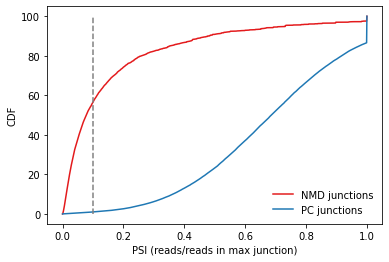

In [16]:
plt.plot(x, 100*np.array(contribution_NMD)/np.max(contribution_NMD), label='NMD junctions', c='#e31a1c')
plt.plot(x, 100*np.array(contribution_PC)/np.max(contribution_PC), label='PC junctions', c='#1f78b4')
plt.plot([0.1, 0.1], [0, 100], linestyle='--', c='gray')
plt.xlabel('PSI (reads/reads in max junction)')
plt.ylabel('CDF')
plt.legend(frameon=False)

In [17]:
long_table_NMD = long_table.loc[long_table.SuperAnnotation.isin(NMD)]
NMD_by_gene = long_table_NMD.groupby(['gene', 'symbol', 'junction']).PSI.mean().reset_index()
NMD_by_gene = NMD_by_gene.groupby(['gene', 'symbol']).PSI.max().reset_index()

RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)
RPKM.index = [x.split('.')[0] for x in RPKM.index]

log2RPKM = RPKM[RPKM.columns.intersection(pd.Index(long_table.IndID.unique()))].median(axis=1).reset_index()
log2RPKM.columns = ['gene', 'RPKM']

polyA_RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)
polyA_RPKM.index = [x.split('.')[0] for x in polyA_RPKM.index]

log2polyA_RPKM = polyA_RPKM[polyA_RPKM.columns.intersection(pd.Index(long_table.IndID.unique()))].median(axis=1).reset_index()
log2polyA_RPKM.columns = ['gene', 'polyA_RPKM']

NMD_by_gene = NMD_by_gene.merge(log2RPKM, left_on='gene', right_on='gene')

scores = pd.read_csv('../../media-1.tsv', sep='\t', index_col=0)

genes = pd.read_csv('../../genes.txt', sep='\t', names=['genes'], index_col=0)
genes.index = [x.split('.')[0] for x in genes.index]

srsf = ['SRSF'+str(x) for x in range(13)]
srsf_ensembl = genes.loc[genes.genes.isin(srsf)].index.intersection(pd.Index(NMD_by_gene.gene))

NMD_by_gene = NMD_by_gene.merge(scores, left_on='gene', right_index=True)

import sys

sys.path.append('../code/scripts/useful_modules')

from plot_functions import *
from regression_functions import *

def print_pval(pval):
    if pval > 0.01:
        str_pval = str(round(pval, 2))
    else:
        str_pval = '%.2E' % Decimal(pval)
    return str_pval

def annotate_pval(X, Y, ax, xy = (0.05, 0.1), col='black'):
    
    corr_label = 'Spearman r'
    corr = spearmanr(X, Y)

    str_cor = "{:.2f}".format(corr[0])#str(round(corr[0], 2))
    str_pval = print_pval(corr[1])

    legend = corr_label + ' = ' + str_cor + '\n' + 'pval = ' + str_pval
    ax.annotate(legend, xy=xy, xycoords='axes fraction', c=col)
    
NMD_by_gene = NMD_by_gene.merge(log2polyA_RPKM, left_on='gene', right_on='gene')

In [26]:
import sys

sys.path.append('../code/scripts/useful_modules')

from plot_functions import *
from regression_functions import *

def print_pval(pval):
    if pval > 0.01:
        str_pval = str(round(pval, 2))
    else:
        str_pval = '%.2E' % Decimal(pval)
    return str_pval

def annotate_pval(X, Y, ax, xy = (0.05, 0.1), col='black'):
    
    corr_label = 'Spearman r'
    corr = spearmanr(X, Y)

    str_cor = "{:.2f}".format(corr[0])#str(round(corr[0], 2))
    str_pval = print_pval(corr[1])

    legend = corr_label + ' = ' + str_cor + '\n' + 'pval = ' + str_pval
    ax.annotate(legend, xy=xy, xycoords='axes fraction', c=col)

In [27]:
NMD_by_gene = NMD_by_gene.merge(log2polyA_RPKM, left_on='gene', right_on='gene')

In [120]:
NMD_by_gene

gene      symbol       PSI      RPKM        hgnc  chrom  \
0      ENSG00000000419        DPM1  0.027426  4.956947   HGNC:3005  chr20   
1      ENSG00000000457       SCYL3  0.067388  2.778199  HGNC:19285   chr1   
2      ENSG00000000460    C1orf112  0.116244  3.658522  HGNC:25565   chr1   
3      ENSG00000000938         FGR  0.117739  5.817197   HGNC:3697   chr1   
4      ENSG00000001036       FUCA2  0.051398  3.147563   HGNC:4008   chr6   
...                ...         ...       ...       ...         ...    ...   
11323  ENSG00000280789       PAGR1  0.036527  2.398451  HGNC:28707  chr16   
11324  ENSG00000282988  AL031777.2  0.833333  1.041698   HGNC:4767   chr6   
11325  ENSG00000284024  AC069544.1  0.391197  3.488467  HGNC:29526  chr10   
11326  ENSG00000284770        TBCE  0.083500  1.276375  HGNC:11582   chr1   
11327  ENSG00000285077   ARHGAP11B  0.236842  3.378652  HGNC:15782  chr15   

       obs_lof  exp_lof  prior_mean  post_mean  post_lower_95  post_upper_95  \
0          9.0  17.9800    0.015030   0.017280       0.002883       0.038134   
1          8.0  34.3200    0.009598   0.026510       0.008297       0.048808   
2         23.0  44.6360    0.003274   0.001609       0.000180       0.004741   
3          6.0  27.8370    0.033294   0.043014       0.019917       0.075332   
4         14.0  24.2610    0.001359   0.000902       0.000036       0.003496   
...        ...      ...         ...        ...            ...            ...   
11323      1.0   8.8160    0.028018   0.165779       0.007167       0.531561   
11324      4.0   3.4746    0.020204   0.002177       0.000021       0.009345   
11325      6.0  29.9440    0.039154   0.052411       0.026162       0.090981   
11326     18.0  33.1770    0.004361   0.004579       0.000508       0.013568   
11327      9.0   9.9439    0.000638   0.000636       0.000013       0.002476   

       polyA_RPKM  
0        5.405040  
1        1.669527  
2        2.305371  
3        5.366448  
4        3.592610  
...           ...  
11323    1.335603  
11324   -1.776438  
11325    3.047649  
11326   -3.426359  
11327   -0.757719  

[11328 rows x 13 columns]

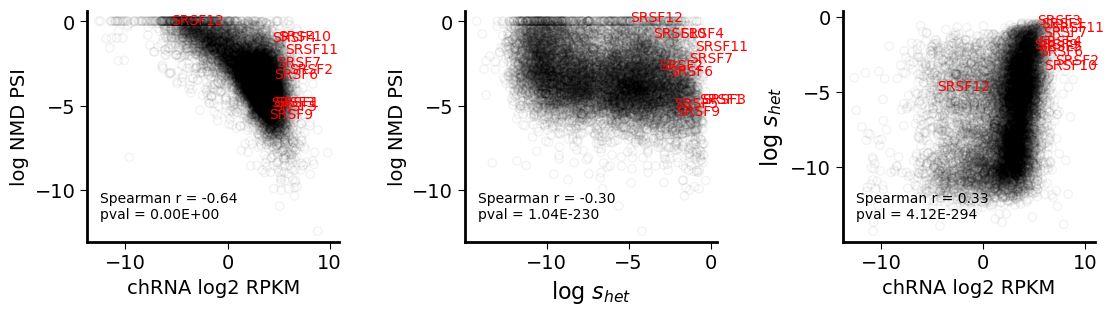

In [121]:
# NMD_by_gene_sr
kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.05}

fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw={'wspace': 0.5}, figsize=(13, 3))

ax[0].scatter(NMD_by_gene.RPKM, np.log2(NMD_by_gene.PSI), **kwargs)
for idx, row in NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl)].iterrows():
    ax[0].annotate(row.symbol, (row.RPKM-1, np.log2(row.PSI)-0.2), c='red', size=10)
    
annotate_pval(NMD_by_gene.RPKM, np.log2(NMD_by_gene.PSI), ax[0], xy = (0.05, 0.1))
    
ax[1].scatter(np.log2(NMD_by_gene.post_mean),np.log2(NMD_by_gene.PSI), **kwargs)
for idx, row in NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl)].iterrows():
    ax[1].annotate(row.symbol, (np.log2(row.post_mean), np.log2(row.PSI)), c='red', size=10)
    
annotate_pval(np.log2(NMD_by_gene.post_mean), np.log2(NMD_by_gene.PSI), ax[1], xy = (0.05, 0.1))

# kwargs_ = {'facecolor':'none', 'edgecolor':'bla', 'alpha':0.1}

ax[2].scatter(NMD_by_gene.RPKM, np.log2(NMD_by_gene.post_mean), **kwargs)
for idx, row in NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl)].iterrows():
    ax[2].annotate(row.symbol, (row.RPKM, np.log2(row.post_mean)), c='red', size=10)

annotate_pval(NMD_by_gene.RPKM, np.log2(NMD_by_gene.post_mean), ax[2], xy = (0.05, 0.1), col='black')


for i in range(3):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 RPKM', size=14)
ax[0].set_ylabel('log NMD PSI', size=14)

ax[1].set_ylabel('log NMD PSI', size=14)
ax[1].set_xlabel('log $s_{het}$', size=16)


ax[2].set_xlabel('chRNA log2 RPKM', size=14)
ax[2].set_ylabel('log $s_{het}$', size=16)

# ax[1].set_yticks([])
# ax[2].set_yticks([])

plt.show()

# plt.savefig(figdir + 'supplementary_figures/SRSF_NMD_v_RPKM_v_s_het.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'supplementary_figures/SRSF_NMD_v_RPKM_v_s_het.png', dpi=300, bbox_inches='tight',)

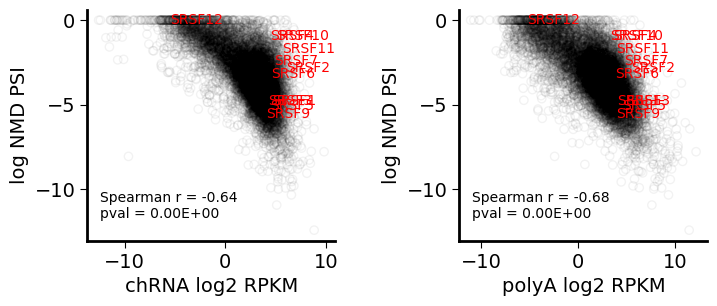

In [123]:
# NMD_by_gene_sr
kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.05}

fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'wspace': 0.5}, figsize=(8, 3))

ax[0].scatter(NMD_by_gene.RPKM, np.log2(NMD_by_gene.PSI), **kwargs)
for idx, row in NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl)].iterrows():
    ax[0].annotate(row.symbol, (row.RPKM-1, np.log2(row.PSI)-0.2), c='red', size=10)
    
annotate_pval(NMD_by_gene.RPKM, np.log2(NMD_by_gene.PSI), ax[0], xy = (0.05, 0.1))
    
ax[1].scatter(NMD_by_gene.polyA_RPKM, np.log2(NMD_by_gene.PSI), **kwargs)
for idx, row in NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl)].iterrows():
    ax[1].annotate(row.symbol, (row.polyA_RPKM-1, np.log2(row.PSI)-0.2), c='red', size=10)
    
annotate_pval(NMD_by_gene.polyA_RPKM, np.log2(NMD_by_gene.PSI), ax[1], xy = (0.05, 0.1))


for i in range(2):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 RPKM', size=14)
ax[0].set_ylabel('log NMD PSI', size=14)

ax[1].set_xlabel('polyA log2 RPKM', size=14)
ax[1].set_ylabel('log NMD PSI', size=14)


# ax[2].set_xlabel('chRNA log2 RPKM', size=14)
# ax[2].set_ylabel('log $s_{het}$', size=16)

# ax[1].set_yticks([])
# ax[2].set_yticks([])

plt.show()

# plt.savefig(figdir + 'supplementary_figures/SRSF_NMD_v_RPKM_v_s_het.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'supplementary_figures/SRSF_NMD_v_RPKM_v_s_het.png', dpi=300, bbox_inches='tight',)

In [136]:
NMD_by_gene['TPM'] = 1e6*np.exp(NMD_by_gene.RPKM)/np.sum(np.exp(NMD_by_gene.RPKM))
NMD_by_gene['logTPM'] = np.log2(1e6*np.exp(NMD_by_gene.RPKM)/np.sum(np.exp(NMD_by_gene.RPKM)))
NMD_by_gene['NMD_transcripts'] = NMD_by_gene.TPM*NMD_by_gene.PSI


In [138]:
NMD_by_gene['polyA_TPM'] = 1e6*np.exp(NMD_by_gene.polyA_RPKM)/np.sum(np.exp(NMD_by_gene.polyA_RPKM))
NMD_by_gene['logpolyA_TPM'] = np.log2(1e6*np.exp(NMD_by_gene.polyA_RPKM)/np.sum(np.exp(NMD_by_gene.polyA_RPKM)))


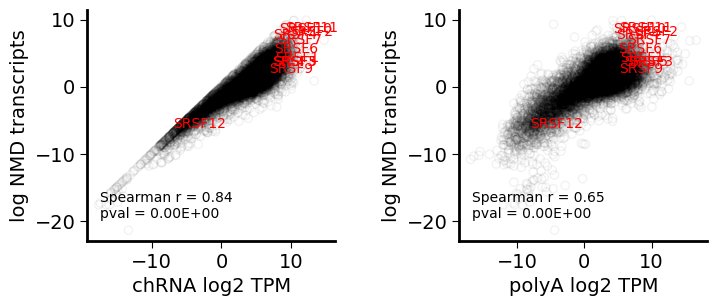

In [141]:

# NMD_by_gene_sr
kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.05}

fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'wspace': 0.5}, figsize=(8, 3))

ax[0].scatter(NMD_by_gene.logTPM, np.log2(NMD_by_gene.NMD_transcripts), **kwargs)
for idx, row in NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl)].iterrows():
    ax[0].annotate(row.symbol, (row.logTPM-1, np.log2(row.NMD_transcripts)-0.2), c='red', size=10)
    
annotate_pval(NMD_by_gene.logTPM, np.log2(NMD_by_gene.NMD_transcripts), ax[0], xy = (0.05, 0.1))
    
ax[1].scatter(NMD_by_gene.logpolyA_TPM, np.log2(NMD_by_gene.NMD_transcripts), **kwargs)
for idx, row in NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl)].iterrows():
    ax[1].annotate(row.symbol, (row.logpolyA_TPM-1, np.log2(row.NMD_transcripts)-0.2), c='red', size=10)
    
annotate_pval(NMD_by_gene.logpolyA_TPM, np.log2(NMD_by_gene.NMD_transcripts), ax[1], xy = (0.05, 0.1))


for i in range(2):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 TPM', size=14)
ax[0].set_ylabel('log NMD transcripts', size=14)

ax[1].set_xlabel('polyA log2 TPM', size=14)
ax[1].set_ylabel('log NMD transcripts', size=14)


# ax[2].set_xlabel('chRNA log2 TPM', size=14)
# ax[2].set_ylabel('log $s_{het}$', size=16)

# ax[1].set_yticks([])
# ax[2].set_yticks([])

plt.show()

# plt.savefig(figdir + 'supplementary_figures/SRSF_NMD_v_TPM_v_s_het.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'supplementary_figures/SRSF_NMD_v_TPM_v_s_het.png', dpi=300, bbox_inches='tight',)

In [28]:
gene_len = RPKM.end - RPKM.start
gene_len.index = [x.split('.')[0] for x in gene_len.index]
gene_len = gene_len.reset_index()
gene_len.columns = ['gene', 'gene_len']

In [29]:
NMD_by_gene = NMD_by_gene.merge(gene_len, left_on='gene', right_on='gene')

In [30]:
import sys

sys.path.append('../code/scripts/useful_modules')

from plot_functions import *
from regression_functions import *

In [31]:
df = pd.DataFrame()
df['polyA'] = zscore(NMD_by_gene.RPKM)
df['chRNA'] = zscore(NMD_by_gene.polyA_RPKM)
df['NMD'] = zscore(np.log2(NMD_by_gene.PSI))
df['gene_length'] = zscore(np.log2(NMD_by_gene.gene_len))
df['log2_s_score'] = zscore(np.log2(NMD_by_gene.post_mean))

model, r2 = run_regression(df, ['chRNA', 'NMD', 'gene_length', 'log2_s_score'], 'polyA', robust = False)

print(get_var_explained(model.params, r2))


{'chRNA': 0.774112503118948, 'NMD': 0.010035105323568985, 'gene_length': 0.008029314731823844, 'log2_s_score': 0.0007761670966110094}


In [192]:
model, r2 = run_regression(df, ['chRNA'], 'NMD', robust = True)

# df['residuals'] = zscore(model.resid)
# model2, r22 = run_regression(df, ['NMD'], 'residuals')
# var = get_var_explained(model2.params, r22)
# # print(assay)
# print(var)

In [197]:
model.params.loc['chRNA']

-0.719388237505593

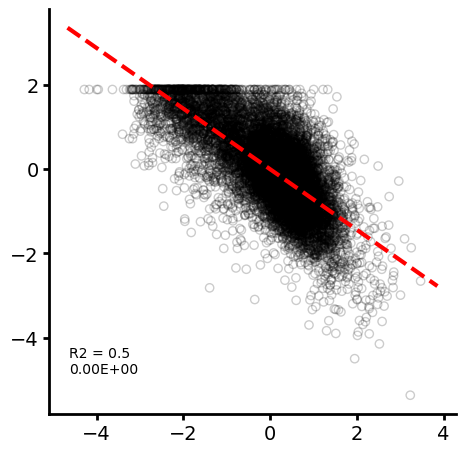

In [198]:
plot_regression(df.chRNA, df.NMD, model.params.loc['chRNA'], r2, model.pvalues.loc['chRNA'])

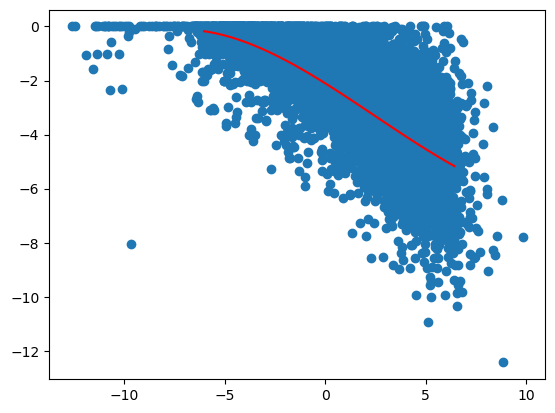

In [219]:
x = NMD_by_gene.RPKM
y = np.log2(NMD_by_gene.PSI)

mymodel = np.poly1d(np.polyfit(x, y, 3))

myline = np.linspace(np.quantile(x, 0.01), np.quantile(x, 0.99), 100)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline), c='red')
plt.show()

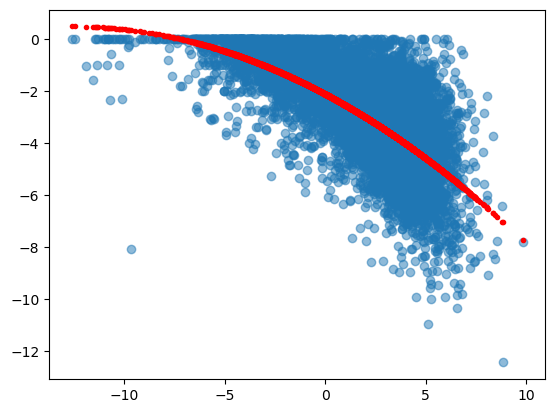

In [250]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

x = NMD_by_gene.RPKM
y = np.log2(NMD_by_gene.PSI)

poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly2.fit_transform(np.array(x).reshape(-1, 1))
# Fit Linear model with poly features
poly_model = LinearRegression().fit(X_poly,np.array(y).reshape(-1, 1))
poly_pred = poly_model.predict(X_poly)
# Plot
plt.scatter(x,y, alpha=0.5)
plt.plot(x, poly_pred, color='red', linestyle='', marker='.', lw=0.1);

In [266]:
resid = np.array(y) - poly_pred.T[0]

In [267]:
NMD_by_gene['resid'] = resid

Text(0, 0.5, 'resid')

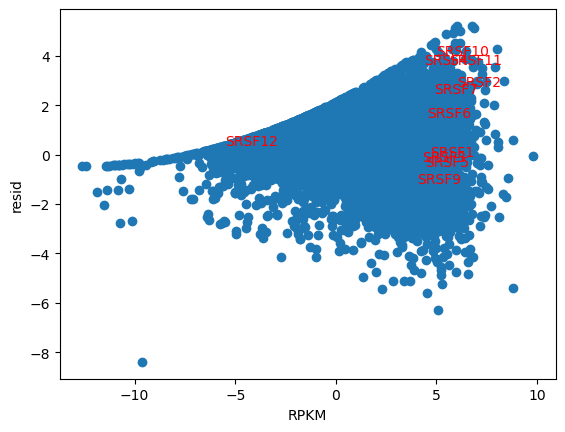

In [281]:
plt.scatter(NMD_by_gene.RPKM, NMD_by_gene.resid)

for idx, row in NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl)].iterrows():
    plt.annotate(row.symbol, (row.RPKM-1, row.resid-0.2), c='red', size=10)

plt.xlabel('RPKM')
plt.ylabel('resid')

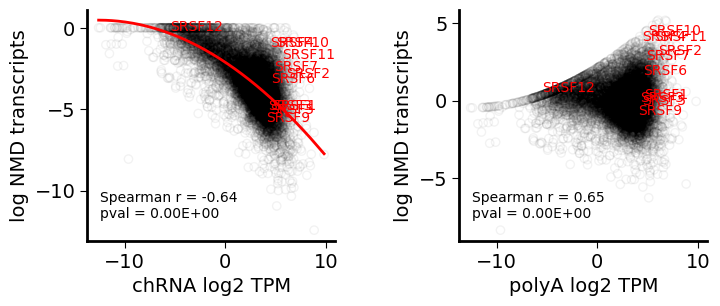

In [294]:

# NMD_by_gene_sr
kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.05}

fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'wspace': 0.5}, figsize=(8, 3))

ax[0].scatter(x,y, **kwargs)
ax[0].plot(sorted(x)[::-1], sorted(poly_pred), color='red', lw=2);
for idx, row in NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl)].iterrows():
    ax[0].annotate(row.symbol, (row.RPKM-1, np.log2(row.PSI)-0.2), c='red', size=10)
    
annotate_pval(NMD_by_gene.RPKM, np.log2(NMD_by_gene.PSI), ax[0], xy = (0.05, 0.1))
    
ax[1].scatter(NMD_by_gene.RPKM, NMD_by_gene.resid, **kwargs)
for idx, row in NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl)].iterrows():
    ax[1].annotate(row.symbol, (row.RPKM-1, row.resid), c='red', size=10)
    
annotate_pval(NMD_by_gene.logpolyA_TPM, np.log2(NMD_by_gene.NMD_transcripts), ax[1], xy = (0.05, 0.1))


for i in range(2):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 TPM', size=14)
ax[0].set_ylabel('log NMD transcripts', size=14)

ax[1].set_xlabel('polyA log2 TPM', size=14)
ax[1].set_ylabel('log NMD transcripts', size=14)


# ax[2].set_xlabel('chRNA log2 TPM', size=14)
# ax[2].set_ylabel('log $s_{het}$', size=16)

# ax[1].set_yticks([])
# ax[2].set_yticks([])

plt.show()

# plt.savefig(figdir + 'supplementary_figures/SRSF_NMD_v_TPM_v_s_het.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'supplementary_figures/SRSF_NMD_v_TPM_v_s_het.png', dpi=300, bbox_inches='tight',)

In [32]:
import gseapy as gp
from gseapy import barplot, dotplot

# top_expressed = filter_by_quartile(dfreg, 'RPKM', quartile='75%')
# top_s = filter_by_quartile(dfreg, 'log_s_het', quartile='75%')
# top_top_ = top_expressed.index.intersection(top_s.index)
# top_nmd_ = filter_by_quartile(dfreg.loc[top_top_], 'NMD', quartile='25%', top=False)

gene_list = list(NMD_by_gene.loc[NMD_by_gene.resid > NMD_by_gene.resid.quantile(0.75)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)


In [ ]:
dotplot(enr2.res2d, title='Important genes NMD Q1\nMSigDB C5 Ontology', cmap='viridis', size=10, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q1_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')
barplot(enr2.res2d,title='title', figsize=(4, 5), color='darkred')
# plt.savefig(figdir + 'supplementary_figures/NMD_Q1_MSigDB_C5_pvals.pdf', dpi=300, bbox_inches='tight')

In [216]:
transcription_factors

-1.801837236323671

In [311]:
# with open('../../GOMF_DNA_BINDING_TRANSCRIPTION_FACTOR_ACTIVITY.txt') as fh:
#     transcription_factors = [x.rstrip() for x in fh.readlines()[2:]]
    
# with open('../../GOMF_RNA_BINDING.txt') as fh:
#     RNA_binding = [x.rstrip() for x in fh.readlines()[2:]]
    
# with open('../../GOMF_KINASE_ACTIVITY.txt') as fh:
#     kinases = [x.rstrip() for x in fh.readlines()[2:]]

In [216]:
transcription_factors = []
splicing_factors = []
kinases = []
histone_activity = []
with open('../../c5.go.bp.v2023.1.Hs.symbols.gmt') as fh:
    for line in fh:
        line = line.rstrip().split('\t')
        if ('TRANSCRIPTION_FACTOR' in line[0]) or ('TRANSCRIPTION_INITIATION' in line[0]) or ('TRANSCRIPTION_ELONGATION' in line[0]):
            transcription_factors.extend(line[2:])
        elif ('SPLICING' in line[0]) or ('SPLICE_SITE' in line[0]):
            splicing_factors.extend(line[2:])
        elif (('HISTONE' in line[0]) or ('_CHROMATIN_ORGANIZATION' in line[0]) or ('_CHROMATIN_REMODELING' in line[0])):
            histone_activity.extend(line[2:])
        elif ('KINASE_ACTIVITY' in line[0]):
            kinases.extend(line[2:])
        
            
transcription_factors = sorted(set(transcription_factors))
splicing_factors = sorted(set(splicing_factors))
kinases = sorted(set(kinases))
histone_activity = sorted(set(histone_activity))

In [424]:
annotation = []
for gene in NMD_by_gene.symbol:
    if gene in transcription_factors:
        annotation.append('Transcription factors')
    elif gene in splicing_factors:
        annotation.append('Splicing Factors')
    elif gene in kinases:
        annotation.append('Kinases')
    elif gene in kinases:
        annotation.append('Kinases')
    elif gene in histone_activity:
        annotation.append('Histone activity')
    else:
        annotation.append('Other')
        
NMD_by_gene['annotation'] = annotation

In [425]:
np.linspace(0.1, 1, 10)

def get_slice(df, i, step=0.1):
    qi = df.resid.quantile(i)
    qi0 = df.resid.quantile(i-step)
    df_counts = df.loc[(df.resid <= qi) & (df.resid >= qi0)]['annotation'].value_counts()
    df_frac = pd.DataFrame(df_counts/df_counts.sum()).T
    df_frac.index = ['Q' + str(int((i/step)))]
    return df_frac

In [432]:
df = pd.concat([get_slice(NMD_by_gene, i, 0.1) for i in np.linspace(0.1, 1, 10)], axis=0)

Text(0.5, 1.0, 'all genes')

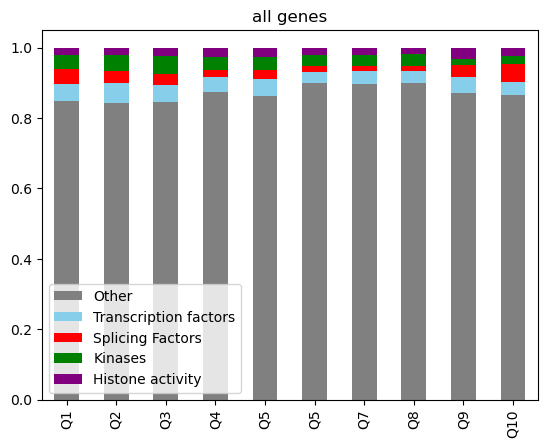

In [434]:
df.plot(kind='bar', stacked=True, color=['grey', 'skyblue', 'red', 'green', 'purple'])
plt.title('all genes')

Text(0.5, 1.0, 'Top 25% $S_{het}$, top 25% RPKM genes')

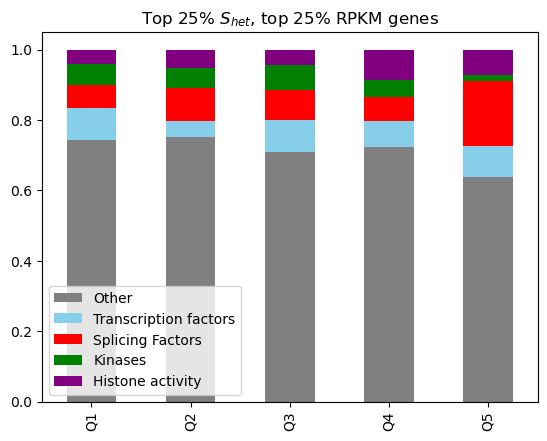

In [442]:
top_genes = NMD_by_gene.loc[
    (NMD_by_gene.post_mean>NMD_by_gene.post_mean.quantile(0.75)) & (NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75))]

df = pd.concat([get_slice(top_genes, i, 0.2) for i in np.linspace(0.2, 1, 5)], axis=0)
df.plot(kind='bar', stacked=True, color=['grey', 'skyblue', 'red', 'green', 'purple'])
plt.title(r'Top 25% $S_{het}$, top 25% RPKM genes')

Text(0.5, 1.0, 'Top 25% RPKM genes')

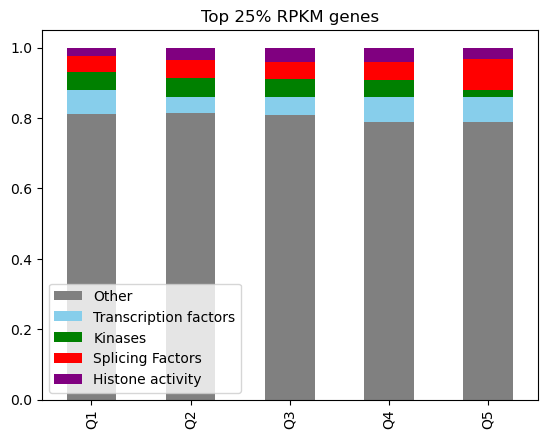

In [445]:
top_genes = NMD_by_gene.loc[
    (NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75))]

df = pd.concat([get_slice(top_genes, i, 0.2) for i in np.linspace(0.2, 1, 5)], axis=0)
df.plot(kind='bar', stacked=True, color=['grey', 'skyblue', 'green', 'red', 'purple'])
plt.title(r'Top 25% RPKM genes')

Text(0.5, 1.0, 'all genes')

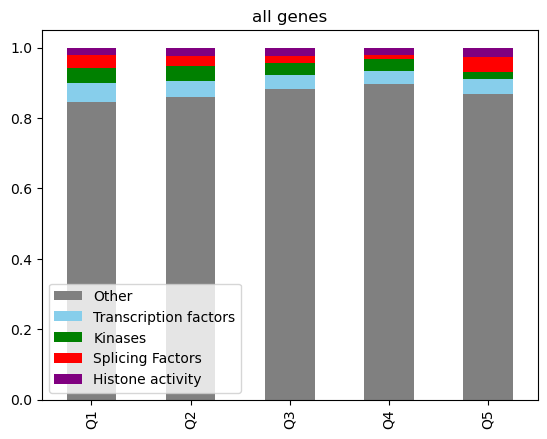

In [446]:
top_genes = NMD_by_gene

df = pd.concat([get_slice(top_genes, i, 0.2) for i in np.linspace(0.2, 1, 5)], axis=0)
df.plot(kind='bar', stacked=True, color=['grey', 'skyblue', 'green', 'red', 'purple'])
plt.title(r'all genes')

In [403]:
[x for x in transcription_factors if x in RNA_binding]

['CDC5L',
 'DLX2',
 'ENO1',
 'GPBP1',
 'HBP1',
 'HDGF',
 'HOXB6',
 'JUN',
 'LRRFIP1',
 'MAZ',
 'MECP2',
 'NFX1',
 'NKRF',
 'NR3C1',
 'PAX6',
 'PCBP1',
 'PCBP3',
 'POU1F1',
 'POU5F1',
 'PURA',
 'PURB',
 'PURG',
 'RARA',
 'SMAD1',
 'SOX2',
 'SOX4',
 'SOX9',
 'SPI1',
 'SRF',
 'STAT3',
 'TP53',
 'WT1',
 'YY1',
 'ZBED4',
 'ZC3H8',
 'ZNF239',
 'ZNF579']

In [410]:
NMD_by_gene.loc[[x[:4]=='SRSF' for x in NMD_by_gene.symbol]]

gene  symbol       PSI      RPKM        hgnc  chrom  \
1714   ENSG00000100650   SRSF5  0.029484  5.418160  HGNC:10787  chr14   
2784   ENSG00000111786   SRSF9  0.021375  5.027585  HGNC:10791  chr12   
2818   ENSG00000112081   SRSF3  0.035381  5.288809  HGNC:10785   chr6   
3169   ENSG00000115875   SRSF7  0.184946  5.885160  HGNC:10789   chr2   
3226   ENSG00000116350   SRSF4  0.510905  5.409326  HGNC:10786   chr1   
3270   ENSG00000116754  SRSF11  0.303682  6.631781  HGNC:10782   chr1   
3846   ENSG00000124193   SRSF6  0.109299  5.514852  HGNC:10788  chr20   
5010   ENSG00000136450   SRSF1  0.035131  5.674698  HGNC:10780  chr17   
6641   ENSG00000154548  SRSF12  1.000000 -4.519388  HGNC:21220   chr6   
7189   ENSG00000161547   SRSF2  0.138417  7.023083  HGNC:10783  chr17   
10075  ENSG00000188529  SRSF10  0.521754  5.994412  HGNC:16713   chr1   

       obs_lof  exp_lof  prior_mean  post_mean  ...  post_upper_95  \
1714       3.0  16.9510    0.324941   0.210584  ...       0.461476   
2784       2.0  11.9080    0.268451   0.234189  ...       0.629830   
2818       0.0  10.2870    0.636952   0.708122  ...       0.980213   
3169       2.0  21.0670    0.554179   0.405139  ...       0.811429   
3226       4.0  24.2060    0.464432   0.274350  ...       0.558216   
3270       2.0  27.0630    0.438709   0.521930  ...       0.860099   
3846       3.0  20.9980    0.255916   0.171838  ...       0.339115   
5010       0.0  12.3510    0.547772   0.628204  ...       0.956862   
6641       5.0  14.5960    0.044140   0.033455  ...       0.064501   
7189       1.0   5.8429    0.434142   0.112394  ...       0.330324   
10075      0.0   1.2572    0.087238   0.087512  ...       0.337899   

       polyA_RPKM          TPM     logTPM  NMD_transcripts   polyA_TPM  \
1714     5.497525   332.513150   8.377268         9.803716  127.025436   
2784     4.966469   225.000812   7.813786         4.809294   74.688887   
2818     5.977743   292.167772   8.190653        10.337215  205.327323   
3169     5.780163   530.425453   9.051006        98.100308  168.515154   
3226     4.590453   329.588647   8.364523       168.388495   51.280741   
3270     4.902189  1119.123106  10.128153       339.857083   70.038970   
3846     4.811825   366.270404   8.516765        40.033017   63.987524   
5010     5.020580   429.755889   8.747374        15.097865   78.841756   
6641    -4.265305     0.016069  -5.959583         0.016069    0.007311   
7189     6.475220  1655.077136  10.692683       229.091267  337.674757   
10075    4.322391   591.659842   9.208624       308.701109   39.222632   

       logpolyA_TPM  gene_len     resid        annotation  
1714       6.988974     45106 -0.247369  Splicing Factors  
2784       6.222822      8077 -0.939009  Splicing Factors  
2818       7.681782     11248 -0.060243  Splicing Factors  
3169       7.396735      7896  2.680455  Splicing Factors  
3226       5.680345     34158  3.862494  Splicing Factors  
3270       6.130086     47371  3.856307  Splicing Factors  
3846       5.999719      8154  1.700044  Splicing Factors  
5010       6.300888      6428  0.157688  Splicing Factors  
6641      -7.095813     22113  0.596683  Splicing Factors  
7189       8.399491      3219  2.971348  Splicing Factors  
10075      5.293614     16581  4.242949  Splicing Factors  

[11 rows x 21 columns]

In [ ]:
NMD_by_gene.plot(kind='bar', stacked=True, color=['red', 'skyblue', 'green'])

<Axes: xlabel='annotation', ylabel='resid'>

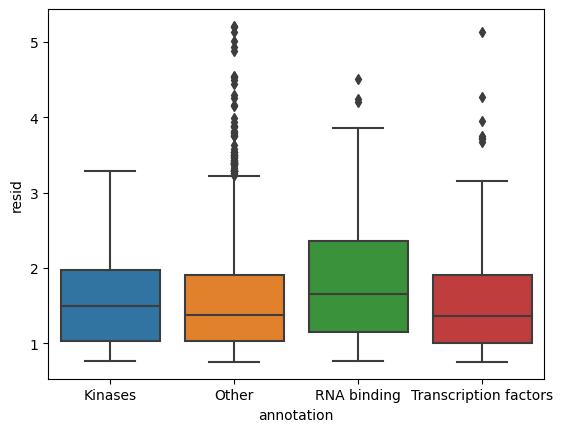

In [322]:
sns.boxplot(data = NMD_by_gene.loc[NMD_by_gene.resid > NMD_by_gene.resid.quantile(0.75)], x='annotation', y='resid')

In [316]:
srsf

['SRSF0',
 'SRSF1',
 'SRSF2',
 'SRSF3',
 'SRSF4',
 'SRSF5',
 'SRSF6',
 'SRSF7',
 'SRSF8',
 'SRSF9',
 'SRSF10',
 'SRSF11',
 'SRSF12']

In [ ]:
plt.scatter(np.log10(long_table_sum.loc[long_table_sum.SuperAnnotation.isin(NMD)].gene_total),
            long_table_sum.loc[long_table_sum.SuperAnnotation.isin(NMD)].PSI)

In [ ]:
plt.plot(np.linspace(0, 1, 1000),
         get_csum(long_table_sum.PSI, 0, 1, 1000))

In [ ]:
# gtf_df.gene_id = [x.split('.')[0] for x in gtf_df.gene_id]


In [361]:
bed = pd.read_csv('../code/genes.bed', sep='\t', 
                 names = ['chrom', 'start', 'end', 'gene', 'symbol', 'strand'])
bed['gene'] = [x.split('.')[0] for x in bed.gene]
# bed['symbol'] = [x.split(',')[0] for x in bed.symbol]
# bed['strand'] = [x.split(',')[0] for x in bed.strand]

In [362]:
bed['exon_count'] = [1]*bed.shape[0]

In [363]:
gene_exons = bed.groupby(['gene', 'symbol']).exon_count.sum().reset_index()

In [364]:
gene_exons.gene.isin(expressed_genes.gene).sum()

9756

In [365]:
long_table = long_table.merge(gene_exons, left_on=['gene', 'symbol'], right_on=['gene', 'symbol'])

In [366]:
long_table = long_table.loc[long_table.gene.isin(expressed_genes.gene)]

In [367]:
gene_total = long_table.groupby('gene').Count.sum().reset_index()
gene_total.columns = ['gene', 'gene_total']
gene_NMD_sum = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby('gene').Count.sum().reset_index()
gene_NMD_sum.columns = ['gene', 'gene_NMD']


In [368]:
gene_total = gene_total.merge(gene_NMD_sum, left_on='gene', right_on='gene')
gene_total['PSI'] = gene_total.gene_NMD/gene_total.gene_total
gene_total = gene_total.merge(gene_exons, left_on='gene', right_on = 'gene')
gene_total['intron_count'] = gene_total.exon_count - 1

In [369]:
gene_total['percent_NMD'] = (1 - ((1 - gene_total.PSI)**(gene_total.exon_count)))

In [370]:
len(long_table.gene.unique())

9342

In [8]:
RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)
RPKM.index = [x.split('.')[0] for x in RPKM.index]

# log2RPKM = RPKM[RPKM.columns.intersection(pd.Index(long_table.IndID.unique()))].median(axis=1).reset_index()
# log2RPKM.columns = ['gene', 'RPKM']

In [373]:
gene_total = gene_total.merge(log2RPKM, left_on='gene', right_on = 'gene')

Text(0, 0.5, 'Estimated % NMD transcripts')

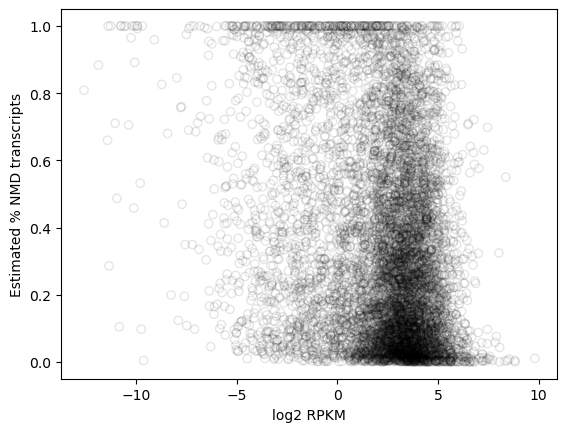

In [374]:
plt.scatter(gene_total.RPKM, gene_total.percent_NMD, edgecolor='black', facecolor='none', alpha=0.1)
plt.xlabel('log2 RPKM')
plt.ylabel('Estimated % NMD transcripts')

Text(0, 0.5, 'Estimated % NMD transcripts')

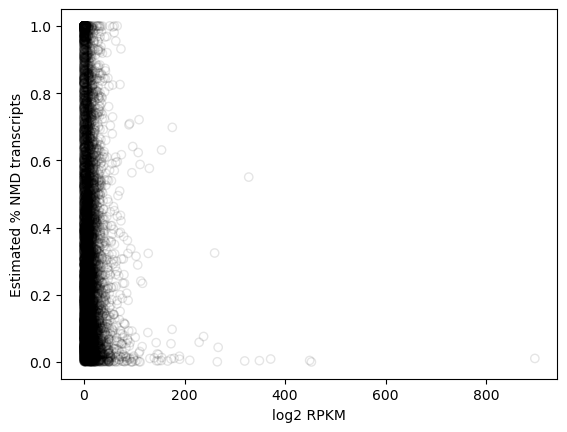

In [375]:
plt.scatter(2**gene_total.RPKM, gene_total.percent_NMD, edgecolor='black', facecolor='none', alpha=0.1)
plt.xlabel('log2 RPKM')
plt.ylabel('Estimated % NMD transcripts')

In [376]:
from scipy.stats import pearsonr, spearmanr

In [377]:
spearmanr(gene_total.RPKM, gene_total.percent_NMD)

SignificanceResult(statistic=-0.21255616879362615, pvalue=6.723827925617616e-81)

In [378]:
log2RPKM = log2RPKM.set_index('gene')

In [379]:
Q1_ = log2RPKM.RPKM.quantile(0.25)
Q2_ = log2RPKM.RPKM.quantile(0.5)
Q3_ = log2RPKM.RPKM.quantile(0.75)

Q1 = log2RPKM.loc[log2RPKM.RPKM < Q1_].index
Q2 = log2RPKM.loc[(log2RPKM.RPKM >= Q1_) & (log2RPKM.RPKM < Q2_)].index
Q3 = log2RPKM.loc[(log2RPKM.RPKM >= Q2_) & (log2RPKM.RPKM < Q3_)].index
Q4 = log2RPKM.loc[log2RPKM.RPKM >= Q3_].index


In [380]:
contribution_NMD_Q1 = [long_table_sum_NMD.loc[(long_table_sum_NMD.PSI <= y) & (long_table_sum.gene.isin(Q1))
                                             ].Count.sum() for y in x]

contribution_NMD_Q2 = [long_table_sum_NMD.loc[(long_table_sum_NMD.PSI <= y) & (long_table_sum.gene.isin(Q2))
                                             ].Count.sum() for y in x]

contribution_NMD_Q3 = [long_table_sum_NMD.loc[(long_table_sum_NMD.PSI <= y) & (long_table_sum.gene.isin(Q3))
                                             ].Count.sum() for y in x]

contribution_NMD_Q4 = [long_table_sum_NMD.loc[(long_table_sum_NMD.PSI <= y) & (long_table_sum.gene.isin(Q4))
                                             ].Count.sum() for y in x]



plt.plot(x, 100*np.array(contribution_NMD_Q1)/np.max(contribution_NMD_Q1), label='NMD junctions')
plt.plot(x, 100*np.array(contribution_NMD_Q2)/np.max(contribution_NMD_Q2), label='NMD junctions')
plt.plot(x, 100*np.array(contribution_NMD_Q3)/np.max(contribution_NMD_Q3), label='NMD junctions')
plt.plot(x, 100*np.array(contribution_NMD_Q4)/np.max(contribution_NMD_Q4), label='NMD junctions')

plt.plot([0.1, 0.1], [0, 100], linestyle='--', c='gray')
plt.xlabel('PSI (reads/reads in max junction)')
plt.ylabel('CDF')
plt.legend(frameon=False)

KeyboardInterrupt: 

In [ ]:
x = np.linspace(0, 1, 101)

In [9]:
from tqdm import tqdm

In [381]:
contribution_NMD_Q1 = [long_table_sum_NMD.loc[(long_table_sum_NMD.PSI <= y) & (long_table_sum_NMD.gene.isin(Q1))
                                             ].Count.sum() for y in tqdm(x)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:03<00:00, 279.05it/s]


In [382]:
contribution_NMD_Q2 = [long_table_sum_NMD.loc[(long_table_sum_NMD.PSI <= y) & (long_table_sum_NMD.gene.isin(Q2))
                                             ].Count.sum() for y in tqdm(x)]

contribution_NMD_Q3 = [long_table_sum_NMD.loc[(long_table_sum_NMD.PSI <= y) & (long_table_sum_NMD.gene.isin(Q3))
                                             ].Count.sum() for y in tqdm(x)]

contribution_NMD_Q4 = [long_table_sum_NMD.loc[(long_table_sum_NMD.PSI <= y) & (long_table_sum_NMD.gene.isin(Q4))
                                             ].Count.sum() for y in tqdm(x)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:04<00:00, 221.52it/s]


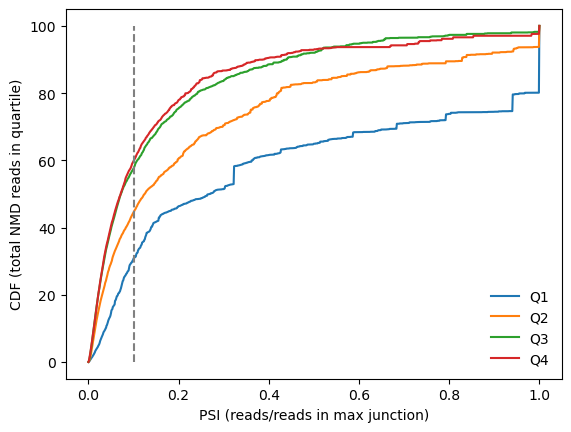

In [383]:
plt.plot(x, 100*np.array(contribution_NMD_Q1)/np.max(contribution_NMD_Q1), label='Q1')
plt.plot(x, 100*np.array(contribution_NMD_Q2)/np.max(contribution_NMD_Q2), label='Q2')
plt.plot(x, 100*np.array(contribution_NMD_Q3)/np.max(contribution_NMD_Q3), label='Q3')
plt.plot(x, 100*np.array(contribution_NMD_Q4)/np.max(contribution_NMD_Q4), label='Q4')
plt.plot([0.1, 0.1], [0, 100], linestyle='--', c='gray')
plt.xlabel('PSI (reads/reads in max junction)')
plt.ylabel('CDF (total NMD reads in quartile)')
plt.legend(frameon=False)

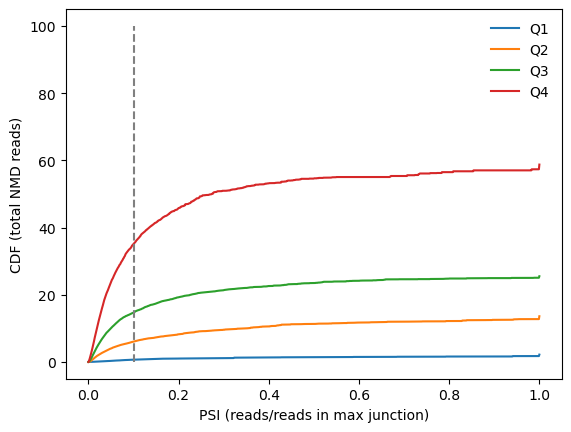

In [384]:
plt.plot(x, 100*np.array(contribution_NMD_Q1)/np.max(contribution_NMD), label='Q1')
plt.plot(x, 100*np.array(contribution_NMD_Q2)/np.max(contribution_NMD), label='Q2')
plt.plot(x, 100*np.array(contribution_NMD_Q3)/np.max(contribution_NMD), label='Q3')
plt.plot(x, 100*np.array(contribution_NMD_Q4)/np.max(contribution_NMD), label='Q4')
plt.plot([0.1, 0.1], [0, 100], linestyle='--', c='gray')
plt.xlabel('PSI (reads/reads in max junction)')
plt.ylabel('CDF (total NMD reads)')
plt.legend(frameon=False)

In [385]:
contribution_NMD_Q1 = [long_table_sum_NMD.loc[(long_table_sum_NMD.PSI <= y) & (long_table_sum_NMD.gene.isin(Q1))
                                             ].shape[0] for y in tqdm(x)]

contribution_NMD_Q2 = [long_table_sum_NMD.loc[(long_table_sum_NMD.PSI <= y) & (long_table_sum_NMD.gene.isin(Q2))
                                             ].shape[0] for y in tqdm(x)]

contribution_NMD_Q3 = [long_table_sum_NMD.loc[(long_table_sum_NMD.PSI <= y) & (long_table_sum_NMD.gene.isin(Q3))
                                             ].shape[0] for y in tqdm(x)]

contribution_NMD_Q4 = [long_table_sum_NMD.loc[(long_table_sum_NMD.PSI <= y) & (long_table_sum_NMD.gene.isin(Q4))
                                             ].shape[0] for y in tqdm(x)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:04<00:00, 234.55it/s]


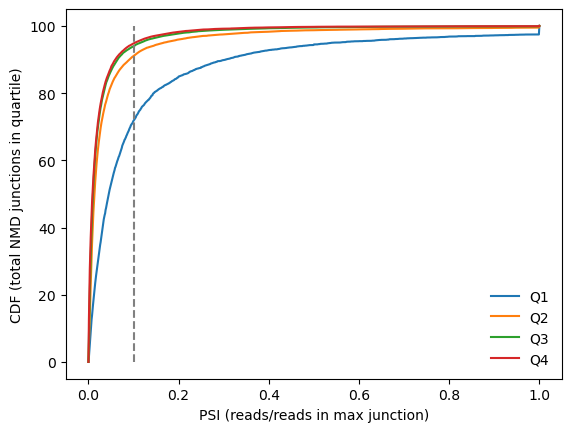

In [386]:
plt.plot(x, 100*np.array(contribution_NMD_Q1)/long_table_sum_NMD.loc[(long_table_sum_NMD.gene.isin(Q1))].shape[0], label='Q1')
plt.plot(x, 100*np.array(contribution_NMD_Q2)/long_table_sum_NMD.loc[(long_table_sum_NMD.gene.isin(Q2))].shape[0], label='Q2')
plt.plot(x, 100*np.array(contribution_NMD_Q3)/long_table_sum_NMD.loc[(long_table_sum_NMD.gene.isin(Q3))].shape[0], label='Q3')
plt.plot(x, 100*np.array(contribution_NMD_Q4)/long_table_sum_NMD.loc[(long_table_sum_NMD.gene.isin(Q4))].shape[0], label='Q4')
plt.plot([0.1, 0.1], [0, 100], linestyle='--', c='gray')
plt.xlabel('PSI (reads/reads in max junction)')
plt.ylabel('CDF (total NMD junctions in quartile)')
plt.legend(frameon=False)

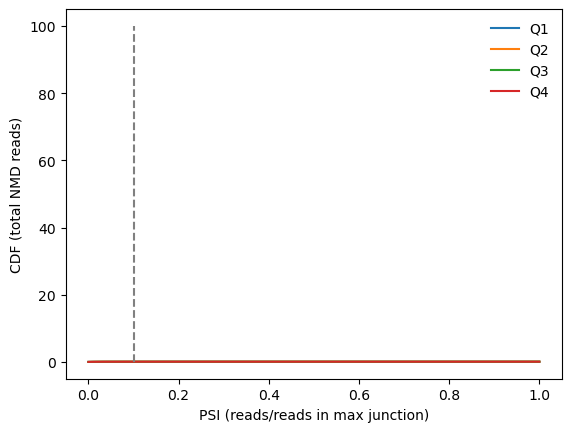

In [387]:
plt.plot(x, 100*np.array(contribution_NMD_Q1)/np.max(contribution_NMD), label='Q1')
plt.plot(x, 100*np.array(contribution_NMD_Q2)/np.max(contribution_NMD), label='Q2')
plt.plot(x, 100*np.array(contribution_NMD_Q3)/np.max(contribution_NMD), label='Q3')
plt.plot(x, 100*np.array(contribution_NMD_Q4)/np.max(contribution_NMD), label='Q4')
plt.plot([0.1, 0.1], [0, 100], linestyle='--', c='gray')
plt.xlabel('PSI (reads/reads in max junction)')
plt.ylabel('CDF (total NMD reads)')
plt.legend(frameon=False)

In [388]:
np.linspace(0.25, 0.75, 3)

array([0.25, 0.5 , 0.75])

In [389]:
Q_list_ = [log2RPKM.RPKM.quantile(i) for i in np.linspace(0.25, 0.75, 3)]

counts = 0
Q_list = [log2RPKM.loc[log2RPKM.RPKM < Q_list_[0]].index]
for i in range(1, 3):
    Q_list.append(log2RPKM.loc[(log2RPKM.RPKM >= Q_list_[i-1]) & (log2RPKM.RPKM < Q_list_[i])].index)

Q_list.append(log2RPKM.loc[log2RPKM.RPKM >= Q_list_[2]].index)


In [390]:
p = []
for i in range(4):
    NMD_counts = long_table.loc[long_table.gene.isin(Q_list[i]) & long_table.SuperAnnotation.isin(NMD)].Count.sum()
    all_counts = long_table.loc[long_table.gene.isin(Q_list[i])].Count.sum()
    p.append(NMD_counts/all_counts)

In [391]:
len(Q_list)

4

In [392]:
long_table.loc[long_table.gene.isin(Q_list[9])].Count.sum()

IndexError: list index out of range

In [ ]:
64058/1122782

Text(0, 0.5, 'Predicted %NMD')

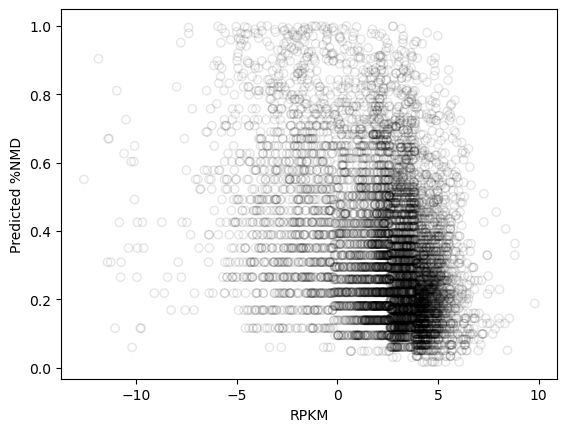

In [393]:
df = pd.DataFrame()
rpkm_ = []
nmd_ = []
q_ = []
genes_ = []
for i in range(4):
    plt.scatter(gene_total.loc[gene_total.gene.isin(Q_list[i])].RPKM,
            1 - ((1-p[i])**gene_total.loc[gene_total.gene.isin(Q_list[i])].exon_count), edgecolor='black', facecolor='none',
               alpha=0.1)
    
    rpkm_.extend(list(gene_total.loc[gene_total.gene.isin(Q_list[i])].RPKM))
    nmd_.extend(list(1 - ((1-p[i])**gene_total.loc[gene_total.gene.isin(Q_list[i])].exon_count)))
    q_.extend(['Q'+str(i+1)]*len(gene_total.loc[gene_total.gene.isin(Q_list[i])].RPKM))
    
    genes_.extend(list(gene_total.loc[gene_total.gene.isin(Q_list[i])].gene))
    
plt.xlabel('RPKM')
plt.ylabel('Predicted %NMD')

In [394]:
df['RPKM'] = rpkm_
df['NMD'] = nmd_
df['quartile'] = q_
df.index = genes_

Text(0, 0.5, 'Predicted %NMD')

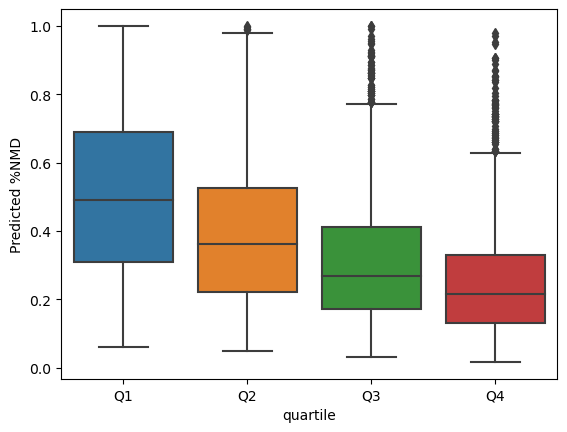

In [395]:
import seaborn as sns
sns.boxplot(data = df, x = 'quartile', y='NMD')
plt.ylabel('Predicted %NMD')

In [396]:
p

[0.059748756359925735,
 0.048686260612188344,
 0.030873036235885776,
 0.017213638484722765]

In [397]:
for i in range(4):
    gene_total.loc[gene_total.gene.isin(Q_list[i])].RPKM,
    1 - ((1-p[i])**gene_total.loc[gene_total.gene.isin(Q_list[i])].exon_count

SyntaxError: unexpected EOF while parsing (2910163011.py, line 3)

In [ ]:
gene_total

In [ ]:
gene_total.loc[gene_total.gene.isin(Q_list[3])].intron_count.median()

In [ ]:
df

In [398]:
df_ = pd.DataFrame(1-((1-gene_total.PSI)**gene_total.exon_count))
df_.index = gene_total.gene
df_.columns = ['NMD_truth']

In [399]:
df

RPKM       NMD quartile
ENSG00000001626 -6.508740  0.810510       Q1
ENSG00000002587 -4.155177  0.115928       Q1
ENSG00000003987 -6.614081  0.577901       Q1
ENSG00000004399 -2.828724  0.891162       Q1
ENSG00000004838 -0.421290  0.522551       Q1
...                   ...       ...      ...
ENSG00000277443  5.623433  0.034131       Q4
ENSG00000277632  6.433262  0.050757       Q4
ENSG00000277791  5.141200  0.098938       Q4
ENSG00000278259  4.750296  0.363297       Q4
ENSG00000278619  3.875707  0.083156       Q4

[7851 rows x 3 columns]

In [400]:
df_NMD = df_.merge(df, left_on='gene', right_index=True)

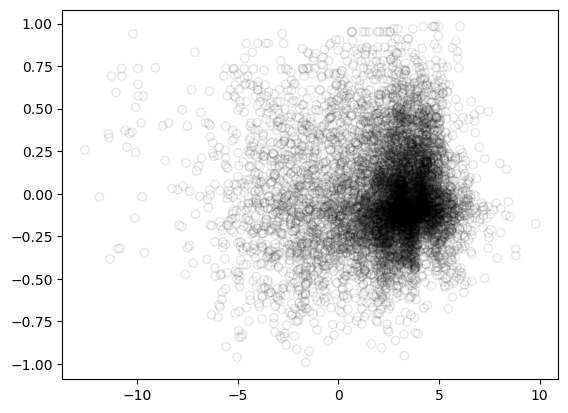

In [401]:
plt.scatter(df_NMD.RPKM, df_NMD.NMD_truth - df_NMD.NMD, edgecolor='black', facecolor='none', alpha=0.1)

In [402]:
genes = pd.read_csv('../../genes.txt', sep='\t', names=['genes'], index_col=0)
genes.index = [x.split('.')[0] for x in genes.index]

srsf = ['SRSF'+str(x) for x in range(13)]
srsf_ensembl = genes.loc[genes.genes.isin(srsf)].index.intersection(df_NMD.index)

In [405]:
srsf_ensembl

srsf_ = ['SRSF4', 'SRSF3', 'SRSF12', 'SRSF8', 'SRSF9', 'SRSF5', 'SRSF1', 'SRSF2']

Text(0, 0.5, 'log % NMD transcripts obs vs predicted')

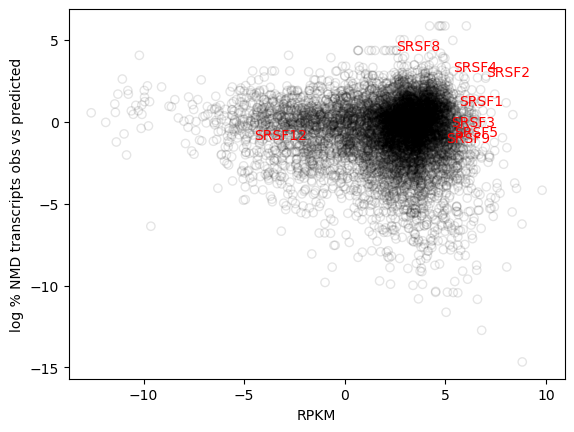

In [424]:
plt.scatter(df_NMD.RPKM, np.log2(df_NMD.NMD_truth) - np.log2(df_NMD.NMD), edgecolor='black', facecolor='none', alpha=0.1)
# plt.scatter(df_NMD.loc[srsf_ensembl].RPKM, np.log2(df_NMD.loc[srsf_ensembl].NMD_truth) - np.log2(df_NMD.loc[srsf_ensembl].NMD), 
#             edgecolor='red', facecolor='none')

for i in range(len(srsf_ensembl)):
    plt.annotate(srsf_[i], (df_NMD.loc[list(srsf_ensembl)[i]].RPKM, 
                   np.log2(df_NMD.loc[list(srsf_ensembl)[i]].NMD_truth) - np.log2(df_NMD.loc[list(srsf_ensembl)[i]].NMD)), 
                   c='red', size=10)
    
plt.xlabel('RPKM')
plt.ylabel('log % NMD transcripts obs vs predicted')

In [416]:
[np.log2(df_NMD.loc[list(srsf_ensembl)[i]].NMD_truth) - np.log2(df_NMD.loc[list(srsf_ensembl)[i]].NMD)]

[3.0923290647696664]

In [ ]:
diff = df_NMD.NMD_truth - df_NMD.NMD

In [ ]:
gene_total.loc[gene_total.gene == 'ENSG00000161547']

In [ ]:
df_NMD.loc['ENSG00000161547']

In [449]:
long_table_NMD.groupby(['gene', 'junction'])

chrom      start       stop strand                    Dataset  \
9737       chr1     944800     945042      -  chRNA.Expression.Splicing   
9741       chr1     945653     946147      -  chRNA.Expression.Splicing   
9753       chr1     954082     954464      -  chRNA.Expression.Splicing   
9754       chr1     954523     955923      -  chRNA.Expression.Splicing   
9760       chr1     944819     945057      -  chRNA.Expression.Splicing   
...         ...        ...        ...    ...                        ...   
15987989  chr10   28236939   28238568      -  chRNA.Expression.Splicing   
15988037  chr15   78593191   78596540      -  chRNA.Expression.Splicing   
15988340   chr6   35137852   35140020      -  chRNA.Expression.Splicing   
15988357   chr8   72039797   72041189      -  chRNA.Expression.Splicing   
15988494   chr3  136079283  136082265      +  chRNA.Expression.Splicing   

            IndID RepNumber  Count        end  \
9737      NA18853    1.junc     36     945042   
9741      NA18853    1.junc      4     946147   
9753      NA18853    1.junc      1     954464   
9754      NA18853    1.junc     45     955923   
9760      NA18853    1.junc      1     945057   
...           ...       ...    ...        ...   
15987989  NA18498    1.junc      3   28238568   
15988037  NA18498    1.junc      4   78596540   
15988340  NA18502    1.junc      1   35140020   
15988357  NA18502    1.junc      5   72041189   
15988494  NA19128    1.junc      2  136082265   

                               NewAnnotation  ...   symbol  \
9737                 retained_intron.gencode  ...    NOC2L   
9741      nonsense_mediated_decay.pstopcodon  ...    NOC2L   
9753           nonsense_mediated_decay.far3p  ...    NOC2L   
9754            processed_transcript.gencode  ...    NOC2L   
9760              nonsense_mediated_decay.YN  ...    NOC2L   
...                                      ...  ...      ...   
15987989        processed_transcript.gencode  ...     MPP7   
15988037        processed_transcript.gencode  ...   CHRNA3   
15988340     nonsense_mediated_decay.gencode  ...    TCP11   
15988357        processed_transcript.gencode  ...    TRPA1   
15988494     nonsense_mediated_decay.gencode  ...  PPP2R3A   

                                 SuperAnnotation  \
9737        AnnotatedJunc_UnproductiveCodingGene   
9741      UnannotatedJunc_UnproductiveCodingGene   
9753      UnannotatedJunc_UnproductiveCodingGene   
9754        AnnotatedJunc_UnproductiveCodingGene   
9760      UnannotatedJunc_UnproductiveCodingGene   
...                                          ...   
15987989    AnnotatedJunc_UnproductiveCodingGene   
15988037    AnnotatedJunc_UnproductiveCodingGene   
15988340    AnnotatedJunc_UnproductiveCodingGene   
15988357    AnnotatedJunc_UnproductiveCodingGene   
15988494    AnnotatedJunc_UnproductiveCodingGene   

                     SemiSupergroupAnnotations                    junction  \
9737              uniquely retained_intron tag        chr1:944800:945042:-   
9741                  predicted_NMD pstopcodon        chr1:945653:946147:-   
9753                       predicted_NMD far3p        chr1:954082:954464:-   
9754         uniquely processed_transcript tag        chr1:954523:955923:-   
9760                          predicted_NMD YN        chr1:944819:945057:-   
...                                        ...                         ...   
15987989     uniquely processed_transcript tag   chr10:28236939:28238568:-   
15988037     uniquely processed_transcript tag   chr15:78593191:78596540:-   
15988340  uniquely nonsense_mediated_decay tag    chr6:35137852:35140020:-   
15988357     uniquely processed_transcript tag    chr8:72039797:72041189:-   
15988494  uniquely nonsense_mediated_decay tag  chr3:136079283:136082265:+   

         gene_total  gene_max  PSI_total       PSI   log2PSI  log2PSI_total  
9737           4149       486   0.008677  0.074074 -3.754888      -6.848623  
9741           4149       486   0.000964  0.008230 -6.924

Text(0, 0.5, 'log2 observed NMD junctions')

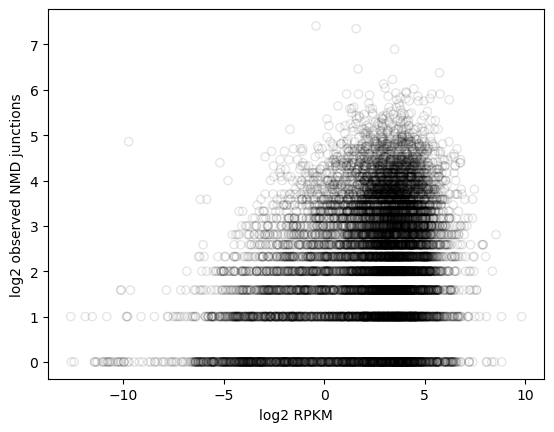

In [487]:
df_ = long_table_NMD.groupby(['gene', 'symbol', 'junction']).Count.sum().reset_index()
df_['junction_count'] = [1]*len(df_)

df_ = pd.DataFrame(df_.groupby('gene').junction_count.sum()).merge(log2RPKM, left_index=True, right_on='gene')

plt.scatter(df_.RPKM, np.log2(df_.junction_count), edgecolor='black', facecolor='none', alpha=0.1)
plt.xlabel('log2 RPKM')
plt.ylabel('log2 observed NMD junctions')

In [482]:
pearsonr(df_.RPKM, np.log2(df_.junction_count))

PearsonRResult(statistic=0.3155012684180917, pvalue=4.2235726143661465e-266)

Text(0, 0.5, 'log2 #NMD junctions')

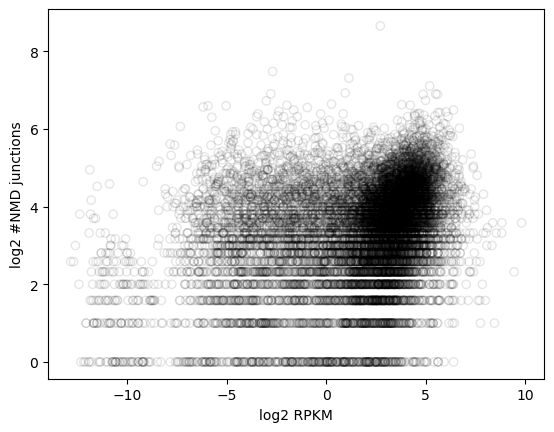

In [476]:
df_ = long_table.loc[long_table.SuperAnnotation.isin(PC)].groupby(['gene', 'symbol', 'junction']).Count.sum().reset_index()
df_['junction_count'] = [1]*len(df_)

df_ = pd.DataFrame(df_.groupby('gene').junction_count.sum()).merge(log2RPKM, left_index=True, right_on='gene')

plt.scatter(df_.RPKM, np.log2(df_.junction_count), edgecolor='black', facecolor='none', alpha=0.1)
plt.xlabel('log2 RPKM')
plt.ylabel('log2 #NMD junctions')

Text(0, 0.5, 'log2 observed PC junctions')

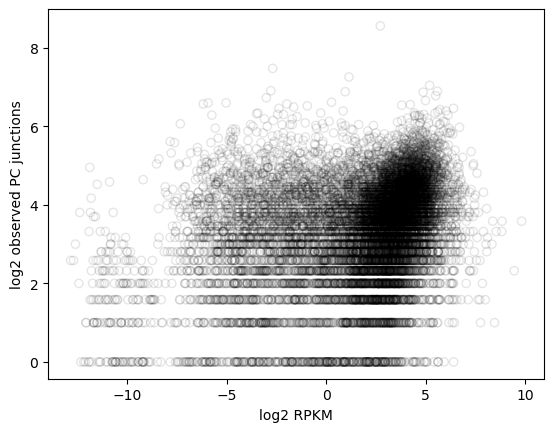

In [486]:
df_ = long_table.loc[long_table.SuperAnnotation == 'AnnotatedJunc_ProductiveCodingGene'].groupby(['gene', 'symbol', 'junction']).Count.sum().reset_index()
df_['junction_count'] = [1]*len(df_)

df_ = pd.DataFrame(df_.groupby('gene').junction_count.sum()).merge(log2RPKM, left_index=True, right_on='gene')

plt.scatter(df_.RPKM, np.log2(df_.junction_count), edgecolor='black', facecolor='none', alpha=0.1)
plt.xlabel('log2 RPKM')
plt.ylabel('log2 observed PC junctions')

In [484]:
spearmanr(df_.RPKM, np.log2(df_.junction_count))

SignificanceResult(statistic=0.2943880174354694, pvalue=1.4283686925848778e-267)

In [516]:
df_ = NMD_by_gene[['gene', 'resid', 'PSI']].merge(df_, left_on='gene', right_on='gene')

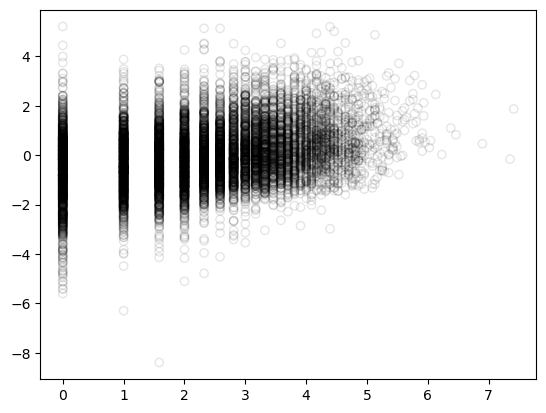

In [497]:
plt.scatter(np.log2(df_.junction_count), df_.resid, edgecolor='black', facecolor='none', alpha=0.1)

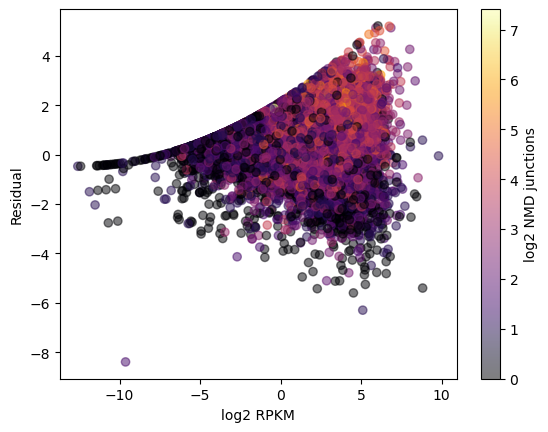

In [511]:
plt.scatter(df_.RPKM, df_.resid, c=np.log2(df_.junction_count), alpha=0.5, cmap='inferno')
plt.xlabel('log2 RPKM')
plt.ylabel('Residual')
cbar = plt.colorbar()
cbar.set_label('log2 NMD junctions')

Text(0.5, 1.0, 'Genes with RPKM > 3')

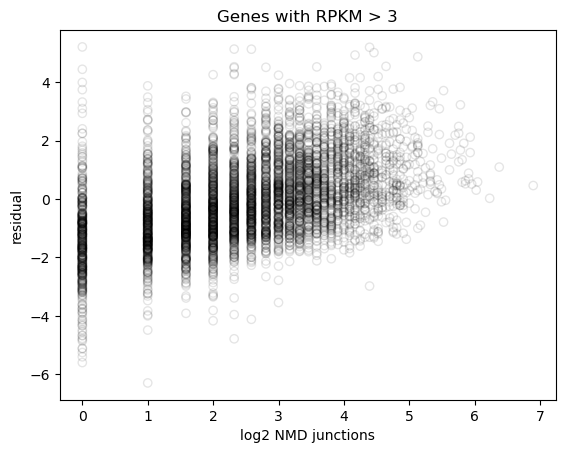

In [513]:
plt.scatter(np.log2(df_.loc[df_.RPKM > 3].junction_count), df_.loc[df_.RPKM > 3].resid, 
            edgecolor='black', facecolor='none', alpha=0.1)

plt.xlabel('log2 NMD junctions')
plt.ylabel('residual')
plt.title('Genes with RPKM > 3')

In [512]:
spearmanr(np.log2(df_.loc[df_.RPKM > 3].junction_count), df_.loc[df_.RPKM > 3].resid)

SignificanceResult(statistic=0.47727178665564013, pvalue=0.0)

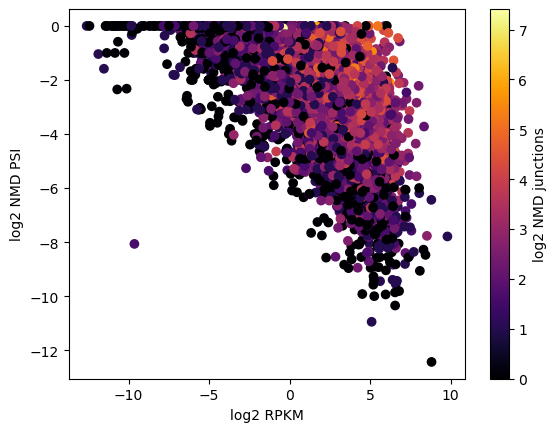

In [525]:
plt.scatter(df_.RPKM, np.log2(df_.PSI), c=np.log2(df_.junction_count), cmap = 'inferno')
plt.xlabel('log2 RPKM')
plt.ylabel('log2 NMD PSI')
cbar = plt.colorbar()
cbar.set_label('log2 NMD junctions')

In [529]:
haplo = pd.read_csv('../../Dataset_S1.txt', sep='\t', skiprows=1, 
                    names = ['chrom', 'start', 'end', 'gene', 'score', 'score_', 'x', 'y', 'z'])

In [537]:
haplo[['gene', 'score_2', 'percent']] = haplo.gene.str.split('|', expand=True)

(array([ 1.,  0.,  3.,  7.,  8.,  8., 19., 93., 72., 10.]),
 array([-9.8050491 , -8.01945663, -6.23386415, -4.44827168, -2.6626792 ,
        -0.87708672,  0.90850575,  2.69409823,  4.47969071,  6.26528318,
         8.05087566]),
 <BarContainer object of 10 artists>)

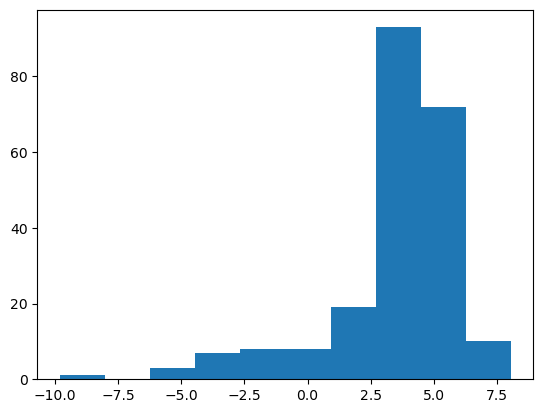

In [561]:
plt.hist(NMD_by_gene.loc[NMD_by_gene.symbol.isin(haplo.loc[haplo.score > 0.95].gene)].RPKM)

(array([  5.,   4.,   6.,  49.,  80., 116., 206., 546., 308.,  30.]),
 array([-11.39809708,  -9.51261607,  -7.62713507,  -5.74165406,
         -3.85617306,  -1.97069205,  -0.08521105,   1.80026996,
          3.68575096,   5.57123197,   7.45671297]),
 <BarContainer object of 10 artists>)

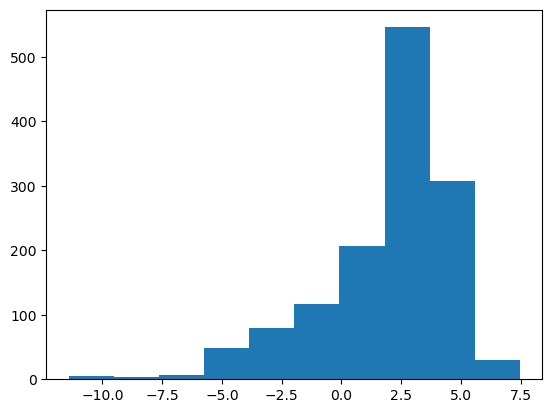

In [563]:
plt.hist(NMD_by_gene.loc[NMD_by_gene.symbol.isin(haplo.loc[haplo.score < 0.2].gene)].RPKM)

In [566]:
NMD_by_gene

gene      symbol       PSI      RPKM        hgnc  chrom  \
0      ENSG00000000419        DPM1  0.027426  4.956947   HGNC:3005  chr20   
1      ENSG00000000457       SCYL3  0.067388  2.778199  HGNC:19285   chr1   
2      ENSG00000000460    C1orf112  0.116244  3.658522  HGNC:25565   chr1   
3      ENSG00000000938         FGR  0.117739  5.817197   HGNC:3697   chr1   
4      ENSG00000001036       FUCA2  0.051398  3.147563   HGNC:4008   chr6   
...                ...         ...       ...       ...         ...    ...   
11323  ENSG00000280789       PAGR1  0.036527  2.398451  HGNC:28707  chr16   
11324  ENSG00000282988  AL031777.2  0.833333  1.041698   HGNC:4767   chr6   
11325  ENSG00000284024  AC069544.1  0.391197  3.488467  HGNC:29526  chr10   
11326  ENSG00000284770        TBCE  0.083500  1.276375  HGNC:11582   chr1   
11327  ENSG00000285077   ARHGAP11B  0.236842  3.378652  HGNC:15782  chr15   

       obs_lof  exp_lof  prior_mean  post_mean  ...  post_upper_95  \
0          9.0  17.9800    0.015030   0.017280  ...       0.038134   
1          8.0  34.3200    0.009598   0.026510  ...       0.048808   
2         23.0  44.6360    0.003274   0.001609  ...       0.004741   
3          6.0  27.8370    0.033294   0.043014  ...       0.075332   
4         14.0  24.2610    0.001359   0.000902  ...       0.003496   
...        ...      ...         ...        ...  ...            ...   
11323      1.0   8.8160    0.028018   0.165779  ...       0.531561   
11324      4.0   3.4746    0.020204   0.002177  ...       0.009345   
11325      6.0  29.9440    0.039154   0.052411  ...       0.090981   
11326     18.0  33.1770    0.004361   0.004579  ...       0.013568   
11327      9.0   9.9439    0.000638   0.000636  ...       0.002476   

       polyA_RPKM         TPM    logTPM  NMD_transcripts   polyA_TPM  \
0        5.405040  209.655724  7.711878         5.749967  115.804405   
1        1.669527   23.729487  4.568609         1.599087    2.763200   
2        2.305371   57.227908  5.838647         6.652386    5.218624   
3        5.366448  495.573895  8.952956        58.348329  111.420481   
4        3.592610   34.332157  5.101489         1.764588   18.905879   
...           ...         ...       ...              ...         ...   
11323    1.335603   16.231774  4.020749         0.592890    1.978750   
11324   -1.776438    4.179607  2.063367         3.483006    0.088074   
11325    3.047649   48.278486  5.593309        18.886409   10.962839   
11326   -3.426359    5.285114  2.401934         0.441305    0.016916   
11327   -0.757719   43.257524  5.434879        10.245188    0.243934   

       logpolyA_TPM  gene_len     resid        annotation  
0          6.855546     23689 -0.620005             Other  
1          1.466340     44637 -0.496185             Other  
2          2.383669    192074  0.745717             Other  
3          6.799871     23122  1.987935           Kinases  
4          4.240763     16909 -0.699027             Other  
...             ...       ...       ...               ...  
11323      0.984590      6338 -1.568322  Histone activity  
11324     -3.505137      3699  2.308306             Other  
11325      3.454550      8859  2.406530             Other  
11326     -5.885469     85084 -0.905175             Other  
11327     -2.035436     25036  1.624986             Other  

[11328 rows x 21 columns]

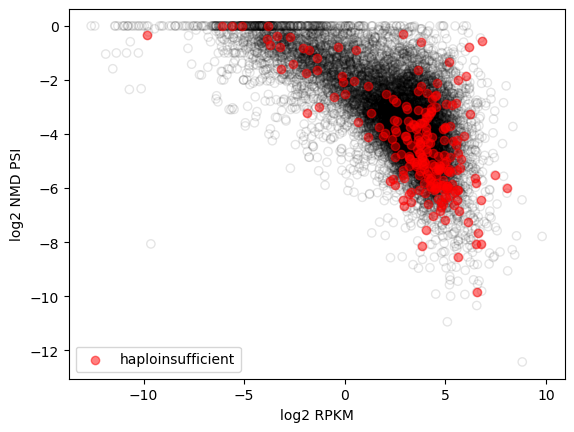

In [573]:
plt.scatter(NMD_by_gene.RPKM, np.log2(NMD_by_gene.PSI), edgecolor='black', facecolor='none', alpha=0.1)
plt.scatter(NMD_by_gene.loc[NMD_by_gene.symbol.isin(haplo.loc[haplo.score > 0.95].gene)].RPKM, 
            np.log2(NMD_by_gene.loc[NMD_by_gene.symbol.isin(haplo.loc[haplo.score > 0.95].gene)].PSI), 
            edgecolor='red', facecolor='red', alpha=0.5, label='haploinsufficient')
plt.xlabel('log2 RPKM')
plt.ylabel('log2 NMD PSI')
# cbar = plt.colorbar()
cbar.set_label('log2 NMD junctions')
plt.legend()

In [684]:
is_haplo = []
is_haplo_lax = []
for gene in NMD_by_gene.symbol:
    if gene in list(haplo.loc[haplo.score > 0.95].gene):
        is_haplo.append(True)
    else:
        is_haplo.append(False)
    if gene in list(haplo.loc[haplo.score > 0.5].gene):
        is_haplo_lax.append(True)
    else:
        is_haplo_lax.append(False)
        
NMD_by_gene['is_haplo'] = is_haplo

NMD_by_gene['is_haplo_lax'] = is_haplo_lax
NMD_by_gene['log2PSI'] = np.log2(NMD_by_gene.PSI)

Text(0.5, 1.0, 'Top quintile expressed genes')

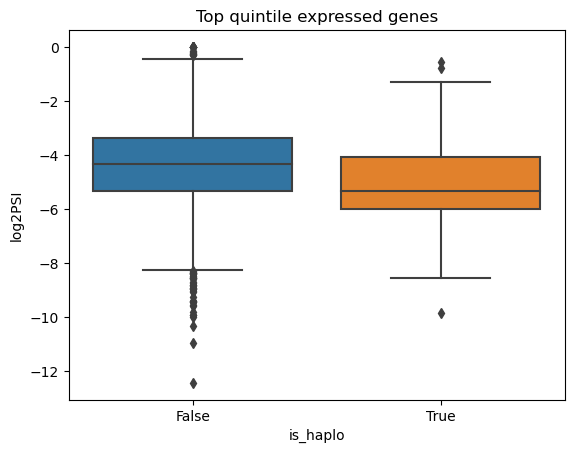

In [685]:
sns.boxplot(data = NMD_by_gene.loc[NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75)], x='is_haplo', y='log2PSI')
plt.title('Top quintile expressed genes')

Text(0.5, 1.0, 'Top quintile expressed genes')

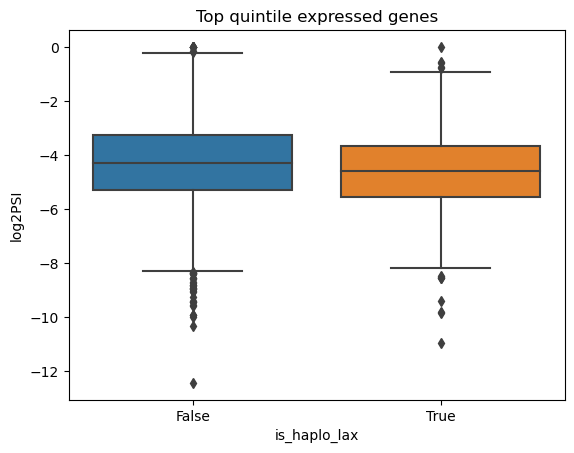

In [686]:
sns.boxplot(data = NMD_by_gene.loc[NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75)], x='is_haplo_lax', y='log2PSI')
plt.title('Top quintile expressed genes')

In [687]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

haplo_x = NMD_by_gene.loc[NMD_by_gene.is_haplo_lax].RPKM
haplo_y = np.log2(NMD_by_gene.loc[NMD_by_gene.is_haplo_lax].PSI)

poly2 = PolynomialFeatures(degree=2, include_bias=False)
haplo_X_poly = poly2.fit_transform(np.array(haplo_x).reshape(-1, 1))
# Fit Linear model with poly features
haplo_poly_model = LinearRegression().fit(haplo_X_poly,np.array(haplo_y).reshape(-1, 1))
haplo_poly_pred = haplo_poly_model.predict(haplo_X_poly)

non_haplo_x = NMD_by_gene.loc[~NMD_by_gene.is_haplo_lax].RPKM
non_haplo_y = np.log2(NMD_by_gene.loc[~NMD_by_gene.is_haplo_lax].PSI)

poly2 = PolynomialFeatures(degree=2, include_bias=False)
non_haplo_X_poly = poly2.fit_transform(np.array(non_haplo_x).reshape(-1, 1))
# Fit Linear model with poly features
non_haplo_poly_model = LinearRegression().fit(non_haplo_X_poly,np.array(non_haplo_y).reshape(-1, 1))
non_haplo_poly_pred = non_haplo_poly_model.predict(non_haplo_X_poly)


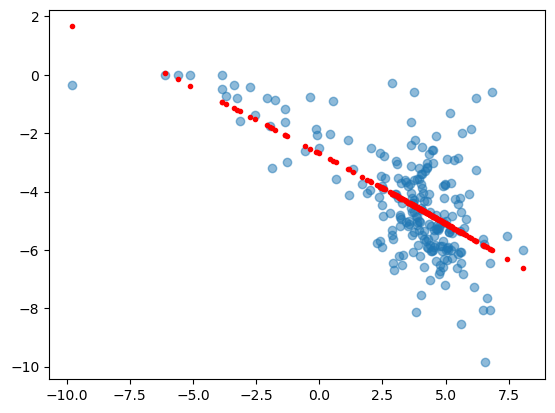

In [626]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

x = NMD_by_gene.loc[NMD_by_gene.is_haplo].RPKM
y = np.log2(NMD_by_gene.loc[NMD_by_gene.is_haplo].PSI)

poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly2.fit_transform(np.array(x).reshape(-1, 1))
# Fit Linear model with poly features
poly_model = LinearRegression().fit(X_poly,np.array(y).reshape(-1, 1))
poly_pred = poly_model.predict(X_poly)
# Plot
plt.scatter(x,y, alpha=0.5)
plt.plot(x, poly_pred, color='red', linestyle='', marker='.', lw=0.1);

In [621]:
pearsonr(haplo_x, haplo_y)

PearsonRResult(statistic=-0.650247171120348, pvalue=6.011343216678587e-28)

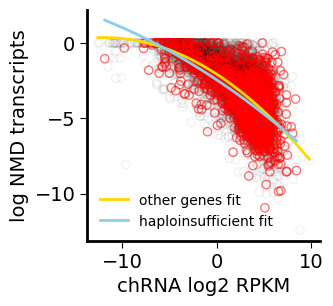

In [688]:

# NMD_by_gene_sr
kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.05}

fig, ax = plt.subplots(nrows=1, ncols=1, gridspec_kw={'wspace': 0.5}, figsize=(3, 3))

x = NMD_by_gene.RPKM
y = np.log2(NMD_by_gene.PSI)

ax.scatter(x,y, **kwargs)
ax.scatter(haplo_x,haplo_y, edgecolor='red', facecolor='none', alpha=0.5)

ax.plot(sorted(non_haplo_x)[::-1], sorted(non_haplo_poly_pred), color='gold', lw=2, label='other genes fit');

ax.plot(sorted(haplo_x)[::-1], sorted(haplo_poly_pred), color='skyblue', lw=2, label='haploinsufficient fit');
# for idx, row in NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl)].iterrows():
#     ax.annotate(row.symbol, (row.RPKM-1, np.log2(row.PSI)-0.2), c='red', size=10)
    
# annotate_pval(NMD_by_gene.RPKM, np.log2(NMD_by_gene.PSI), ax, xy = (0.05, 0.1))
    
# ax[1].scatter(NMD_by_gene.RPKM, NMD_by_gene.resid, **kwargs)
# for idx, row in NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl)].iterrows():
#     ax[1].annotate(row.symbol, (row.RPKM-1, row.resid), c='red', size=10)
    
# annotate_pval(NMD_by_gene.logpolyA_TPM, np.log2(NMD_by_gene.NMD_transcripts), ax[1], xy = (0.05, 0.1))



ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=14)
    
ax.set_xlabel('chRNA log2 RPKM', size=14)
ax.set_ylabel('log NMD transcripts', size=14)

ax.legend(frameon=False)

# ax[1].set_xlabel('polyA log2 TPM', size=14)
# ax[1].set_ylabel('log NMD transcripts', size=14)


# ax[2].set_xlabel('chRNA log2 TPM', size=14)
# ax[2].set_ylabel('log $s_{het}$', size=16)

# ax[1].set_yticks([])
# ax[2].set_yticks([])

plt.show()

# plt.savefig(figdir + 'supplementary_figures/SRSF_NMD_v_TPM_v_s_het.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'supplementary_figures/SRSF_NMD_v_TPM_v_s_het.png', dpi=300, bbox_inches='tight',)

In [652]:
NMD_by_gene.loc[(NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.9)) & NMD_by_gene.is_haplo].PSI.quantile(0.75)

0.054097471826531934

In [653]:
NMD_by_gene.loc[(NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.9)) & (~NMD_by_gene.is_haplo)].PSI.quantile(0.75)

0.09250181492703322

In [640]:
2**NMD_by_gene.loc[(NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75)) & NMD_by_gene.is_haplo].RPKM.median()

29.93615501894174

In [641]:
2**NMD_by_gene.loc[(NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75)) & (~NMD_by_gene.is_haplo)].RPKM.median()

25.811776549451565

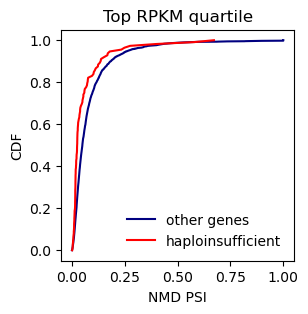

In [670]:
def plot_cdf(x, c='navy', ax=None, label=''):
    x = sorted(x)
    y = np.linspace(0, 1, len(x))
    if not ax:
        plt.plot(x, y, c=c, label=label)
    else:
        ax.plot(x, y, c=c, label=label)
    
fig, ax = plt.subplots(nrows=1, ncols=1, gridspec_kw={'wspace': 0.5}, figsize=(3, 3))


plot_cdf(NMD_by_gene.loc[(NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75)) & (~NMD_by_gene.is_haplo)].PSI.sort_values(), 
         c='navy', label='other genes',
         ax=ax)

plot_cdf(NMD_by_gene.loc[(NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75)) & NMD_by_gene.is_haplo].PSI.sort_values(), 
         c='red', label='haploinsufficient',
         ax=ax)

ax.set_xlabel('NMD PSI')
ax.set_ylabel('CDF')
ax.set_title('Top RPKM quartile')
ax.legend(frameon=False)

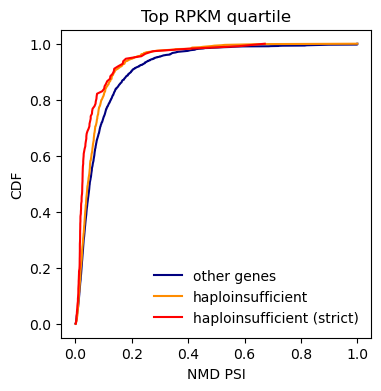

In [696]:
def plot_cdf(x, c='navy', ax=None, label=''):
    x = sorted(x)
    y = np.linspace(0, 1, len(x))
    if not ax:
        plt.plot(x, y, c=c, label=label)
    else:
        ax.plot(x, y, c=c, label=label)
    
fig, ax = plt.subplots(nrows=1, ncols=1, gridspec_kw={'wspace': 0.5}, figsize=(4, 4))


plot_cdf(NMD_by_gene.loc[(NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75)) & (~NMD_by_gene.is_haplo_lax)].PSI.sort_values(), 
         c='navy', label='other genes',
         ax=ax)

plot_cdf(NMD_by_gene.loc[(NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75)) & (NMD_by_gene.is_haplo_lax) & (~NMD_by_gene.is_haplo)].PSI.sort_values(), 
         c='darkorange', label='haploinsufficient',
         ax=ax)

plot_cdf(NMD_by_gene.loc[(NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75)) & NMD_by_gene.is_haplo].PSI.sort_values(), 
         c='red', label='haploinsufficient (strict)',
         ax=ax)



ax.set_xlabel('NMD PSI')
ax.set_ylabel('CDF')
ax.set_title('Top RPKM quartile')
ax.legend(frameon=False, loc='lower right')

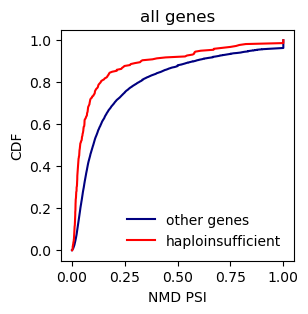

In [671]:
def plot_cdf(x, c='navy', ax=None, label=''):
    x = sorted(x)
    y = np.linspace(0, 1, len(x))
    if not ax:
        plt.plot(x, y, c=c, label=label)
    else:
        ax.plot(x, y, c=c, label=label)
    
fig, ax = plt.subplots(nrows=1, ncols=1, gridspec_kw={'wspace': 0.5}, figsize=(3, 3))


plot_cdf(NMD_by_gene.loc[(~NMD_by_gene.is_haplo)].PSI.sort_values(), 
         c='navy', label='other genes',
         ax=ax)

plot_cdf(NMD_by_gene.loc[NMD_by_gene.is_haplo].PSI.sort_values(), 
         c='red', label='haploinsufficient',
         ax=ax)

ax.set_xlabel('NMD PSI')
ax.set_ylabel('CDF')
ax.set_title('all genes')
ax.legend(frameon=False)

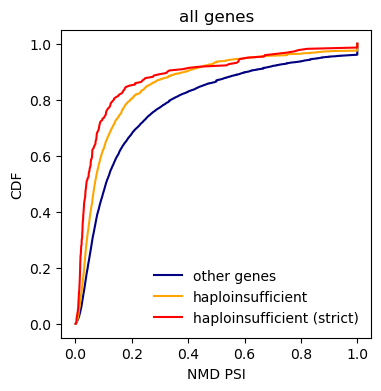

In [699]:
def plot_cdf(x, c='navy', ax=None, label=''):
    x = sorted(x)
    y = np.linspace(0, 1, len(x))
    if not ax:
        plt.plot(x, y, c=c, label=label)
    else:
        ax.plot(x, y, c=c, label=label)
    
fig, ax = plt.subplots(nrows=1, ncols=1, gridspec_kw={'wspace': 0.5}, figsize=(4,4))


plot_cdf(NMD_by_gene.loc[(~NMD_by_gene.is_haplo_lax)].PSI.sort_values(), 
         c='navy', label='other genes',
         ax=ax)

plot_cdf(NMD_by_gene.loc[(NMD_by_gene.is_haplo_lax) & (~NMD_by_gene.is_haplo)].PSI.sort_values(), 
         c='orange', label='haploinsufficient',
         ax=ax)

plot_cdf(NMD_by_gene.loc[NMD_by_gene.is_haplo].PSI.sort_values(), 
         c='red', label='haploinsufficient (strict)',
         ax=ax)

ax.set_xlabel('NMD PSI')
ax.set_ylabel('CDF')
ax.set_title('all genes')
ax.legend(frameon=False)
ax.legend(frameon=False, loc='lower right')

In [709]:
NMD_by_gene.PSI.median()

0.09847984934293683

In [706]:
NMD_by_gene.loc[(NMD_by_gene.is_haplo)].PSI.quantile(0.5)

0.03861800588020831

In [708]:
NMD_by_gene.loc[(NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75)) & (~NMD_by_gene.is_haplo_lax)].PSI.median()

0.050736480118664405

In [703]:
NMD_by_gene.loc[(NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75)) & (NMD_by_gene.is_haplo_lax)].PSI.quantile(0.5)

0.04124060708882201

In [701]:
NMD_by_gene.is_haplo_lax.sum()

2139

In [716]:
(haplo.percent.str.rstrip('%').astype(float) > 99).sum()

114

In [10]:
long_summary = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'junction']).Count.sum().reset_index()


rank_list = []
gene_list = []

count = 0
for gene, df in tqdm(long_summary.groupby('gene')):
    if df.shape[0]==1:
        count += 1
#     if count > 0:
#         break
#     count += 1
    rank_percent = df.sort_values('Count', ascending=False).Count/df.Count.sum()
    
    rank_percent = sorted(rank_percent)[::-1]
    
    rank = []
    for i in range(5):
        if i >= len(rank_percent):
            to_add = 0
        elif i == 4:
            to_add = 1-np.sum(rank_percent[:4])
        else:
            to_add = rank_percent[i]
        
        rank.append(to_add)
    rank_list.append(rank)
    gene_list.append(gene)
        
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11586/11586 [00:06<00:00, 1806.40it/s]


In [11]:
df_rank = pd.DataFrame(rank_list)
df_rank.columns = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']
df_rank.index = gene_list

Text(0.5, 1.0, 'All genes (at least one NMD junction read)')

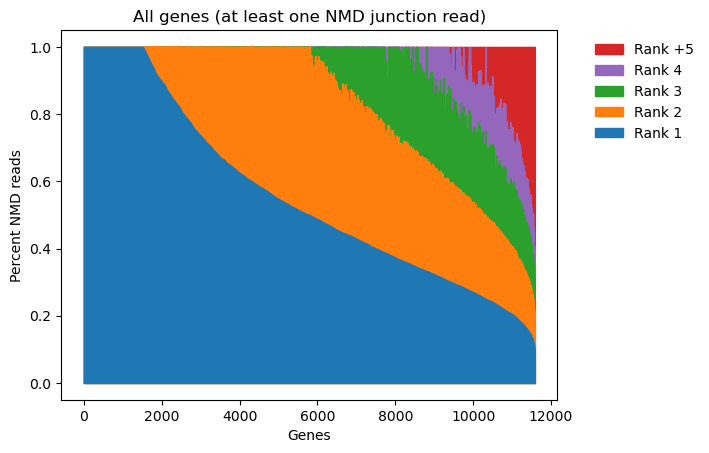

In [12]:
rank1 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 1'])
rank2 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 2'])
rank3 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 3'])
rank4 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 4'])
rank5 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 5+'])
x = range(len(rank1))
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3+rank4+rank5, color='tab:red', label='Rank +5')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3+rank4, color='tab:purple', label='Rank 4')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3, color='tab:green', label='Rank 3')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2, color='tab:orange', label='Rank 2')
plt.fill_between(x,  rank1, color='tab:blue', label='Rank 1')
plt.xlabel('Genes')
plt.ylabel('Percent NMD reads')
plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('All genes (at least one NMD junction read)')

In [159]:
# log2RPKM = log2RPKM.set_index('gene')

Text(0.5, 1.0, 'Top expression quartile (at least one NMD junction read)')

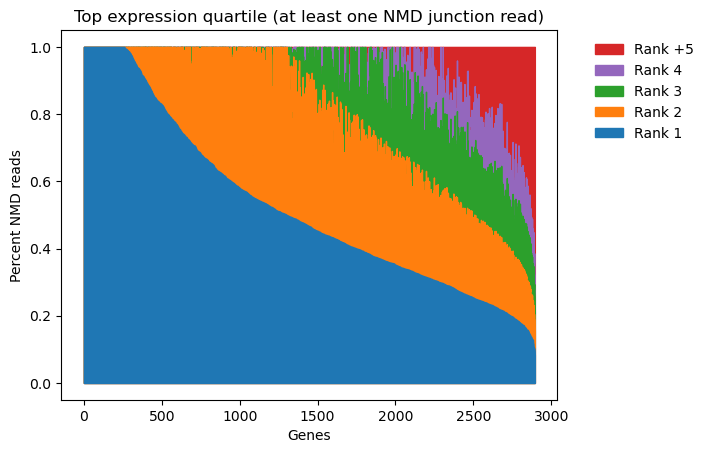

In [161]:
top_quart = log2RPKM.loc[df_rank.index].sort_values('RPKM').index[-int(11586/4):]
rank1 = np.array(df_rank.loc[top_quart].sort_values('Rank 1', ascending=False)['Rank 1'])
rank2 = np.array(df_rank.loc[top_quart].sort_values('Rank 1', ascending=False)['Rank 2'])
rank3 = np.array(df_rank.loc[top_quart].sort_values('Rank 1', ascending=False)['Rank 3'])
rank4 = np.array(df_rank.loc[top_quart].sort_values('Rank 1', ascending=False)['Rank 4'])
rank5 = np.array(df_rank.loc[top_quart].sort_values('Rank 1', ascending=False)['Rank 5+'])
x = range(len(top_quart))
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3+rank4+rank5, color='tab:red', label='Rank +5')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3+rank4, color='tab:purple', label='Rank 4')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3, color='tab:green', label='Rank 3')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2, color='tab:orange', label='Rank 2')
plt.fill_between(x,  rank1, color='tab:blue', label='Rank 1')
plt.xlabel('Genes')
plt.ylabel('Percent NMD reads')
plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('Top expression quartile (at least one NMD junction read)')

Text(0.5, 1.0, 'Bottom expression quartile (at least one NMD junction read)')

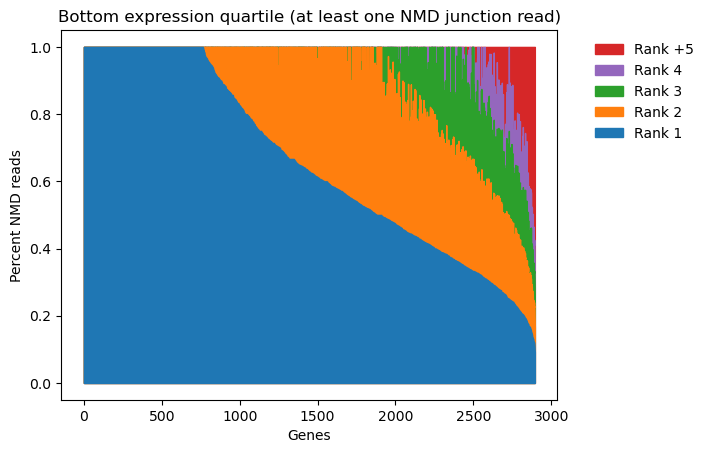

In [163]:
top_quart = log2RPKM.loc[df_rank.index].sort_values('RPKM').index[:int(11586/4)]
rank1 = np.array(df_rank.loc[top_quart].sort_values('Rank 1', ascending=False)['Rank 1'])
rank2 = np.array(df_rank.loc[top_quart].sort_values('Rank 1', ascending=False)['Rank 2'])
rank3 = np.array(df_rank.loc[top_quart].sort_values('Rank 1', ascending=False)['Rank 3'])
rank4 = np.array(df_rank.loc[top_quart].sort_values('Rank 1', ascending=False)['Rank 4'])
rank5 = np.array(df_rank.loc[top_quart].sort_values('Rank 1', ascending=False)['Rank 5+'])
x = range(len(top_quart))
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3+rank4+rank5, color='tab:red', label='Rank +5')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3+rank4, color='tab:purple', label='Rank 4')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3, color='tab:green', label='Rank 3')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2, color='tab:orange', label='Rank 2')
plt.fill_between(x,  rank1, color='tab:blue', label='Rank 1')
plt.xlabel('Genes')
plt.ylabel('Percent NMD reads')
plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('Bottom expression quartile (at least one NMD junction read)')

In [13]:
long_summary['intron_count'] = [1]*len(long_summary)

In [127]:
long_summary.groupby('gene').intron_count.sum().mode()

0    1
dtype: int64

Text(0, 0.5, 'CDF')

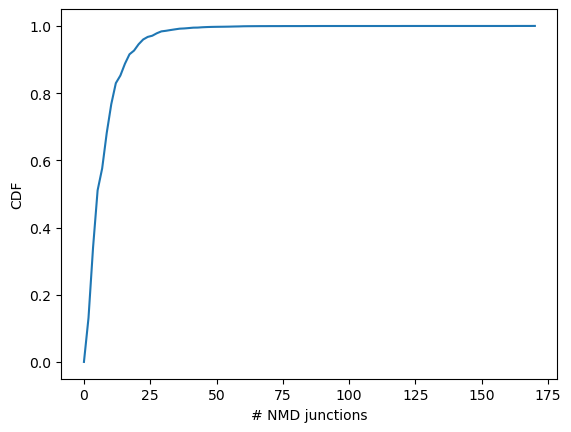

In [14]:
x = np.linspace(0, long_summary.groupby('gene').intron_count.sum().max(), 100)
y = [(long_summary.groupby('gene').intron_count.sum() <= z).mean() for z in x]
plt.plot(x, y)
plt.xlabel('# NMD junctions')
plt.ylabel('CDF')
# plt.xlim([-1, 51])

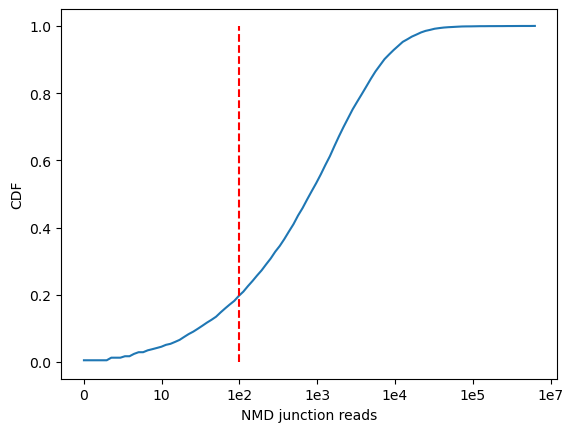

In [15]:
x = np.linspace(np.log10(long_summary.groupby('gene').Count.sum()).min(), 
                np.log10(long_summary.groupby('gene').Count.sum()).max(), 100)
y = [(np.log10(long_summary.groupby('gene').Count.sum()) <= z).mean() for z in x]
plt.plot(x, y)
plt.xlabel('NMD junction reads')
plt.ylabel('CDF')
# plt.xlim([-1, 51])
plt.xticks(range(7), ['0', '10', '1e2', '1e3', '1e4', '1e5', '1e7'])
plt.plot([2, 2], [0, 1], 'r--')

In [199]:
long_summary.groupby('gene').Count.sum().min()

1

In [242]:
long_summary = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'junction']).Count.sum().reset_index()


rank_list = []
gene_list = []

count = 0
for gene, df in tqdm(long_summary.groupby('gene')):
    
    suma = df.Count.sum()
    
    if suma < 5000:
        continue

    rank_percent = df.sort_values('Count', ascending=False).Count/suma
    
    rank_percent = sorted(rank_percent)[::-1]
    
    rank = []
    for i in range(5):
        if i >= len(rank_percent):
            to_add = 0
        elif i == 4:
            to_add = 1-np.sum(rank_percent[:4])
        else:
            to_add = rank_percent[i]
        
        rank.append(to_add)
    rank_list.append(rank)
    gene_list.append(gene)
        
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11586/11586 [00:02<00:00, 4760.72it/s]


In [243]:
df_rank = pd.DataFrame(rank_list)
df_rank.columns = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']
df_rank.index = gene_list

Text(0.5, 1.0, 'Genes with at least 5,000 NMD reads')

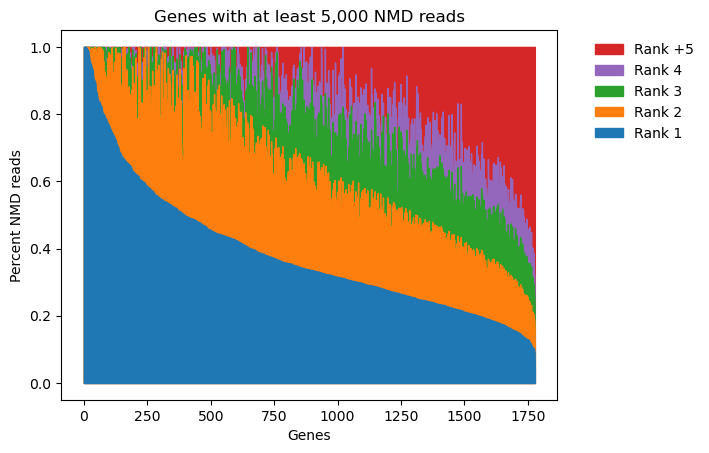

In [245]:
rank1 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 1'])
rank2 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 2'])
rank3 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 3'])
rank4 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 4'])
rank5 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 5+'])
x = range(len(rank1))
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3+rank4+rank5, color='tab:red', label='Rank +5')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3+rank4, color='tab:purple', label='Rank 4')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3, color='tab:green', label='Rank 3')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2, color='tab:orange', label='Rank 2')
plt.fill_between(x,  rank1, color='tab:blue', label='Rank 1')
plt.xlabel('Genes')
plt.ylabel('Percent NMD reads')
plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)

plt.title('Genes with at least 5,000 NMD reads')

In [209]:
top_quart = log2RPKM.loc[df_rank.index].sort_values('RPKM').index[-int(9300/4):]

Text(0.5, 1.0, 'Genes with at least 100 NMD reads (top expression quartile)')

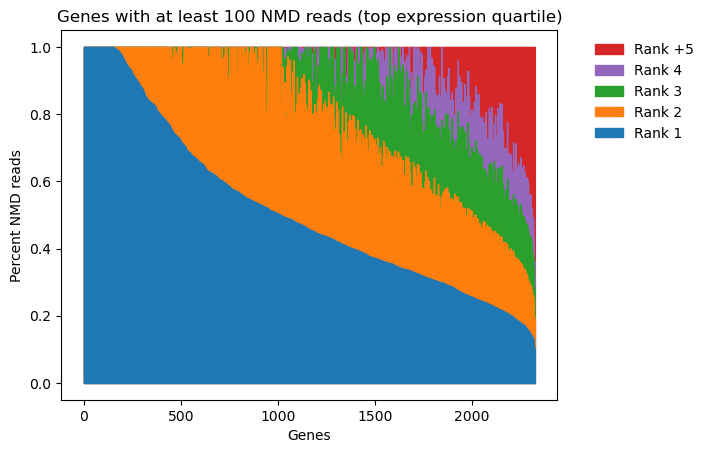

In [210]:
rank1 = np.array(df_rank.loc[top_quart].sort_values('Rank 1', ascending=False)['Rank 1'])
rank2 = np.array(df_rank.loc[top_quart].sort_values('Rank 1', ascending=False)['Rank 2'])
rank3 = np.array(df_rank.loc[top_quart].sort_values('Rank 1', ascending=False)['Rank 3'])
rank4 = np.array(df_rank.loc[top_quart].sort_values('Rank 1', ascending=False)['Rank 4'])
rank5 = np.array(df_rank.loc[top_quart].sort_values('Rank 1', ascending=False)['Rank 5+'])
x = range(len(top_quart))
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3+rank4+rank5, color='tab:red', label='Rank +5')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3+rank4, color='tab:purple', label='Rank 4')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3, color='tab:green', label='Rank 3')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2, color='tab:orange', label='Rank 2')
plt.fill_between(x,  rank1, color='tab:blue', label='Rank 1')
plt.xlabel('Genes')
plt.ylabel('Percent NMD reads')
plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('Genes with at least 100 NMD reads (top expression quartile)')

In [144]:
df_rank

Rank 1    Rank 2    Rank 3    Rank 4   Rank 5+
ENSG00000000419  0.506329  0.450422  0.043249  0.000000  0.000000
ENSG00000000457  0.221184  0.144435  0.138204  0.135089  0.361088
ENSG00000000460  0.273279  0.146880  0.096752  0.082334  0.400755
ENSG00000000938  0.499020  0.171839  0.147174  0.091392  0.090575
ENSG00000001036  0.760736  0.239264  0.000000  0.000000  0.000000
...                   ...       ...       ...       ...       ...
ENSG00000286001  0.975177  0.015198  0.004559  0.004053  0.001013
ENSG00000286019  0.602410  0.397590  0.000000  0.000000  0.000000
ENSG00000286070  0.523922  0.336090  0.128766  0.011223  0.000000
ENSG00000286905  0.594427  0.204334  0.201238  0.000000  0.000000
ENSG00000288534  0.953216  0.046784  0.000000  0.000000  0.000000

[9300 rows x 5 columns]

In [212]:
long_table

chrom      start       stop strand                    Dataset  \
9737       chr1     944800     945042      -  chRNA.Expression.Splicing   
9738       chr1     944800     945057      -  chRNA.Expression.Splicing   
9739       chr1     945146     945518      -  chRNA.Expression.Splicing   
9740       chr1     945653     946173      -  chRNA.Expression.Splicing   
9741       chr1     945653     946147      -  chRNA.Expression.Splicing   
...         ...        ...        ...    ...                        ...   
15988530  chr12  117285332  117286104      -  chRNA.Expression.Splicing   
15988536  chr15  100341409  100341821      -  chRNA.Expression.Splicing   
15988538  chr16   23700704   23702152      -  chRNA.Expression.Splicing   
15988539  chr16   70941819   70943812      -  chRNA.Expression.Splicing   
15988540  chr16   70962138   70964728      -  chRNA.Expression.Splicing   

            IndID RepNumber  Count        end  \
9737      NA18853    1.junc     36     945042   
9738      NA18853    1.junc    115     945057   
9739      NA18853    1.junc    231     945518   
9740      NA18853    1.junc    115     946173   
9741      NA18853    1.junc      4     946147   
...           ...       ...    ...        ...   
15988530  NA19128    1.junc      2  117286104   
15988536  NA19128    1.junc      2  100341821   
15988538  NA19128    1.junc      2   23702152   
15988539  NA19128    1.junc      4   70943812   
15988540  NA19128    1.junc      2   70964728   

                               NewAnnotation             gene    symbol  \
9737                 retained_intron.gencode  ENSG00000188976     NOC2L   
9738                  protein_coding.gencode  ENSG00000188976     NOC2L   
9739                  protein_coding.gencode  ENSG00000188976     NOC2L   
9740                  protein_coding.gencode  ENSG00000188976     NOC2L   
9741      nonsense_mediated_decay.pstopcodon  ENSG00000188976     NOC2L   
...                                      ...              ...       ...   
15988530              protein_coding.gencode  ENSG00000089250      NOS1   
15988536              protein_coding.gencode  ENSG00000140470  ADAMTS17   
15988538              protein_coding.gencode  ENSG00000134398      ERN2   
15988539              protein_coding.gencode  ENSG00000157423     HYDIN   
15988540              protein_coding.gencode  ENSG00000157423     HYDIN   

                                 SuperAnnotation  \
9737        AnnotatedJunc_UnproductiveCodingGene   
9738          AnnotatedJunc_ProductiveCodingGene   
9739          AnnotatedJunc_ProductiveCodingGene   
9740          AnnotatedJunc_ProductiveCodingGene   
9741      UnannotatedJunc_UnproductiveCodingGene   
...                                          ...   
15988530      AnnotatedJunc_ProductiveCodingGene   
15988536      AnnotatedJunc_ProductiveCodingGene   
15988538      AnnotatedJunc_ProductiveCodingGene   
15988539      AnnotatedJunc_ProductiveCodingGene   
15988540      AnnotatedJunc_ProductiveCodingGene   

             SemiSupergroupAnnotations                     junction  \
9737      uniquely retained_intron tag         chr1:944800:945042:-   
9738                         basic tag         chr1:944800:945057:-   
9739                         basic tag         chr1:945146:945518:-   
9740                         basic tag         chr1:945653:946173:-   
9741          predicted_NMD pstopcodon         chr1:945653:946147:-   
...                                ...                          ...   
15988530                     basic tag  chr12:117285332:117286104:-   
15988536                     basic tag  chr15:100341409:100341821:-   
15988538                     basic tag    chr16:23700704:23702152:-   
15988539                     basic tag    chr16:70941819:70943812:-   
15988540                     basic tag    chr16:70962138:70964728:-   

          gene_total  gene_max  PSI_total       PSI  
9737            4149       486   0.008677  0.074074  
9738            4149       486   

In [223]:
long_summary = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'junction', 'symbol']).Count.sum().reset_index()


rank_list = []
gene_list = []

count = 0
for gene, df in tqdm(long_summary.groupby('symbol')):
    
    suma = df.Count.sum()
    
    if gene not in splicing_factors:
        continue
    
#     if suma < 10000:
#         continue

    rank_percent = df.sort_values('Count', ascending=False).Count/suma
    
    rank_percent = sorted(rank_percent)[::-1]
    
    rank = []
    for i in range(5):
        if i >= len(rank_percent):
            to_add = 0
        elif i == 4:
            to_add = 1-np.sum(rank_percent[:4])
        else:
            to_add = rank_percent[i]
        
        rank.append(to_add)
    rank_list.append(rank)
    gene_list.append(gene)
        
    
df_rank = pd.DataFrame(rank_list)
df_rank.columns = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']
df_rank.index = gene_list

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11584/11584 [00:01<00:00, 6698.92it/s]


Text(0.5, 1.0, 'Splicing factors')

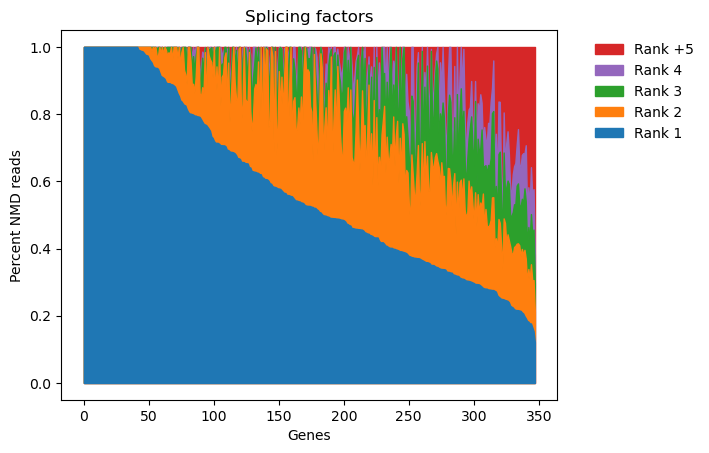

In [225]:
rank1 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 1'])
rank2 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 2'])
rank3 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 3'])
rank4 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 4'])
rank5 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 5+'])
x = range(len(rank1))
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3+rank4+rank5, color='tab:red', label='Rank +5')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3+rank4, color='tab:purple', label='Rank 4')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3, color='tab:green', label='Rank 3')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2, color='tab:orange', label='Rank 2')
plt.fill_between(x,  rank1, color='tab:blue', label='Rank 1')
plt.xlabel('Genes')
plt.ylabel('Percent NMD reads')
plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)

plt.title('Splicing factors')

In [246]:
long_summary = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'junction']).Count.sum().reset_index()


rank_list = []
gene_list = []
suma_list = []
intron_counts_list = []

count = 0
for gene, df in tqdm(long_summary.groupby('gene')):
    
    suma = df.Count.sum()
    
    suma_list.append(suma)
    
    intron_counts = len(df)
    intron_counts_list.append(intron_counts)

    rank_percent = df.sort_values('Count', ascending=False).Count/suma
    
    rank_percent = sorted(rank_percent)[::-1]
    
    rank = []
    for i in range(5):
        if i >= len(rank_percent):
            to_add = 0
        elif i == 4:
            to_add = 1-np.sum(rank_percent[:4])
        else:
            to_add = rank_percent[i]
        
        rank.append(to_add)
    rank_list.append(rank)
    gene_list.append(gene)
        
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11586/11586 [00:06<00:00, 1765.51it/s]


In [249]:
df_rank = pd.DataFrame(rank_list)
df_rank.columns = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']
df_rank.index = gene_list

df_summary = pd.DataFrame([suma_list, intron_counts_list]).T
df_summary.columns = ['total_reads', 'total_junctions']
df_summary.index = gene_list

Text(0.5, 1.0, 'Splicing factors')

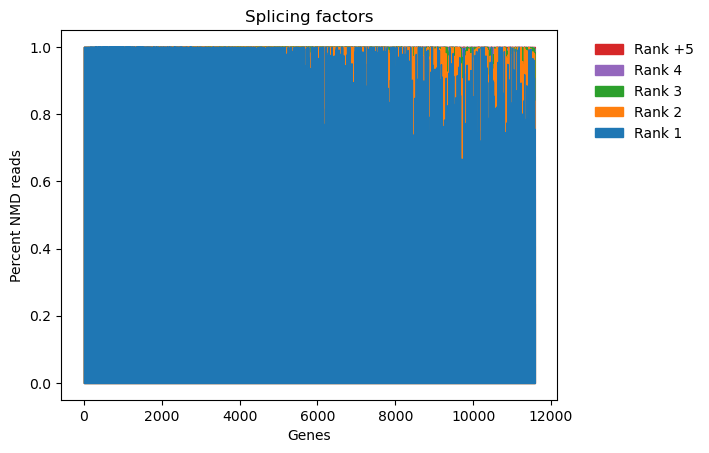

In [253]:
idx = df_summary.sort_values('total_reads').index

rank1 = np.array(df_rank.loc[idx, 'Rank 1'])
rank2 = np.array(df_rank.loc[idx, 'Rank 2'])
rank3 = np.array(df_rank.loc[idx, 'Rank 3'])
rank4 = np.array(df_rank.loc[idx, 'Rank 4'])
rank5 = np.array(df_rank.loc[idx, 'Rank 5+'])
x = range(len(rank1))
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3+rank4+rank5, color='tab:red', label='Rank +5')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3+rank4, color='tab:purple', label='Rank 4')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3, color='tab:green', label='Rank 3')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2, color='tab:orange', label='Rank 2')
plt.fill_between(x,  rank1, color='tab:blue', label='Rank 1')
plt.xlabel('Genes')
plt.ylabel('Percent NMD reads')
plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)

plt.title('Splicing factors')

In [310]:
rank1 = np.array(df_rank.sort_values('Rank 5+', ascending=False)['Rank 5+'])

In [305]:
rank1 = np.array(df_rank.sort_values('Rank 2', ascending=False)['Rank 2'])

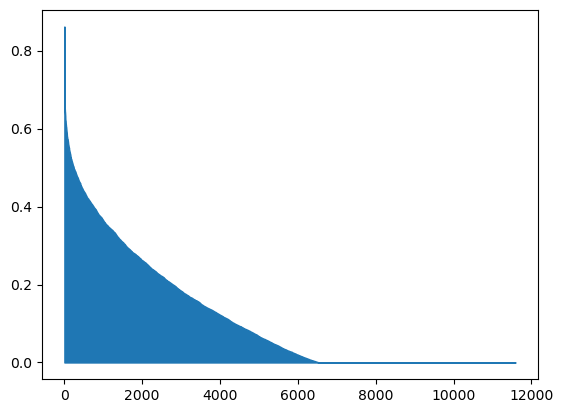

In [311]:
plt.fill_between(x, [0]*len(rank1),  rank1, color='tab:blue', label='Rank 1')


In [291]:
rank1

array([0.5, 0.5, 0.5, ..., 1. , 1. , 1. ])

Text(0.5, 1.0, 'All genes (at least one NMD junction read)')

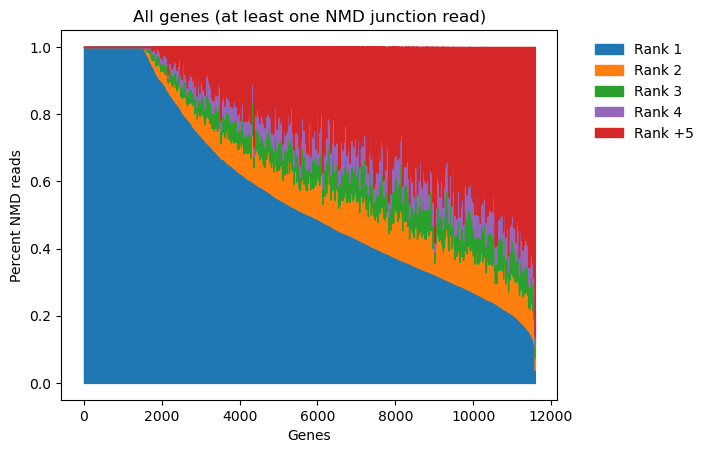

In [343]:
rank1 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 1'])
rank2 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 2'])
rank3 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 3'])
rank4 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 4'])
rank5 = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 5+'])
x = range(len(rank1))
plt.fill_between(x, [0]*len(rank1), rank1, color='tab:blue', label='Rank 1')

plt.fill_between(x, rank1,  rank1+rank2, color='tab:orange', label='Rank 2')


plt.fill_between(x, rank1+rank2, rank1+rank2+rank3, color='tab:green', label='Rank 3')


plt.fill_between(x,  rank1+rank2+rank3, rank1+rank2+rank3+rank4, color='tab:purple', label='Rank 4')

plt.fill_between(x,  rank1+rank2+rank3+rank4, rank1+rank2+rank3+rank4+rank5, color='tab:red', label='Rank +5')

plt.xlabel('Genes')
plt.ylabel('Percent NMD reads')
plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('All genes (at least one NMD junction read)')

In [324]:
rank1_ = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 1'])
rank2_ = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 2'])
rank3_ = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 3'])
rank4_ = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 4'])
rank5_ = np.array(df_rank.sort_values('Rank 1', ascending=False)['Rank 5+'])

rank1 = []
rank2 = []
rank3 = []
rank4 = []
rank5 = []
for i in range(len(rank1_)):
    rank1.append(rank1_[i])
    rank1.append(rank1_[i])
    
    rank2.append(rank2_[i])
    rank2.append(rank2_[i])
    
    rank3.append(rank3_[i])
    rank3.append(rank3_[i])
    
    rank4.append(rank4_[i])
    rank4.append(rank4_[i])
    
    rank5.append(rank5_[i])
    rank5.append(rank5_[i])
    
rank1 = np.array(rank1)
rank2 = np.array(rank2)
rank3 = np.array(rank3)
rank4 = np.array(rank4)
rank5 = np.array(rank5)

Text(0.5, 1.0, 'All genes (at least one NMD junction read)')

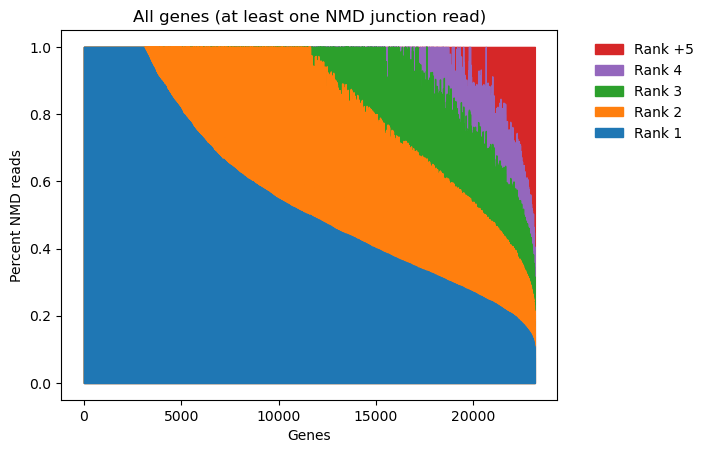

In [325]:
x = range(len(rank1))
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3+rank4+rank5, color='tab:red', label='Rank +5')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3+rank4, color='tab:purple', label='Rank 4')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2+rank3, color='tab:green', label='Rank 3')
plt.fill_between(x, np.zeros(len(x)), rank1+rank2, color='tab:orange', label='Rank 2')
plt.fill_between(x,  rank1, color='tab:blue', label='Rank 1')
plt.xlabel('Genes')
plt.ylabel('Percent NMD reads')
plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('All genes (at least one NMD junction read)')

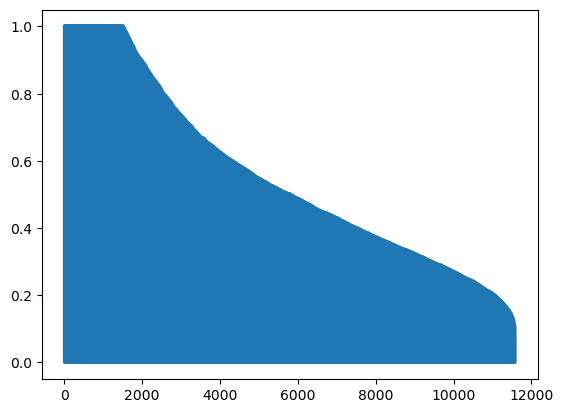

In [347]:
i = 0
for idx, row in df_rank.sort_values('Rank 1', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue')
    
    i+=1

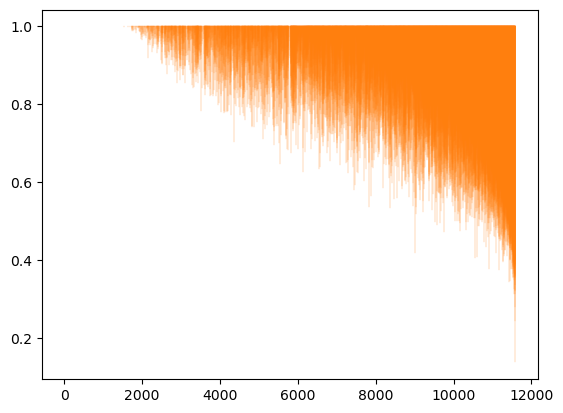

In [354]:
i = 0
for idx, row in df_rank.sort_values('Rank 1', ascending=False).iterrows():
#     plt.plot([i, i], [0, row['Rank 1']], c='tab:blue')
    plt.plot([i, i], [row['Rank 1']+row['Rank 2'] + row['Rank 4'] + row['Rank 3'], 
                      row['Rank 5+'] + row['Rank 4'] + row['Rank 3'] + row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    i+=1

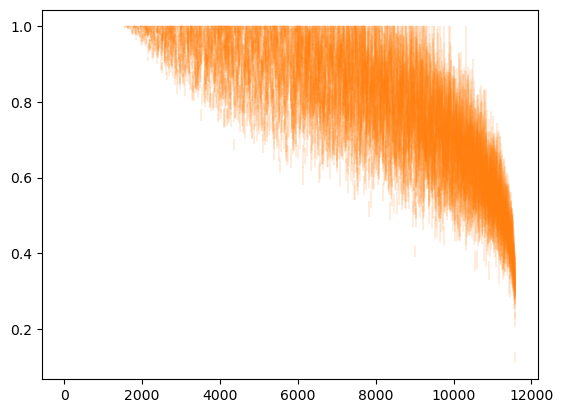

In [355]:
i = 0
for idx, row in df_rank.sort_values('Rank 1', ascending=False).iterrows():
#     plt.plot([i, i], [0, row['Rank 1']], c='tab:blue')
    plt.plot([i, i], [row['Rank 1']+row['Rank 2'] + row['Rank 3'], 
                      row['Rank 4'] + row['Rank 3'] + row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    i+=1

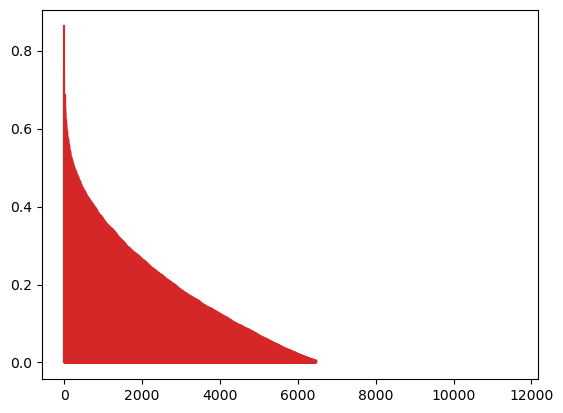

In [358]:
i = 0
for idx, row in df_rank.sort_values('Rank 5+', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 5+']], c='tab:red')
    
    i+=1

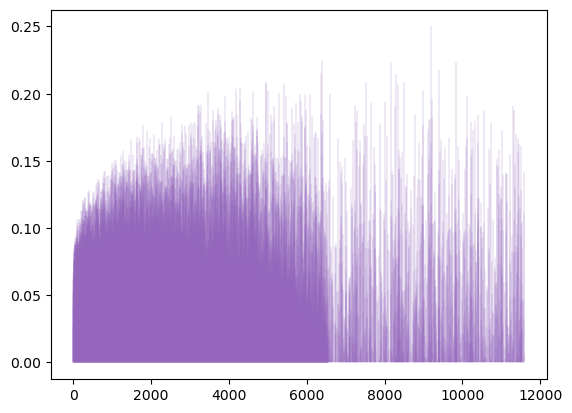

In [360]:
i = 0
for idx, row in df_rank.sort_values('Rank 5+', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 4']], c='tab:purple', linewidth=0.2)
    
    i+=1

Text(0.5, 1.0, 'All genes (at least one NMD junction read)')

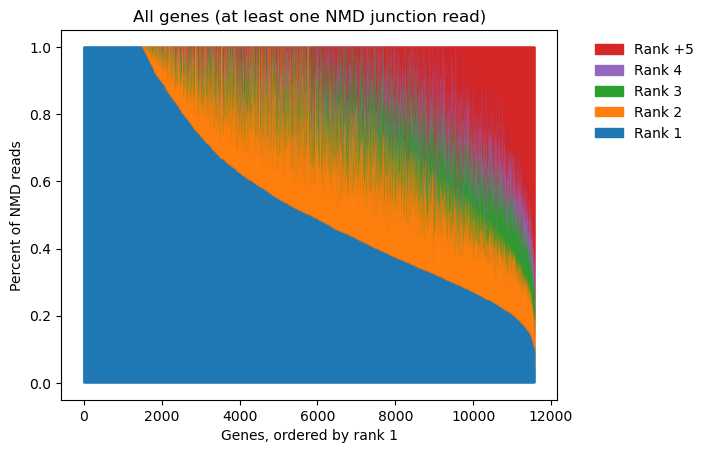

In [363]:
plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.sort_values('Rank 1', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by rank 1')
plt.ylabel('Percent of NMD reads')

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('All genes (at least one NMD junction read)')

Text(0.5, 1.0, 'All genes (at least one NMD junction read)')

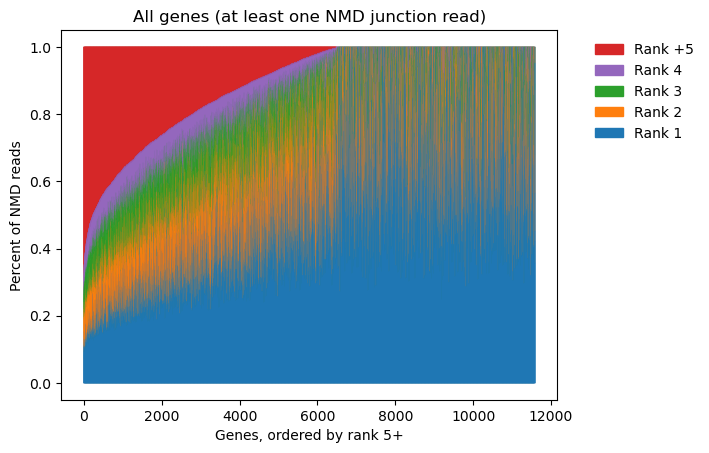

In [364]:
plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.sort_values('Rank 5+', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by rank 5+')
plt.ylabel('Percent of NMD reads')

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('All genes (at least one NMD junction read)')

In [365]:
long_summary = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'junction']).Count.sum().reset_index()


rank_list = []
gene_list = []
suma_list = []
intron_counts_list = []

count = 0
for gene, df in tqdm(long_summary.groupby('gene')):
    
    suma = df.Count.sum()
    
    if suma < 100:
        continue
    
    suma_list.append(suma)
    
    intron_counts = len(df)
    intron_counts_list.append(intron_counts)

    rank_percent = df.sort_values('Count', ascending=False).Count/suma
    
    rank_percent = sorted(rank_percent)[::-1]
    
    rank = []
    for i in range(5):
        if i >= len(rank_percent):
            to_add = 0
        elif i == 4:
            to_add = 1-np.sum(rank_percent[:4])
        else:
            to_add = rank_percent[i]
        
        rank.append(to_add)
    rank_list.append(rank)
    gene_list.append(gene)
        
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11586/11586 [00:05<00:00, 2095.10it/s]


In [366]:
df_rank = pd.DataFrame(rank_list)
df_rank.columns = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']
df_rank.index = gene_list

df_summary = pd.DataFrame([suma_list, intron_counts_list]).T
df_summary.columns = ['total_reads', 'total_junctions']
df_summary.index = gene_list

Text(0.5, 1.0, 'All genes (at least 100 NMD junction read)')

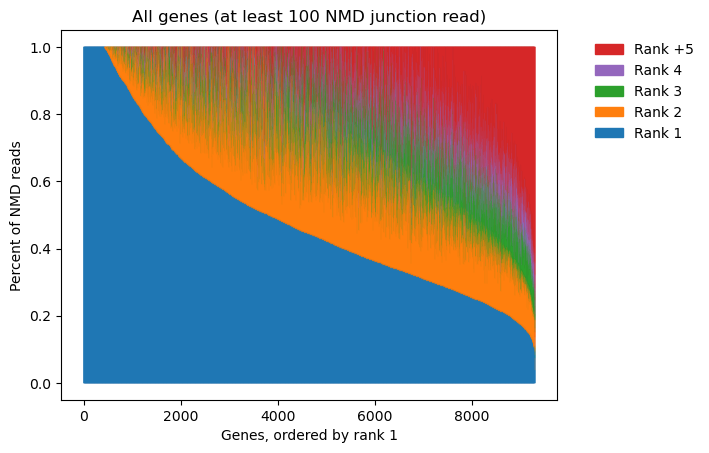

In [368]:
plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.sort_values('Rank 1', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by rank 1')
plt.ylabel('Percent of NMD reads')

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('All genes (at least 100 NMD junction read)')

Text(0.5, 1.0, 'All genes (at least 100 NMD junction read)')

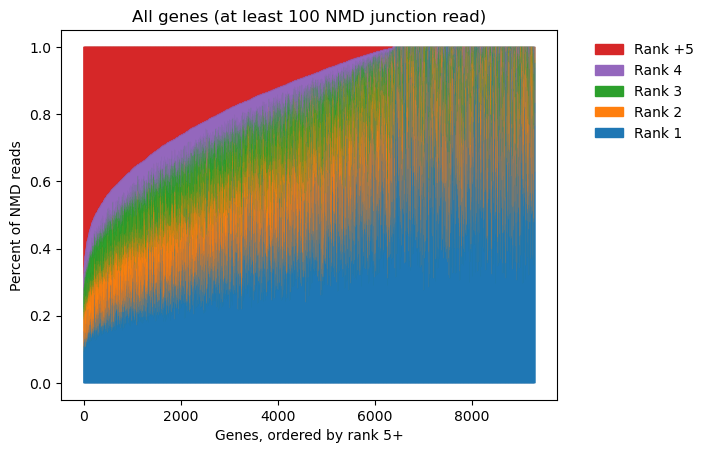

In [369]:
plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.sort_values('Rank 5+', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by rank 5+')
plt.ylabel('Percent of NMD reads')

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('All genes (at least 100 NMD junction read)')

In [370]:
long_summary = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'junction']).Count.sum().reset_index()


rank_list = []
gene_list = []
suma_list = []
intron_counts_list = []

count = 0
for gene, df in tqdm(long_summary.groupby('gene')):
    
    suma = df.Count.sum()
    
    if suma < 1000:
        continue
    
    suma_list.append(suma)
    
    intron_counts = len(df)
    intron_counts_list.append(intron_counts)

    rank_percent = df.sort_values('Count', ascending=False).Count/suma
    
    rank_percent = sorted(rank_percent)[::-1]
    
    rank = []
    for i in range(5):
        if i >= len(rank_percent):
            to_add = 0
        elif i == 4:
            to_add = 1-np.sum(rank_percent[:4])
        else:
            to_add = rank_percent[i]
        
        rank.append(to_add)
    rank_list.append(rank)
    gene_list.append(gene)
        
    
df_rank = pd.DataFrame(rank_list)
df_rank.columns = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']
df_rank.index = gene_list

df_summary = pd.DataFrame([suma_list, intron_counts_list]).T
df_summary.columns = ['total_reads', 'total_junctions']
df_summary.index = gene_list

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11586/11586 [00:03<00:00, 2967.19it/s]


Text(0.5, 1.0, 'All genes (at least 1000 NMD junction read)')

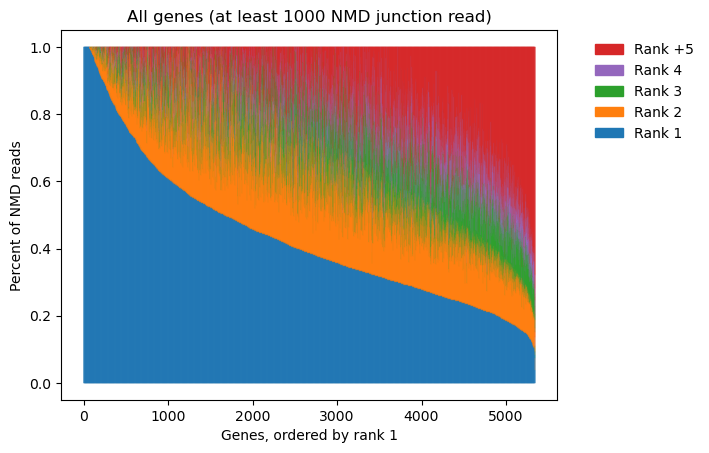

In [372]:
plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.sort_values('Rank 1', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by rank 1')
plt.ylabel('Percent of NMD reads')

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('All genes (at least 1000 NMD junction read)')

Text(0.5, 1.0, 'All genes (at least 1000 NMD junction read)')

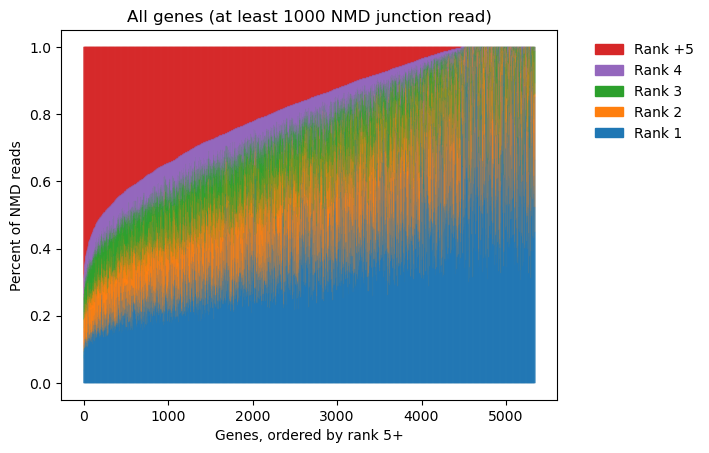

In [373]:
plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.sort_values('Rank 5+', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by rank 5+')
plt.ylabel('Percent of NMD reads')

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('All genes (at least 1000 NMD junction read)')

Text(0.5, 1.0, 'All genes (at least 1000 NMD junction read)')

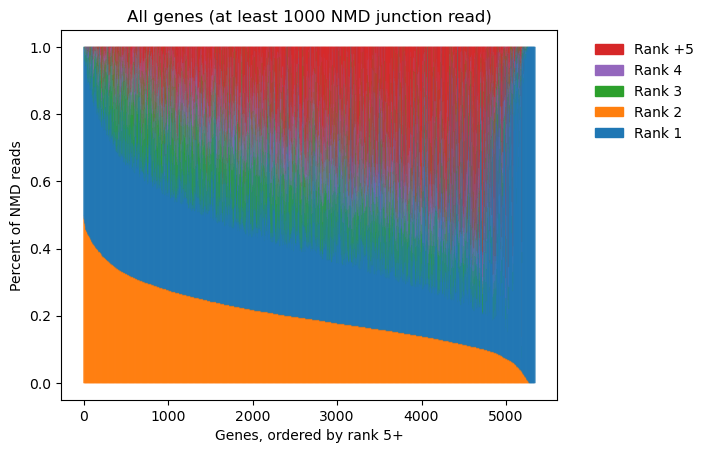

In [396]:
plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.sort_values('Rank 2', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 2']], c='tab:orange', linewidth=0.2)
    plt.plot([i, i], [row['Rank 2'], 
                      row['Rank 2']+row['Rank 1']], c='tab:blue',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by rank 5+')
plt.ylabel('Percent of NMD reads')

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('All genes (at least 1000 NMD junction read)')

In [385]:
df_summary.sort_values('total_junctions')

total_reads  total_junctions
ENSG00000112308         1662                1
ENSG00000184110         2099                1
ENSG00000170222         1806                1
ENSG00000162066         1413                1
ENSG00000112306         1460                1
...                      ...              ...
ENSG00000160293        29273               83
ENSG00000181722        16770               88
ENSG00000112584        15175              119
ENSG00000215712        11396              163
ENSG00000205592       111246              170

[5344 rows x 2 columns]

Text(0.5, 1.0, 'All genes (at least 1000 NMD junction read)')

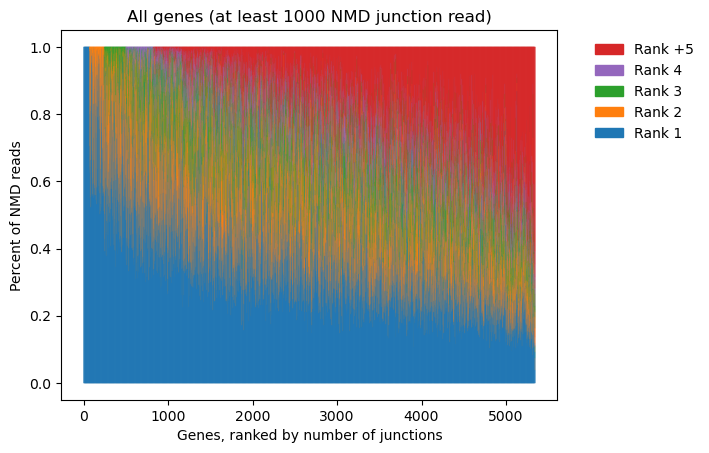

In [399]:
plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.loc[df_summary.sort_values('total_junctions').index].iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ranked by number of junctions')
plt.ylabel('Percent of NMD reads')

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('All genes (at least 1000 NMD junction read)')

In [381]:
# long_summary = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'junction', 'start', 'end']
#                                                                            ).Count.sum().reset_index()

for gene, df in long_summary.groupby('gene'):
    df = df.sort_values('start')
    
    for idx, row in 
    break

In [382]:
df.sort_values('start')

gene                   junction     start       end  Count
0  ENSG00000000419  chr20:50940955:50941105:-  50940955  50941105     41
1  ENSG00000000419  chr20:50940955:50942031:-  50940955  50942031    427
2  ENSG00000000419  chr20:50942126:50945847:-  50942126  50945847    480

Text(0.5, 1.0, 'Percent of NMD reads in genes with 1000+ NMD reads')

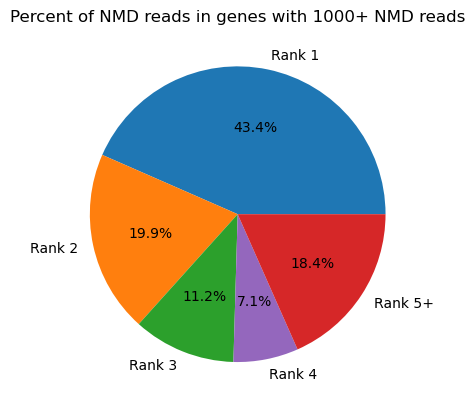

In [402]:
fig, ax = plt.subplots()

ax.pie(df_rank.mean(axis=0), colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red'],
      labels=df_rank.columns, autopct='%1.1f%%')

plt.title('Percent of NMD reads in genes with 1000+ NMD reads')

Text(0.5, 1.0, 'All genes (at least 1000 NMD junction read)')

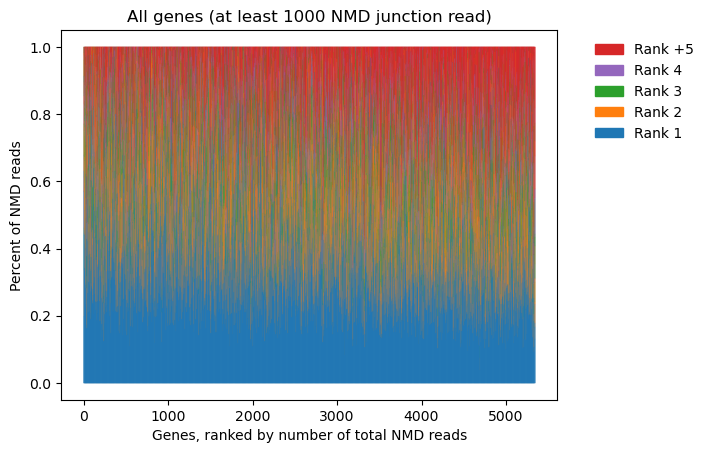

In [400]:
plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.loc[df_summary.sort_values('total_reads').index].iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ranked by number of total NMD reads')
plt.ylabel('Percent of NMD reads')

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('All genes (at least 1000 NMD junction read)')

Text(0.5, 1.0, 'All genes (at least 1000 NMD junction read)')

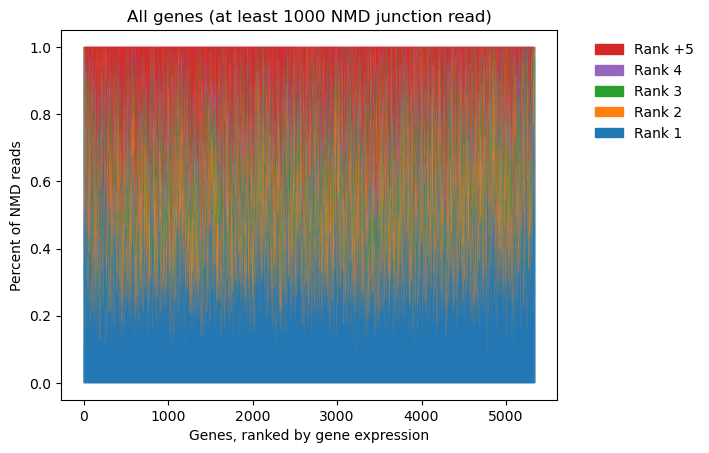

In [401]:
plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.loc[log2RPKM.loc[df_rank.index].sort_values('RPKM').index].iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ranked by gene expression')
plt.ylabel('Percent of NMD reads')

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('All genes (at least 1000 NMD junction read)')

In [403]:
long_summary = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'junction']).Count.sum().reset_index()


rank_list = []
gene_list = []
suma_list = []
intron_counts_list = []

count = 0
for gene, df in tqdm(long_summary.groupby('gene')):
    
    suma = df.Count.sum()
    
#     if suma < 1000:
#         continue
    
    suma_list.append(suma)
    
    intron_counts = len(df)
    intron_counts_list.append(intron_counts)

    rank_percent = df.sort_values('Count', ascending=False).Count/suma
    
    rank_percent = sorted(rank_percent)[::-1]
    
    rank = []
    for i in range(5):
        if i >= len(rank_percent):
            to_add = 0
        elif i == 4:
            to_add = 1-np.sum(rank_percent[:4])
        else:
            to_add = rank_percent[i]
        
        rank.append(to_add)
    rank_list.append(rank)
    gene_list.append(gene)
        
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11586/11586 [00:06<00:00, 1812.89it/s]


In [404]:
df_rank = pd.DataFrame(rank_list)
df_rank.columns = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']
df_rank.index = gene_list

df_summary = pd.DataFrame([suma_list, intron_counts_list]).T
df_summary.columns = ['total_reads', 'total_junctions']
df_summary.index = gene_list

Text(0.5, 1.0, 'Top # NMD junctions quartile')

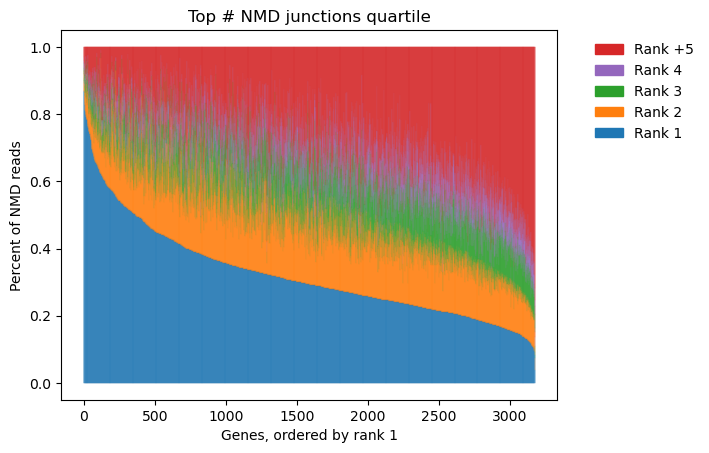

In [434]:
df_idx = df_summary.loc[df_summary.total_junctions >= df_summary.total_junctions.quantile(0.75)].index

plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by rank 1')
plt.ylabel('Percent of NMD reads')

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('Top # NMD junctions quartile')

Text(0.5, 1.0, 'Bottom # NMD junctions quartile')

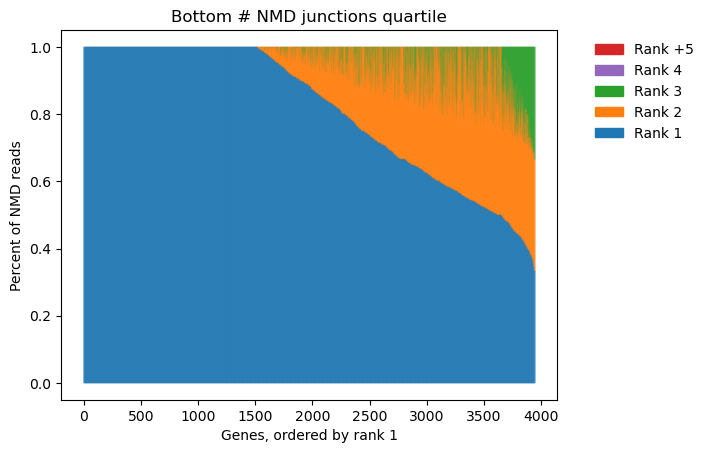

In [435]:
df_idx = df_summary.loc[df_summary.total_junctions <= df_summary.total_junctions.quantile(0.25)].index

plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by rank 1')
plt.ylabel('Percent of NMD reads')

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('Bottom # NMD junctions quartile')

In [425]:
x = np.linspace(0, 1, 1000)
y1 = [np.mean(df_rank['Rank 1']<i) for i in x]
y2 = [np.mean(df_rank['Rank 2']<i) for i in x]
y3 = [np.mean(df_rank['Rank 3']<i) for i in x]
y4 = [np.mean(df_rank['Rank 4']<i) for i in x]
y5 = [np.mean(df_rank['Rank 5+']<i) for i in x]


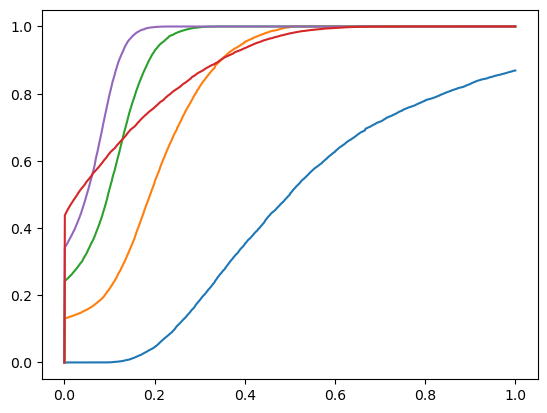

In [426]:
plt.plot(x, y1, c='tab:blue')
plt.plot(x, y2, c='tab:orange')
plt.plot(x, y3, c='tab:green')
plt.plot(x, y4, c='tab:purple')
plt.plot(x, y5, c='tab:red')

Text(0.5, 1.0, 'Percent of NMD reads in top # NMD junctions quartile')

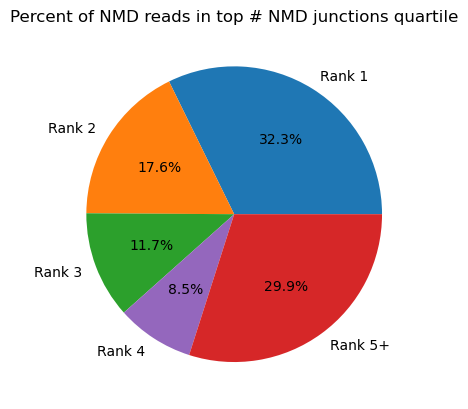

In [436]:
fig, ax = plt.subplots()

df_idx = df_summary.loc[df_summary.total_junctions >= df_summary.total_junctions.quantile(0.75)].index


ax.pie(df_rank.loc[df_idx].mean(axis=0), colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red'],
      labels=df_rank.columns, autopct='%1.1f%%')

plt.title('Percent of NMD reads in top # NMD junctions quartile')

Text(0.5, 1.0, 'Percent of NMD reads in bottom # NMD junctions quartile')

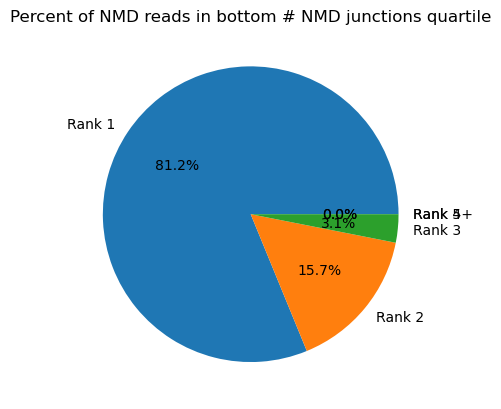

In [438]:
fig, ax = plt.subplots()

df_idx = df_summary.loc[df_summary.total_junctions <= df_summary.total_junctions.quantile(0.25)].index


ax.pie(df_rank.loc[df_idx].mean(axis=0), colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red'],
      labels=df_rank.columns, autopct='%1.1f%%')

plt.title('Percent of NMD reads in bottom # NMD junctions quartile')

In [19]:
exon_counts = pd.read_csv('../code/exons.appris_principal.basic_annotation.bed.gz', sep='\t')
exon_counts.columns = ['chrom', 'start', 'end', 'gene', 'symbol', 'strand', 'transcript']
exon_counts.gene = [x.split('.')[0] for x in exon_counts.gene]
exon_counts['exon_count'] = 1

In [476]:
long_summary = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'junction']).Count.sum().reset_index()
long_summary = long_summary.merge(pd.DataFrame(
    exon_counts.groupby(['gene', 'transcript']).exon_count.sum().reset_index().groupby('gene').exon_count.max()
), left_on='gene', right_index=True)

rank_list = []
gene_list = []
suma_list = []
intron_counts_list = []

count = 0
for gene, df in tqdm(long_summary.groupby('gene')):
    
    suma = df.Count.sum()
    
    suma_list.append(suma)
    
    intron_counts = list(df.exon_count)[0]
    intron_counts_list.append(intron_counts)

    rank_percent = df.sort_values('Count', ascending=False).Count/suma
    
    rank_percent = sorted(rank_percent)[::-1]
    
    rank = []
    for i in range(5):
        if i >= len(rank_percent):
            to_add = 0
        elif i == 4:
            to_add = 1-np.sum(rank_percent[:4])
        else:
            to_add = rank_percent[i]
        
        rank.append(to_add)
    rank_list.append(rank)
    gene_list.append(gene)
        
    
df_rank = pd.DataFrame(rank_list)
df_rank.columns = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']
df_rank.index = gene_list

df_summary = pd.DataFrame([suma_list, intron_counts_list]).T
df_summary.columns = ['total_reads', 'total_junctions']
df_summary.index = gene_list

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11563/11563 [00:06<00:00, 1651.96it/s]


In [488]:
df_summary.total_junctions.quantile(0.25)

6.0

Text(0.5, 1.0, 'Top introns quartile')

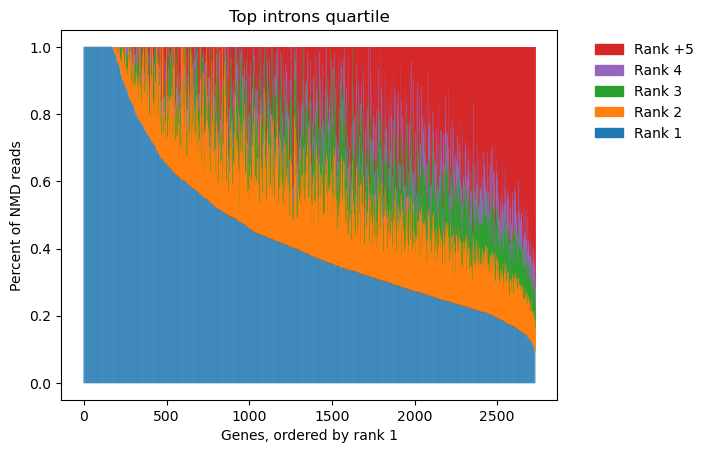

In [489]:


df_idx = df_summary.loc[df_summary.total_junctions > df_summary.total_junctions.quantile(0.75)].index

plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.4)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.4)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.4)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.4)
    
    i+=1
    
plt.xlabel('Genes, ordered by rank 1')
plt.ylabel('Percent of NMD reads')

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('Top introns quartile')

Text(0.5, 1.0, 'Bottom introns quartile')

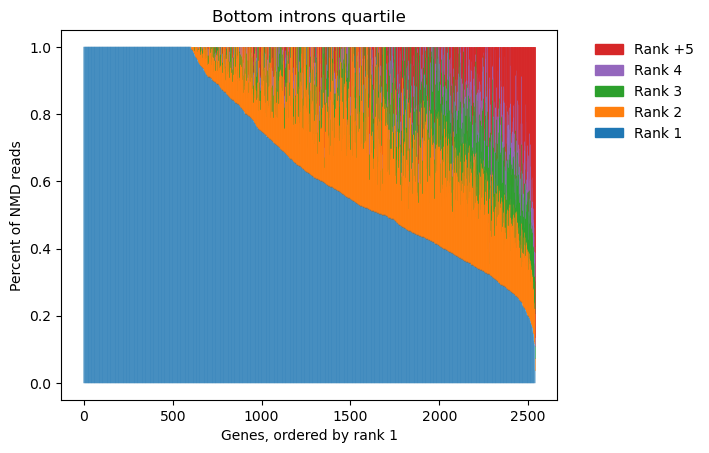

In [491]:


df_idx = df_summary.loc[df_summary.total_junctions < df_summary.total_junctions.quantile(0.25)].index

plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.4)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.4)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.4)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.4)
    
    i+=1
    
plt.xlabel('Genes, ordered by rank 1')
plt.ylabel('Percent of NMD reads')

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('Bottom introns quartile')

Text(0.5, 1.0, 'Percent of NMD reads in top # NMD junctions quartile')

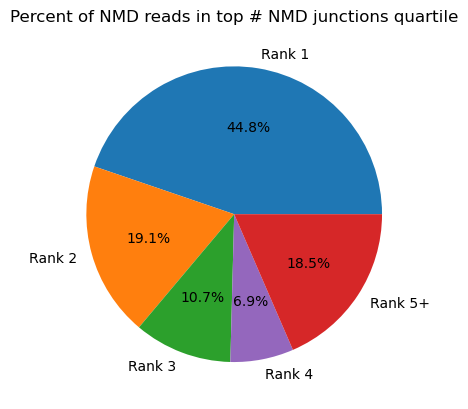

In [492]:
fig, ax = plt.subplots()

df_idx = df_summary.loc[df_summary.total_junctions > df_summary.total_junctions.quantile(0.75)].index


ax.pie(df_rank.loc[df_idx].mean(axis=0), colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red'],
      labels=df_rank.columns, autopct='%1.1f%%')

plt.title('Percent of NMD reads in top # NMD junctions quartile')

In [17]:
nmd_counts = pd.DataFrame(
    long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby('gene').Count.sum())

idx = nmd_counts.index

pc_counts = pd.DataFrame(
    long_table.loc[long_table.SuperAnnotation.isin(PC)].groupby('gene').Count.sum()).reindex(idx).fillna(0)


psi = (nmd_counts.Count/(pc_counts.Count + nmd_counts.Count))

In [16]:
pc_counts

Count
gene                     
ENSG00000000419  136025.0
ENSG00000000457   60388.0
ENSG00000000460  211359.0
ENSG00000000938  392832.0
ENSG00000001036   29583.0
...                   ...
ENSG00000286070       0.0
ENSG00000286132       0.0
ENSG00000286905       0.0
ENSG00000287725       0.0
ENSG00000288534       0.0

[11586 rows x 1 columns]

In [80]:
long_summary = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'junction']).Count.sum().reset_index()
long_summary = long_summary.merge(pd.DataFrame(
    exon_counts.groupby(['gene', 'transcript']).exon_count.sum().reset_index().groupby('gene').exon_count.max()
), left_on='gene', right_index=True)

idx = psi.index

rank_list = []
gene_list = []
suma_list = []
intron_counts_list = []

count = 0
for gene, df in tqdm(long_summary.groupby('gene')):
    
    if gene not in idx:
        continue
    
    suma = int(pc_counts.loc[gene].Count) + int(nmd_counts.loc[gene].Count)
    
    suma_list.append(suma)
    
    intron_counts = list(df.exon_count)[0]
    intron_counts_list.append(intron_counts)

    rank_percent = df.sort_values('Count', ascending=False).Count/suma
    
    rank_percent = sorted(rank_percent)[::-1]
    
    rank = []
    for i in range(5):
        if i >= len(rank_percent):
            to_add = 0
        elif i == 4:
            to_add = np.sum(rank_percent[4:])
        else:
            to_add = rank_percent[i]
        
        rank.append(to_add)
    rank_list.append(rank)
    gene_list.append(gene)
        
    
df_rank = pd.DataFrame(rank_list)
df_rank.columns = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']
df_rank.index = gene_list

df_summary = pd.DataFrame([suma_list, intron_counts_list]).T
df_summary.columns = ['total_reads', 'total_junctions']
df_summary.index = gene_list

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11563/11563 [00:08<00:00, 1301.16it/s]


In [16]:
RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)
RPKM.index = [x.split('.')[0] for x in RPKM.index]

log2RPKM = RPKM[RPKM.columns.intersection(pd.Index(long_table.IndID.unique()))].median(axis=1).reset_index()
log2RPKM.columns = ['gene', 'RPKM']

log2RPKM = log2RPKM.set_index('gene')

Text(0.5, 1.0, 'Top quartile expressed genes (NMD < 20%)')

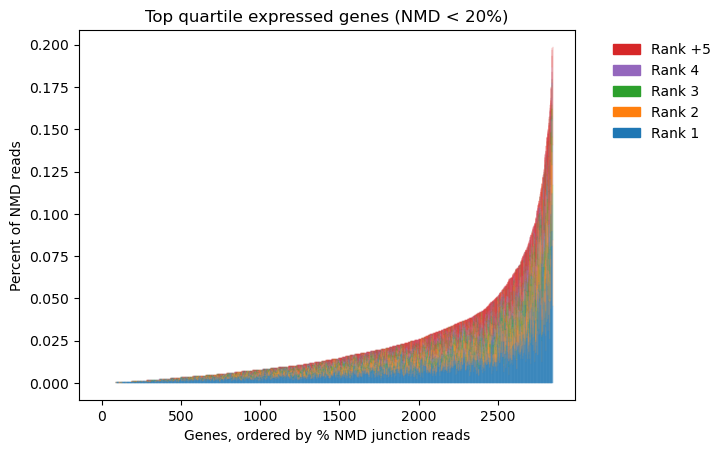

In [30]:
log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[psi <= 0.2].index


top_quartile = log_.loc[log_.RPKM > log_.RPKM.quantile(0.75)].index.intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.loc[df_idx].iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by % NMD junction reads')
plt.ylabel('Percent of NMD reads')

# plt.ylim((-0.005, 0.105))

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('Top quartile expressed genes (NMD < 20%)')

Text(0.5, 1.0, 'All genes (NMD < 20%)')

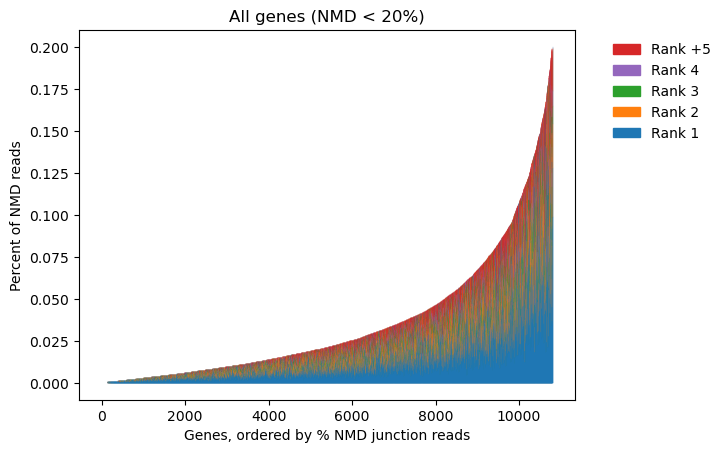

In [29]:
log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[psi <= 0.2].index


top_quartile = log_.index.intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.loc[df_idx].iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by % NMD junction reads')
plt.ylabel('Percent of NMD reads')

# plt.ylim((-0.005, 0.105))

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('All genes (NMD < 20%)')

Text(0.5, 1.0, 'All genes (NMD < 10%)')

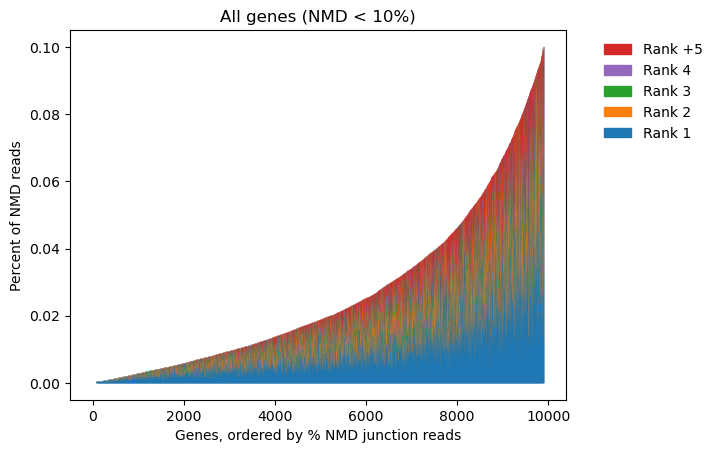

In [32]:
log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[psi <= 0.1].index


top_quartile = log_.index.intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.loc[df_idx].iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by % NMD junction reads')
plt.ylabel('Percent of NMD reads')

# plt.ylim((-0.005, 0.105))

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('All genes (NMD < 10%)')

Text(0.5, 1.0, 'Percent of NMD reads in top # NMD junctions quartile')

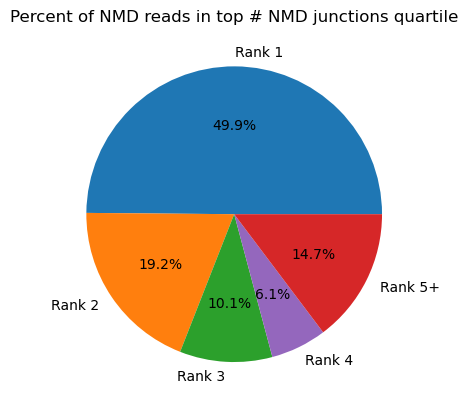

In [51]:

log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi < 0.2)].index


top_quartile = log_.index.intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


fig, ax = plt.subplots()

df_ = df_rank.loc[df_idx].mean(axis=0)

# df_idx = df_summary.loc[df_summary.total_junctions > df_summary.total_junctions.quantile(0.75)].index


ax.pie(df_rank.loc[df_idx].mean(axis=0), colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red'],
      labels=df_rank.columns, autopct='%1.1f%%')

plt.title('Percent of NMD reads in top # NMD junctions quartile')

In [34]:
from scipy.stats import entropy

long_summary = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'junction']).Count.sum().reset_index()
long_summary = long_summary.merge(pd.DataFrame(
    exon_counts.groupby(['gene', 'transcript']).exon_count.sum().reset_index().groupby('gene').exon_count.max()
), left_on='gene', right_index=True)

idx = psi.index

rank_list = []
gene_list = []
suma_list = []
intron_counts_list = []
entropy_list = []

count = 0
for gene, df in tqdm(long_summary.groupby('gene')):
    
    if gene not in idx:
        continue
    
    suma = int(nmd_counts.loc[gene].Count)
    
    suma_list.append(suma)
    
    intron_counts = list(df.exon_count)[0]
    intron_counts_list.append(intron_counts)

    rank_percent = df.sort_values('Count', ascending=False).Count/suma
    
    entropy_ = entropy(rank_percent)
    entropy_list.append(entropy_)
    
    rank_percent = sorted(rank_percent)[::-1]
    
    rank = []
    for i in range(5):
        if i >= len(rank_percent):
            to_add = 0
        elif i == 4:
            to_add = np.sum(rank_percent[4:])
        else:
            to_add = rank_percent[i]
        
        rank.append(to_add)
    rank_list.append(rank)
    gene_list.append(gene)
        
    
df_rank = pd.DataFrame(rank_list)
df_rank.columns = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']
df_rank.index = gene_list

df_summary = pd.DataFrame([suma_list, intron_counts_list, entropy_list]).T
df_summary.columns = ['total_reads', 'total_junctions', 'entropy']
df_summary.index = gene_list

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11563/11563 [00:08<00:00, 1442.43it/s]


Text(0.5, 1.0, 'All genes (NMD < 20%)')

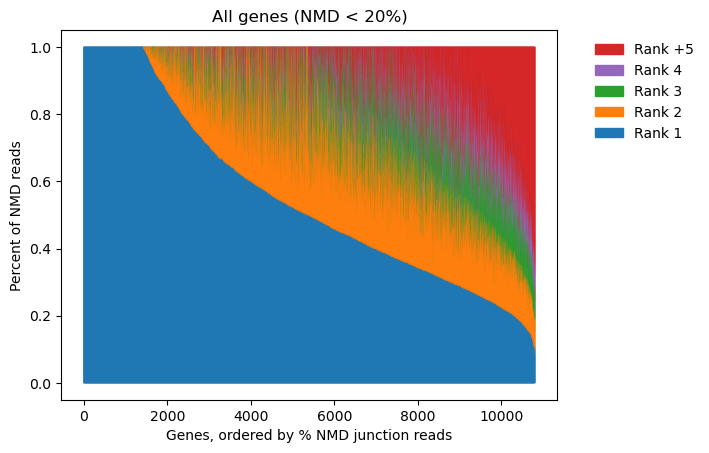

In [63]:
log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[psi <= 0.2].index


top_quartile = log_.index.intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by % NMD junction reads')
plt.ylabel('Percent of NMD reads')

# plt.ylim((-0.005, 0.105))

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('All genes (NMD < 20%)')

Text(0.5, 1.0, 'All genes (0.5% < NMD < 20%)')

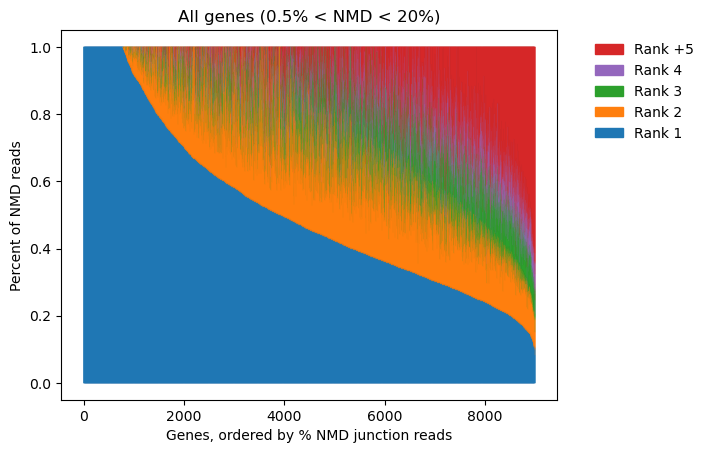

In [64]:
log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.005)].index


top_quartile = log_.index.intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by % NMD junction reads')
plt.ylabel('Percent of NMD reads')

# plt.ylim((-0.005, 0.105))

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('All genes (0.5% < NMD < 20%)')

Text(0.5, 1.0, 'NMD < 20%; +100 NMD counts')

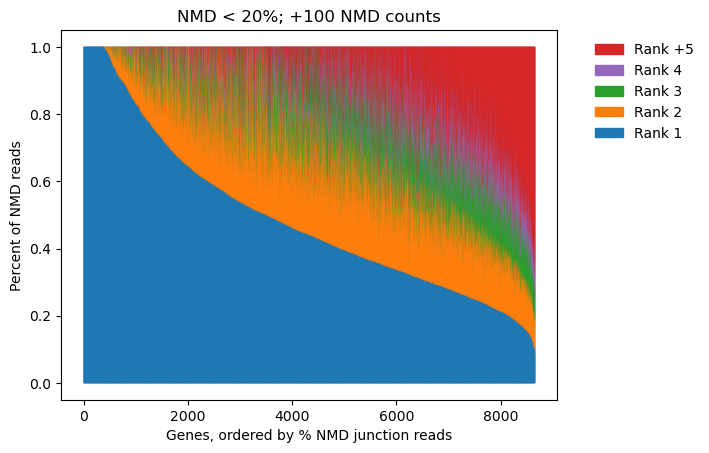

In [74]:
log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[psi <= 0.2].index


top_quartile = nmd_counts.loc[nmd_counts.Count >= 100].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by % NMD junction reads')
plt.ylabel('Percent of NMD reads')

# plt.ylim((-0.005, 0.105))

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('NMD < 20%; +100 NMD counts')

Text(0.5, 1.0, '0.5% < NMD < 20%; +100 NMD counts')

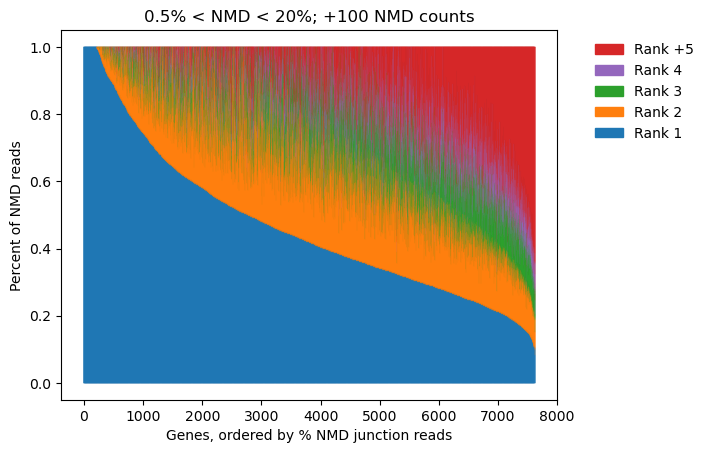

In [75]:
log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.005)].index


top_quartile = nmd_counts.loc[nmd_counts.Count >= 100].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by % NMD junction reads')
plt.ylabel('Percent of NMD reads')

# plt.ylim((-0.005, 0.105))

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('0.5% < NMD < 20%; +100 NMD counts')

Text(0.5, 1.0, 'NMD < 20%; +1000 NMD counts')

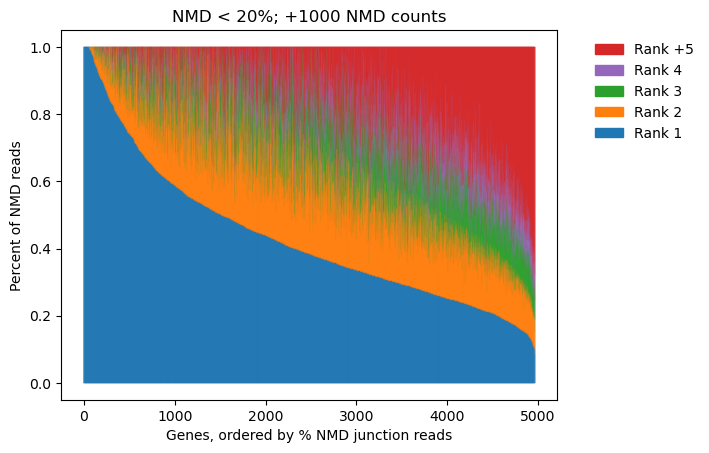

In [76]:
log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[psi <= 0.2].index


top_quartile = nmd_counts.loc[nmd_counts.Count >= 1000].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by % NMD junction reads')
plt.ylabel('Percent of NMD reads')

# plt.ylim((-0.005, 0.105))

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('NMD < 20%; +1000 NMD counts')

Text(0.5, 1.0, '0.5% < NMD < 20%; +1000 NMD counts')

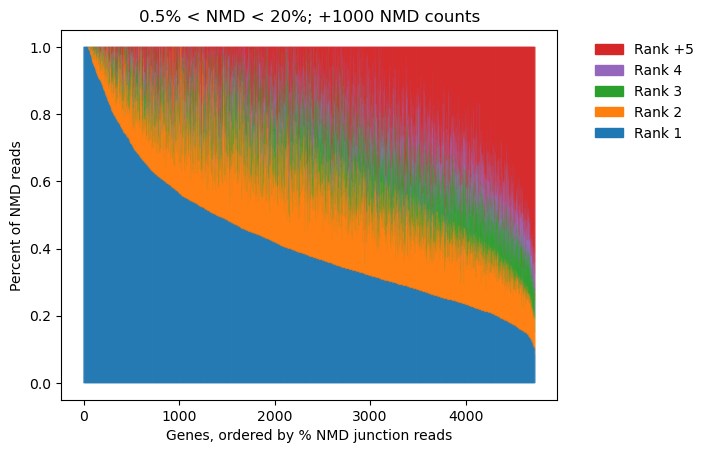

In [77]:
log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.005)].index


top_quartile = nmd_counts.loc[nmd_counts.Count >= 1000].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by % NMD junction reads')
plt.ylabel('Percent of NMD reads')

# plt.ylim((-0.005, 0.105))

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('0.5% < NMD < 20%; +1000 NMD counts')

Text(0.5, 1.0, '0.5% < NMD < 20%; +1000 NMD counts')

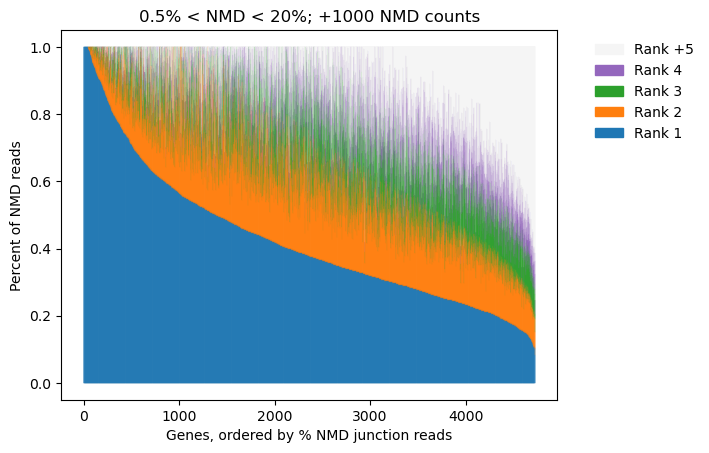

In [79]:
log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.005)].index


top_quartile = nmd_counts.loc[nmd_counts.Count >= 1000].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


plt.fill_between([0, 0], [0,0], color='whitesmoke', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

for idx, row in df_rank.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='whitesmoke',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by % NMD junction reads')
plt.ylabel('Percent of NMD reads')

# plt.ylim((-0.005, 0.105))

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('0.5% < NMD < 20%; +1000 NMD counts')

In [ ]:
long_summary = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'junction']).Count.sum().reset_index()
long_summary = long_summary.merge(pd.DataFrame(
    exon_counts.groupby(['gene', 'transcript']).exon_count.sum().reset_index().groupby('gene').exon_count.max()
), left_on='gene', right_index=True)

idx = psi.index

rank_list = []
gene_list = []
suma_list = []
intron_counts_list = []

count = 0
for gene, df in tqdm(long_summary.groupby('gene')):
    
    if gene not in idx:
        continue
    
    suma = int(pc_counts.loc[gene].Count) + int(nmd_counts.loc[gene].Count)
    
    suma_list.append(suma)
    
    intron_counts = list(df.exon_count)[0]
    intron_counts_list.append(intron_counts)

    rank_percent = df.sort_values('Count', ascending=False).Count/suma
    
    rank_percent = sorted(rank_percent)[::-1]
    
    rank = []
    for i in range(5):
        if i >= len(rank_percent):
            to_add = 0
        elif i == 4:
            to_add = np.sum(rank_percent[4:])
        else:
            to_add = rank_percent[i]
        
        rank.append(to_add)
    rank_list.append(rank)
    gene_list.append(gene)
        
    
df_rank = pd.DataFrame(rank_list)
df_rank.columns = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']
df_rank.index = gene_list

df_summary = pd.DataFrame([suma_list, intron_counts_list]).T
df_summary.columns = ['total_reads', 'total_junctions']
df_summary.index = gene_list

Text(0.5, 1.0, 'All genes')

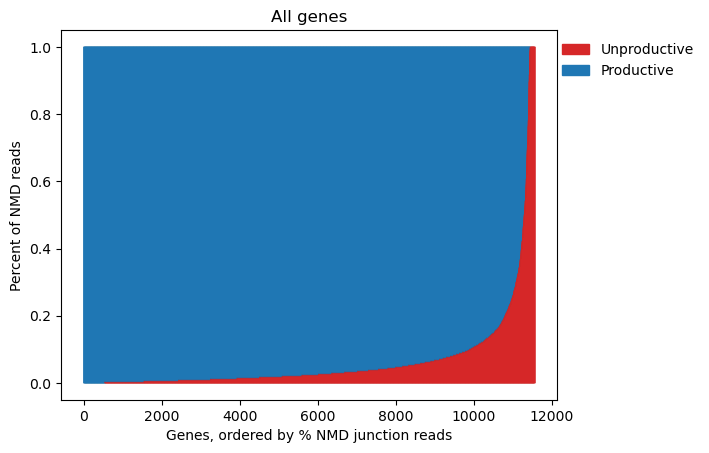

In [81]:
rank_ = df_rank.sum(axis=1).sort_values()


df_idx = rank_.index


plt.fill_between([0, 0], [0,0], color='tab:red', label='Unproductive')
# plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
# plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
# plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Productive')


i = 0

for idx, row in df_rank.loc[df_idx].iterrows():
    plt.plot([i, i], [0, row.sum()], c='tab:red', linewidth=0.2)
    plt.plot([i, i], [row.sum(), 1], c='tab:blue',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by % NMD junction reads')
plt.ylabel('Percent of NMD reads')

# plt.ylim((-0.005, 0.105))

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('All genes')

Text(0.5, 1.0, '0.5% < NMD < 20%; +1000 NMD counts')

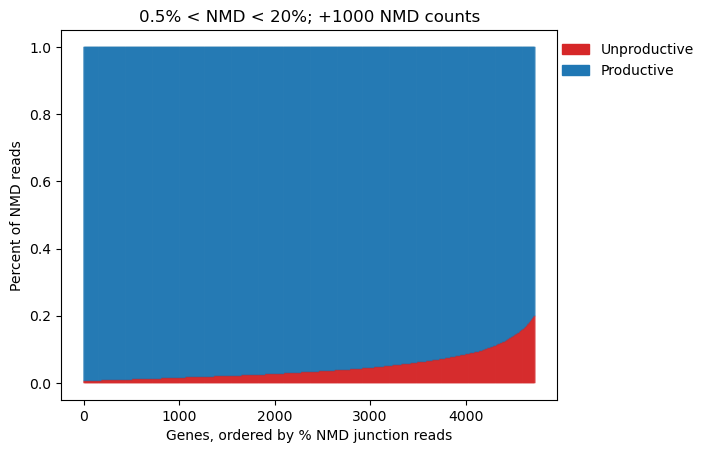

In [90]:
cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.005)].index


top_quartile = nmd_counts.loc[nmd_counts.Count >= 1000].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index




plt.fill_between([0, 0], [0,0], color='tab:red', label='Unproductive')
# plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
# plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
# plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Productive')


i = 0

for idx, row in df_rank.loc[df_idx].iterrows():
    plt.plot([i, i], [0, row.sum()], c='tab:red', linewidth=0.2)
    plt.plot([i, i], [row.sum(), 1], c='tab:blue',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by % NMD junction reads')
plt.ylabel('Percent of NMD reads')

# plt.ylim((-0.005, 0.105))

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('0.5% < NMD < 20%; +1000 NMD counts')

Text(0.5, 1.0, '0.1% < NMD < 20%; +100 NMD counts')

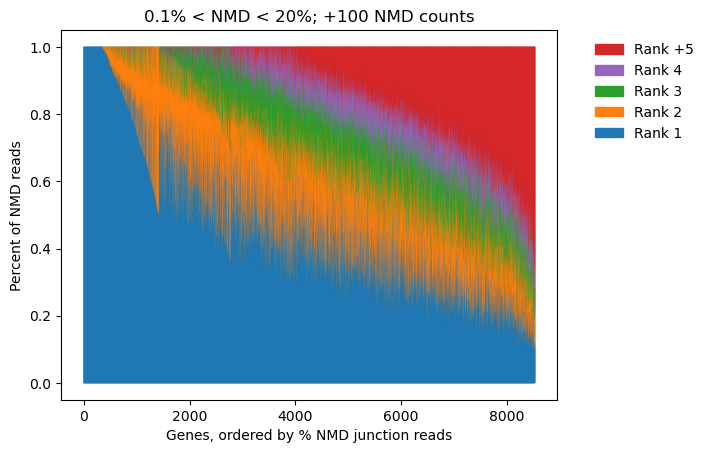

In [36]:

log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.001)].index


top_quartile = nmd_counts.loc[nmd_counts.Count >= 100].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

df_rank_ = df_rank.divide(df_rank.sum(axis=1), axis=0)

entropy_idx = df_summary.loc[df_idx].sort_values('entropy').index


# for idx, row in df_rank_.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
for idx, row in df_rank_.loc[entropy_idx].iterrows():

    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by % NMD junction reads')
plt.ylabel('Percent of NMD reads')

# plt.ylim((-0.005, 0.105))

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('0.1% < NMD < 20%; +100 NMD counts')

Text(0.5, 1.0, 'all genes')

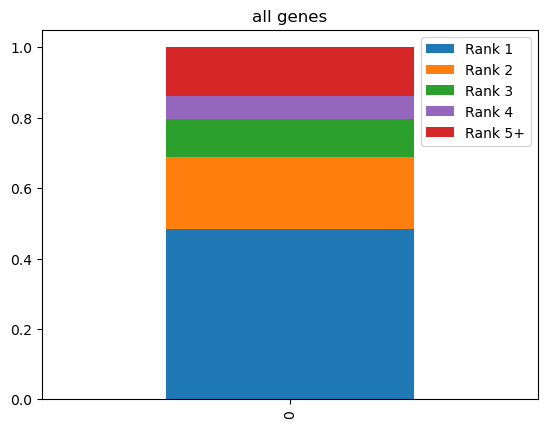

In [37]:
pd.DataFrame(df_rank_.loc[df_idx].mean(axis=0)).T.plot(kind='bar', stacked=True, color=['tab:blue', 'tab:orange', 'tab:green', 
                                                                            'tab:purple', 'tab:red'])
plt.title(r'all genes')

Text(0.5, 1.0, '1% < NMD < 20%; +100 NMD counts')

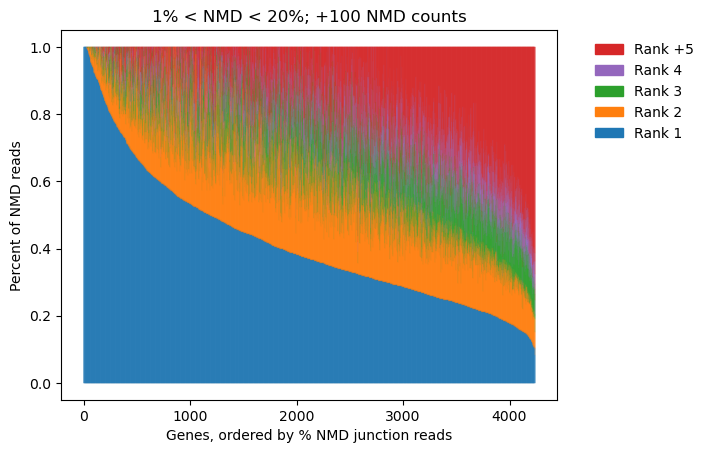

In [24]:

log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.01)].index


top_quartile = nmd_counts.loc[nmd_counts.Count >= 1000].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

df_rank_ = df_rank.divide(df_rank.sum(axis=1), axis=0)


for idx, row in df_rank_.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by % NMD junction reads')
plt.ylabel('Percent of NMD reads')

# plt.ylim((-0.005, 0.105))

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('1% < NMD < 20%; +100 NMD counts')

Text(0.5, 1.0, 'all genes')

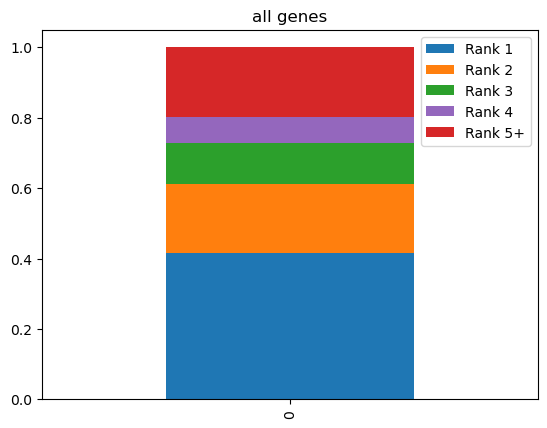

In [25]:
pd.DataFrame(df_rank_.loc[df_idx].mean(axis=0)).T.plot(kind='bar', stacked=True, color=['tab:blue', 'tab:orange', 'tab:green', 
                                                                            'tab:purple', 'tab:red'])
plt.title(r'all genes')

In [35]:
df_summary

total_reads  total_junctions   entropy
ENSG00000000419        948.0              9.0  0.839670
ENSG00000000457       3531.0             14.0  2.145157
ENSG00000000460       7421.0             25.0  2.471800
ENSG00000000938      12244.0             13.0  1.367709
ENSG00000001036        163.0              7.0  0.550230
...                      ...              ...       ...
ENSG00000286070       1693.0             16.0  1.019461
ENSG00000286132         13.0              5.0  1.057905
ENSG00000286905        969.0             12.0  0.956316
ENSG00000287725         54.0             15.0  0.450561
ENSG00000288534        171.0             21.0  0.188934

[11563 rows x 3 columns]

Text(0.5, 1.0, '1% < NMD < 20%; +100 NMD counts')

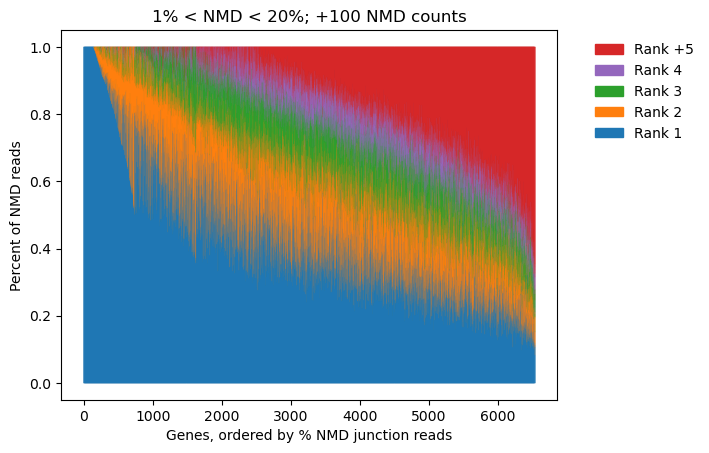

In [38]:

log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.01)].index


top_quartile = nmd_counts.loc[nmd_counts.Count >= 100].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

df_rank_ = df_rank.divide(df_rank.sum(axis=1), axis=0)

entropy_idx = df_summary.loc[df_idx].sort_values('entropy').index


# for idx, row in df_rank_.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
for idx, row in df_rank_.loc[entropy_idx].iterrows():

    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by % NMD junction reads')
plt.ylabel('Percent of NMD reads')

# plt.ylim((-0.005, 0.105))

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('1% < NMD < 20%; +100 NMD counts')

Text(0.5, 1.0, 'all genes')

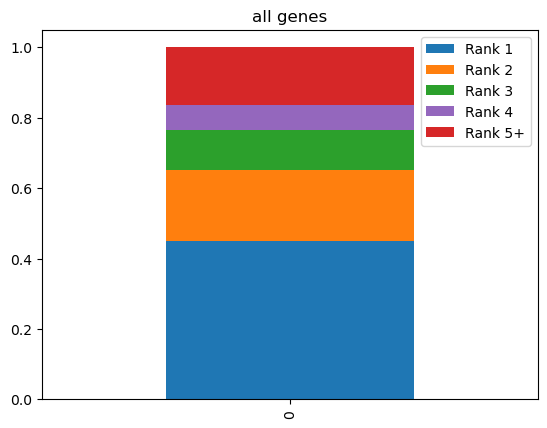

In [40]:
pd.DataFrame(df_rank_.loc[df_idx].mean(axis=0)).T.plot(kind='bar', stacked=True, color=['tab:blue', 'tab:orange', 'tab:green', 
                                                                            'tab:purple', 'tab:red'])
plt.title(r'all genes')

In [45]:
psi

gene
ENSG00000000419    0.006921
ENSG00000000457    0.055242
ENSG00000000460    0.033920
ENSG00000000938    0.030226
ENSG00000001036    0.005480
                     ...   
ENSG00000286070    1.000000
ENSG00000286132    1.000000
ENSG00000286905    1.000000
ENSG00000287725    1.000000
ENSG00000288534    1.000000
Name: Count, Length: 11586, dtype: float64

Text(0.5, 1.0, '0.1% < NMD < 20%; +100 NMD counts')

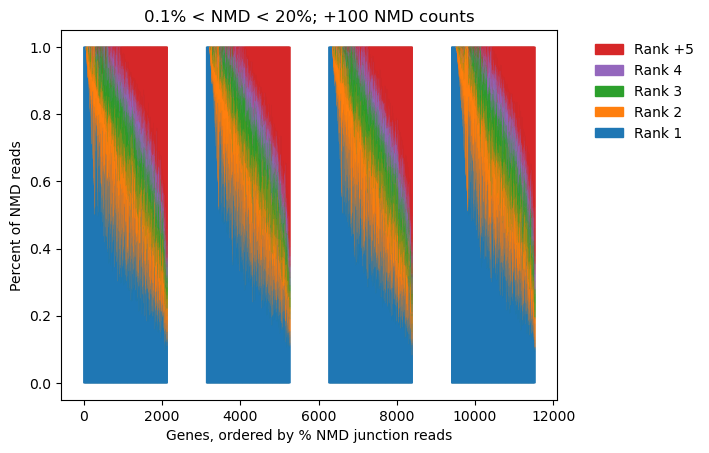

In [47]:

log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.001)].index


top_quartile = nmd_counts.loc[nmd_counts.Count >= 100].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

df_rank_ = df_rank.divide(df_rank.sum(axis=1), axis=0)

# entropy_idx = df_summary.loc[df_idx].sort_values('entropy').index

RPKM_entropy = log2RPKM.loc[df_idx]

Q1 = RPKM_entropy.loc[RPKM_entropy.RPKM <= RPKM_entropy.RPKM.quantile(0.25)].index
Q2 = RPKM_entropy.loc[(RPKM_entropy.RPKM <= RPKM_entropy.RPKM.quantile(0.5)) & (RPKM_entropy.RPKM > RPKM_entropy.RPKM.quantile(0.25))].index
Q3 = RPKM_entropy.loc[(RPKM_entropy.RPKM <= RPKM_entropy.RPKM.quantile(0.75)) & (RPKM_entropy.RPKM > RPKM_entropy.RPKM.quantile(0.5))].index
Q4 = RPKM_entropy.loc[RPKM_entropy.RPKM > RPKM_entropy.RPKM.quantile(0.75)].index

entropy_Q1 = df_summary.loc[Q1].sort_values('entropy').index
entropy_Q2 = df_summary.loc[Q2].sort_values('entropy').index
entropy_Q3 = df_summary.loc[Q3].sort_values('entropy').index
entropy_Q4 = df_summary.loc[Q4].sort_values('entropy').index


# for idx, row in df_rank_.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
for idx, row in df_rank_.loc[entropy_Q1].iterrows():

    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
i += 1000
    
for idx, row in df_rank_.loc[entropy_Q2].iterrows():

    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
i += 1000
    
for idx, row in df_rank_.loc[entropy_Q3].iterrows():

    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
i += 1000
    
for idx, row in df_rank_.loc[entropy_Q4].iterrows():

    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by % NMD junction reads')
plt.ylabel('Percent of NMD reads')

# plt.ylim((-0.005, 0.105))

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('0.1% < NMD < 20%; +100 NMD counts')

Text(0.5, 1.0, '0.1% < NMD < 20%; +100 NMD counts')

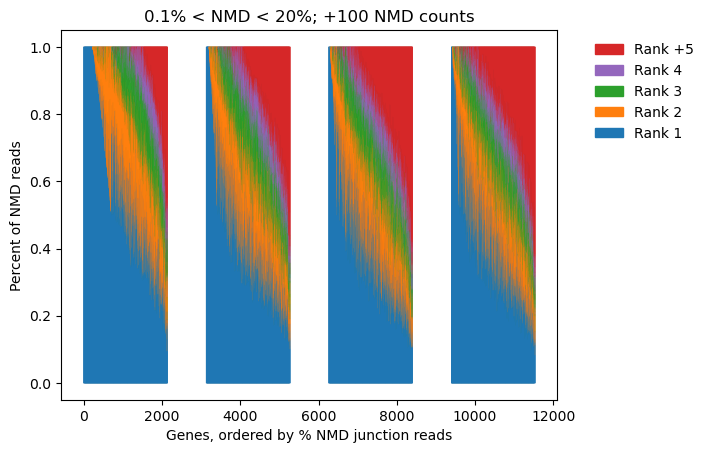

In [46]:

log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.001)].index


top_quartile = nmd_counts.loc[nmd_counts.Count >= 100].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


plt.fill_between([0, 0], [0,0], color='tab:red', label='Rank +5')
plt.fill_between([0, 0], [0,0], color='tab:purple', label='Rank 4')
plt.fill_between([0, 0], [0,0], color='tab:green', label='Rank 3')
plt.fill_between([0, 0], [0,0], color='tab:orange', label='Rank 2')
plt.fill_between([0, 0], [0,0], color='tab:blue', label='Rank 1')


i = 0

df_rank_ = df_rank.divide(df_rank.sum(axis=1), axis=0)

# entropy_idx = df_summary.loc[df_idx].sort_values('entropy').index

psi_entropy = psi.loc[df_idx]

Q1 = psi_entropy.loc[psi_entropy <= psi_entropy.quantile(0.25)].index
Q2 = psi_entropy.loc[(psi_entropy <= psi_entropy.quantile(0.5)) & (psi_entropy > psi_entropy.quantile(0.25))].index
Q3 = psi_entropy.loc[(psi_entropy <= psi_entropy.quantile(0.75)) & (psi_entropy > psi_entropy.quantile(0.5))].index
Q4 = psi_entropy.loc[psi_entropy > psi_entropy.quantile(0.75)].index

entropy_Q1 = df_summary.loc[Q1].sort_values('entropy').index
entropy_Q2 = df_summary.loc[Q2].sort_values('entropy').index
entropy_Q3 = df_summary.loc[Q3].sort_values('entropy').index
entropy_Q4 = df_summary.loc[Q4].sort_values('entropy').index


# for idx, row in df_rank_.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
for idx, row in df_rank_.loc[entropy_Q1].iterrows():

    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
i += 1000
    
for idx, row in df_rank_.loc[entropy_Q2].iterrows():

    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
i += 1000
    
for idx, row in df_rank_.loc[entropy_Q3].iterrows():

    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
i += 1000
    
for idx, row in df_rank_.loc[entropy_Q4].iterrows():

    plt.plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    plt.plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    plt.plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
plt.xlabel('Genes, ordered by % NMD junction reads')
plt.ylabel('Percent of NMD reads')

# plt.ylim((-0.005, 0.105))

plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
plt.title('0.1% < NMD < 20%; +100 NMD counts')

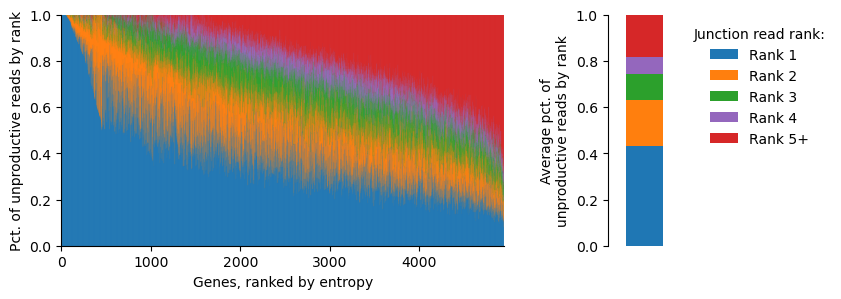

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), gridspec_kw={'width_ratios': [6, 1], 
                                                                       'wspace': 0.4})

log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.001)].index


top_quartile = nmd_counts.loc[nmd_counts.Count >= 1000].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


i = 0

df_rank_ = df_rank.divide(df_rank.sum(axis=1), axis=0)

entropy_idx = df_summary.loc[df_idx].sort_values('entropy').index


# for idx, row in df_rank_.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
for idx, row in df_rank_.loc[entropy_idx].iterrows():
# for idx, row in df_rank_.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
    ax[0].plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    ax[0].plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
ax[0].set_xlabel('Genes, ranked by entropy')
ax[0].set_ylabel('Pct. of unproductive reads by rank')

# plt.ylim((-0.005, 0.105))

# plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
# plt.title('1% < NMD < 20%; +100 NMD counts')

ax[0].set_ylim([0, 1])
ax[0].set_xlim([0, i])
ax[1].set_ylim([0, 1])


# sns.despine(ax=ax[0], offset=0, trim=True)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

pd.DataFrame(df_rank_.loc[df_idx].mean(axis=0)).T.plot(kind='bar', stacked=True, color=['tab:blue', 'tab:orange', 'tab:green', 
                                                                            'tab:purple', 'tab:red'], ax=ax[1])

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

ax[1].set_ylabel('Average pct. of\nunproductive reads by rank')
# sns.despine(ax=ax[1], offset=0, trim=True)

ax[1].set_xticks([])
# plt.title(r'all genes')
ax[1].legend(bbox_to_anchor=(1, 1), frameon=False, title = 'Junction read rank:')

plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.multipanel.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.multipanel.png', dpi=300, bbox_inches='tight',)

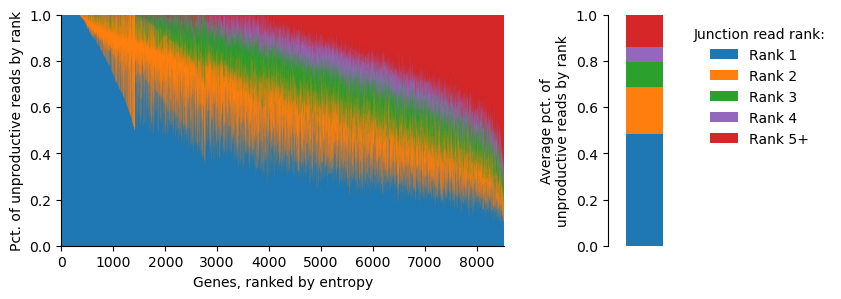

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), gridspec_kw={'width_ratios': [6, 1], 
                                                                       'wspace': 0.4})

log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.001)].index


top_quartile = nmd_counts.loc[nmd_counts.Count >= 100].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


i = 0

df_rank_ = df_rank.divide(df_rank.sum(axis=1), axis=0)

entropy_idx = df_summary.loc[df_idx].sort_values('entropy').index


# for idx, row in df_rank_.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
for idx, row in df_rank_.loc[entropy_idx].iterrows():
# for idx, row in df_rank_.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
    ax[0].plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    ax[0].plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
ax[0].set_xlabel('Genes, ranked by entropy')
ax[0].set_ylabel('Pct. of unproductive reads by rank')

# plt.ylim((-0.005, 0.105))

# plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
# plt.title('1% < NMD < 20%; +100 NMD counts')

ax[0].set_ylim([0, 1])
ax[0].set_xlim([0, i])
ax[1].set_ylim([0, 1])


# sns.despine(ax=ax[0], offset=0, trim=True)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

pd.DataFrame(df_rank_.loc[df_idx].mean(axis=0)).T.plot(kind='bar', stacked=True, color=['tab:blue', 'tab:orange', 'tab:green', 
                                                                            'tab:purple', 'tab:red'], ax=ax[1])

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

ax[1].set_ylabel('Average pct. of\nunproductive reads by rank')
# sns.despine(ax=ax[1], offset=0, trim=True)

ax[1].set_xticks([])
# plt.title(r'all genes')
ax[1].legend(bbox_to_anchor=(1, 1), frameon=False, title = 'Junction read rank:')

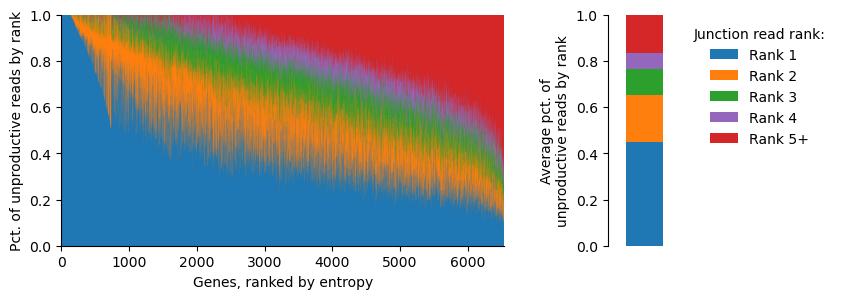

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), gridspec_kw={'width_ratios': [6, 1], 
                                                                       'wspace': 0.4})

log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.01)].index


top_quartile = nmd_counts.loc[nmd_counts.Count >= 100].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()


df_idx = rank_.index


i = 0

df_rank_ = df_rank.divide(df_rank.sum(axis=1), axis=0)

entropy_idx = df_summary.loc[df_idx].sort_values('entropy').index


# for idx, row in df_rank_.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
for idx, row in df_rank_.loc[entropy_idx].iterrows():
# for idx, row in df_rank_.loc[df_idx].sort_values('Rank 1', ascending=False).iterrows():
    ax[0].plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    ax[0].plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
ax[0].set_xlabel('Genes, ranked by entropy')
ax[0].set_ylabel('Pct. of unproductive reads by rank')

# plt.ylim((-0.005, 0.105))

# plt.legend(frameon=False, bbox_to_anchor=(1.3, 1),)
# plt.title('1% < NMD < 20%; +100 NMD counts')

ax[0].set_ylim([0, 1])
ax[0].set_xlim([0, i])
ax[1].set_ylim([0, 1])


# sns.despine(ax=ax[0], offset=0, trim=True)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

pd.DataFrame(df_rank_.loc[df_idx].mean(axis=0)).T.plot(kind='bar', stacked=True, color=['tab:blue', 'tab:orange', 'tab:green', 
                                                                            'tab:purple', 'tab:red'], ax=ax[1])

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

ax[1].set_ylabel('Average pct. of\nunproductive reads by rank')
# sns.despine(ax=ax[1], offset=0, trim=True)

ax[1].set_xticks([])
# plt.title(r'all genes')
ax[1].legend(bbox_to_anchor=(1, 1), frameon=False, title = 'Junction read rank:')